In [1]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
import geopandas as gpd
from matplotlib import transforms
import re
from shapely.geometry import Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
import gdal
import osr
from PIL import Image 
import cv2
from osgeo import gdal_array
from rasterio.plot import show
import random
import spectral
import h5py
import json
import math
from osgeo import gdal,ogr,osr
import affine
import matplotlib.gridspec as gridspec
from glob import glob
from datetime import datetime
from osgeo import gdal

In [2]:
# Change this to where ever your data files are located
data_dir = r"D:\Permanent Thesis Workspace\Final datasets of 3 sensors"
files = os.listdir(data_dir)

# header file of the image
data_hdr = r"D:\Permanent Thesis Workspace\Final datasets of 3 sensors\AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01.hdr"
data_hdr = glob(os.path.join(data_hdr))

def planck_um(lam, T):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c1/(lam**5*(np.exp(c2/(lam*T))-1))

def inv_planck_um(lam, radiance):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c2/(lam*np.log(c1/(lam**5*radiance)+1))

# Test functions
print(planck_um(11, 290), 'W/m2*sr*um should be ', 8.222077035769829,'W/m2*sr*um')
print(inv_planck_um(11, 1000), 'K should be ', 2362.5656807352184,'K')

8.222072203488061 W/m2*sr*um should be  8.222077035769829 W/m2*sr*um
2362.5793738804778 K should be  2362.5656807352184 K


In [3]:
# Extracting start and end times from defined image path
# When intputting file path,
#-----date, start-time, end-time, start date-time, end-time, and others are pulled from files that have '2019' in the name
def extract_start_end_datetime(file):
    date_index = file.find('2019')
    date = file[date_index:date_index+4]+"-"+file[date_index+4:date_index+6]+"-"+file[date_index+6:date_index+8]
    start_time = file[date_index+9: date_index+11]+":"+file[date_index+11:date_index+13]
    end_time = file[date_index+14: date_index+16]+":"+file[date_index+16:date_index+18]
    start_datetime = np.datetime64(date+"T"+start_time)
    end_datetime = np.datetime64(date+"T"+end_time)
    day_time = float(file[date_index+9: date_index+11])-7+float(file[date_index+11:date_index+13])/60
    return (start_datetime, end_datetime, day_time)

In [4]:
# The georeferenced images are the band_filenames list that is first down below

band_filenames = []
fdi_filenames = []
start_datetimes = []
day_times = []
end_datetimes = []
durations = []
flight_tracks = []

for file in files:
    if(file.endswith('sc01')):
        #print('bands',file)
        print('RadianceMask',file+"_SWIRMask") # 'fdi', file + "_fdi" is the original text
        #print(extract_start_end_datetime(file))
        (start_datetime, end_datetime, day_time) = extract_start_end_datetime(file)
        start_datetimes.append(start_datetime)
        end_datetimes.append(end_datetime)
        durations.append(end_datetime-start_datetime)
        band_filenames.append(file)
        fdi_filenames.append(file+"_SWIRMask")
        date_index = file.find('2019')
        flight_track = file[date_index-9:date_index-1]
        flight_tracks.append(flight_track)
        day_times.append(day_time)

print(start_datetimes)
        
df = pd.DataFrame({'flight_track':flight_tracks,'start_time':start_datetimes,'day_time':day_times, 'end_time':end_datetimes,
                   'duration':durations,'band_file':band_filenames, 'fdi_file':fdi_filenames})
df = df.sort_values('start_time')
df = df.reset_index(drop=True)

df['start_time']=df['start_time'].dt.tz_localize(tz='UTC')
df['start_time']=df['start_time'].dt.tz_convert(tz='US/Pacific')
df['end_time']=df['end_time'].dt.tz_localize(tz='UTC')
df['end_time']=df['end_time'].dt.tz_convert(tz='US/Pacific')


print(df)
print(df.dtypes)

RadianceMask AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01_SWIRMask
[numpy.datetime64('2019-08-06T18:41')]
  flight_track                start_time   day_time                  end_time  \
0     19910_06 2019-08-06 11:41:00-07:00  11.683333 2019-08-06 12:00:00-07:00   

  duration                                          band_file  \
0 00:19:00  AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01   

                                            fdi_file  
0  AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_s...  
flight_track                        object
start_time      datetime64[ns, US/Pacific]
day_time                           float64
end_time        datetime64[ns, US/Pacific]
duration                   timedelta64[ns]
band_file                           object
fdi_file                            object
dtype: object


In [5]:
# takes in the row/col position of the fire pixel, then the fdi array

def get_nonfire_neighbors(row, col, fdi): 
    
    #creates empty list for nonfire_neighbors to be exported
    nonfire_neighbors = []
    
    # Tuple is created from the fdi shape----e.g. (711,336)
    (num_row, num_col) = fdi.shape  
 
    # bound 1 as a starting point to loop through
    bound = 1
    
    # while the bound is less than 5 and the nonFire_neighbors have less than 5 pixels
    while(bound <4):
        for i in range(row-bound, row+bound + 1):   # for i in the range of the row bounds
            print("Row",i)
            for j in range(col-bound, col+bound + 1):  # for j in the range of columns
                print("Col",j)
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    print("Pixel:", (i,j), "is non-fire")
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        print("Next bound round")
        bound += 1
    return nonfire_neighbors


In [8]:
# header file information for the purposes of reading wavelength information
# Creation of a geodataframe filled with variables no limited to: xy coord, FRP data, and 
# ---background spectral radiance information.


fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry",
                                             "dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon",
                                             "atmo_transmit","LfMIR","Lbkg","Num_nonFire_background"])

fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []
fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
        
    # print(band_file)
    fp = data_dir+"/"+band_file
    #print(fp)
    raster = rio.open(fp)
    #print(raster)
    if (not raster.count == 224):
        continue
    
    for hdr in data_hdr:
        with open(hdr, "r") as src:
            #print(src)
            all_data = [line.strip() for line in src.readlines()]
            bands = all_data[243:]
            wls = []
            #print(all_data)
            for vals in bands:
                vals = vals.replace("\n","")
                #print(vals)
                vals1 = vals[0:10]
                vals2= vals[13:23]
                vals3= vals[26:36]
                vals4 = vals[39:49]
                vals5 = vals[52:62]
                vals6 = vals[65:75]
                print(vals1)
                print(vals2)
                print(vals3)
                print(vals4)
                print(vals5)
                print(vals6)


365.929810
375.593994
385.262512
394.935486
404.612915
414.294586
423.980804
433.671295
443.366211
453.065491
462.769196
472.477295
482.189789
491.906586
501.627899
511.353485
521.083618
530.817993
540.556824
550.299988
560.047729
569.799622
579.556030
589.316772
599.081909
608.851501
618.625427
628.403687
638.186523
647.973572
657.765076
667.560974
654.792297
664.599426
674.401184
684.197876
693.989380
703.775574
713.556580
723.332520
733.103088
742.868530
752.628723
762.383728
772.133484
781.878113
791.617371
801.351624
811.080505
820.804321
830.522827
840.236084
849.944214
859.647095
869.344788
879.037170
888.724487
898.406616
908.083374
917.755127
927.421387
937.082703
946.738708
956.389526
966.035095
975.675476
985.310608
994.940613
004.565002
014.184998
023.799011
033.407959
1043.01196
1052.61096
1062.20397
1071.79296
1081.37597
1090.95397
1100.52600
1110.09399
1119.65600
1129.21301
1138.76501
1148.31103
1157.85302
1167.38903
1176.92004
1186.44604
1195.96594
1205.48205
1214.99194

In [7]:
# header file information for the purposes of reading wavelength information
# Creation of a geodataframe filled with variables no limited to: xy coord, FRP data, and 
# ---background spectral radiance information.


fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry",
                                             "dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon",
                                             "atmo_transmit","LfMIR","Lbkg","Num_nonFire_background"])

fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []
fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
        
    # print(band_file)
    fp = data_dir+"/"+band_file
    #print(fp)
    raster = rio.open(fp)
    #print(raster)
    if (not raster.count == 224):
        continue
    
    for hdr in data_hdr:
        with open(hdr, "r") as src:
            #print(src)
            all_data = [line.strip() for line in src.readlines()]
            bands = all_data[243:]
            wls = []
            #print(all_data)
            for vals in bands:
                vals = vals.replace("\n","")
                #print(vals)
                vals1 = vals[0:10]
                vals2= vals[13:23]
                vals3= vals[26:36]
                vals4 = vals[39:49]
                vals5 = vals[52:62]
                vals6 = vals[65:75]
                #print(vals1)
                #print(vals2)
                #print(vals3)
                #print(vals4)
                #print(vals5)
                #print(vals6)
                wls.append(vals1)
                wls.append(vals2)
                wls.append(vals3)
                wls.append(vals4)
                wls.append(vals5)
                wls.append(vals6)
                #print(len(wls))
            new_wls = wls[0:224]
            wls= []
            for values in new_wls:
                wls.append(float(values))
    print("Number of bands:",len(wls))
    #print(wls)
    wls = sorted(wls)
    
    band_data_array = raster.read()
    #print(len(band_data_array))

    #print(wls)
    fp_fdi = data_dir+"/"+fdi_file
    print(fp_fdi)
    raster_fdi = rio.open(fp_fdi)
    fdi_data_array = raster_fdi.read()[0]
    (row,col)=np.nonzero(fdi_data_array)

    fire_pixels = {}
    num_fire_pixels += len(row)
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_pixels[(row_ind, col_ind)] = get_nonfire_neighbors(row_ind, col_ind, fdi_data_array)

    
    
    MIR_ind = wls.index(2386.10498)
    #TIR_ind = wls.index(10.71)
    #rint(MIR_ind)
    #rint(TIR_ind)
    a = 5.14498521e-09 # T**4 fit coefficient
    b = 3.9600042e-12 # T**5 fit coefficient
    epsilon = 0.8   # Assume a value for emissivity for T**5 FRP
    sigma = 5.67*10**(-8)
    A = 16.4*16.4 # Pixel area is 19x19  meters
    atmo_transmit = 0.99788 # Atmospheric transmittance
    C = 3*10**8
    FRPs = []
    
    fire_detection_times.append(fire_time)
    fire_detection_number.append(len(row))
    total_FRP = 0
    
    frp_data_array = np.zeros_like(fdi_data_array, dtype=float)
    
    #"dataset","row","col","FRP","FRP_T5","epsilon","LfMIR","Lbkg"
    fire_detect_start_times = []
    fire_detect_end_times = []
    fire_detect_xcoords = []
    fire_detect_ycoords = []
    fire_detect_nf_xcoords= []
    fire_detect_nf_ycoords= []
    fire_detect_number_nonfire_neighbors= []
    fire_detect_datasets = []
    fire_detect_rows = []
    fire_detect_cols = []
    fire_detect_FRPs = []
    fire_detect_FRP_T5s = []
    fire_detect_epsilons = []
    fire_detect_atmo_transmits = []
    fire_detect_LfMIRs = []
    fire_detect_Lbkgs = []
    fire_detect_FRP_ratios = []
    fire_detect_points = []
    
    for i in range(0, len(row)):
        
        # creating row_col variables for each fire cell
        row_ind = row[i]
        col_ind = col[i]
        
        # creating fire_neighbors variable that has non-fire pixels position  
        fire_neighbors = fire_pixels[(row_ind, col_ind)]
        
        # the number of non-fire pixel neighbors
        num_fire_neighbors = len(fire_neighbors)
        fire_detect_number_nonfire_neighbors.append(num_fire_neighbors)
        
        # if there is 0 in the number of non-fire pixel neighbors, then create a num_fire_no_bacgrnd and add onto it for--
        #--------each loop
        if(num_fire_neighbors==0):
            num_fire_no_background+=1
            continue
       
        fire_detect_start_times.append(fire_time)
        fire_detect_end_times.append(fire_end_time)
        fire_detect_datasets.append(band_file)
        
        # appending the individual row/col variables within each loop to fire_Detect_rows/cols 
        fire_detect_rows.append(row_ind)
        fire_detect_cols.append(col_ind)
        #print(row_ind)
        #print(col_ind)
        
        # Then project the pixel positon points to x,y coordinates (to meteres)
        (x_coord, y_coord) = rio.transform.xy(raster.transform, row_ind, col_ind, offset="ul")
        
        # then append those x,y points to the empty list variables
        fire_detect_points.append(Point(x_coord, y_coord))
        fire_detect_xcoords.append(x_coord)
        fire_detect_ycoords.append(y_coord)
        fire_detect_epsilons.append(epsilon)
        fire_detect_atmo_transmits.append(atmo_transmit)
        
        # creating none value for radiance backrgound (L_background)
        # this value will accumulate the background radiance values from the loop down below
        #----then eventually the total will be divded to get an average background value
        L_background = 0
        
        # loop throgh row/col of fire neighbpors (they are in tuple format, thus (row_n,col_n))
        # if there is 13 values in fire_neighbors, it will loop through 13 times for example.
        for (row_n, col_n) in fire_neighbors:
            
            # convert backgground pixel positions to xy coordinates in meters
            (x_nf_coord, y_nf_coord) = rio.transform.xy(raster.transform, row_n, col_n, offset="ul")
            fire_detect_nf_xcoords.append(x_nf_coord)
            fire_detect_nf_ycoords.append(y_nf_coord)
            
            # retrieveing the value of the 24th band of the raster by getting its col/row position
            L_background += band_data_array[MIR_ind,row_n,col_n]
        
        # then divide the total accumnulated background radiance (L_background) by the number of pixels to get average value
        L_background = L_background / num_fire_neighbors

        # then calculate the total difference between the radiance value of the fire pixel and the average value of background
        LfMIR = (band_data_array[MIR_ind, row_ind, col_ind] - L_background) / atmo_transmit
        
        # then apply forumula of frp
        FRP = A*sigma*LfMIR/a
        FRP_T5 = A*sigma*epsilon**(1./5)*(LfMIR**(4./5))/(b**(4./5))
        FRPs.append(FRP)
        
        fire_detect_Lbkgs.append(L_background)
        fire_detect_LfMIRs.append(LfMIR)
        #print(FRP)
        fire_detect_FRPs.append(FRP)
        fire_detect_FRP_T5s.append(FRP_T5)
        fire_detect_FRP_ratios.append(FRP_T5/FRP)
        
        fire_times.append(fire_time)
        fire_frps.append(FRP)
        fire_datasets.append(band_file)
        fire_rows.append(row_ind)
        fire_cols.append(col_ind)
        
        fire_LfMIR.append(LfMIR)
        fire_Lbackground.append(L_background)
        total_FRP += FRP
        frp_data_array[row_ind, col_ind] = FRP
        
        
        fire_total_FRP.append(total_FRP)
        
        
    nonFire_detect_flighttrack = gpd.GeoDataFrame(columns=["X_coords", "Y_coords"])
    nonFire_detect_flighttrack['X_coords'] = fire_detect_nf_xcoords
    nonFire_detect_flighttrack['Y_coords'] = fire_detect_nf_ycoords
    
    fire_total_FRP.append(total_FRP)
    print(len(fire_detect_start_times), len(fire_detect_FRPs))
    fire_detect_flighttrack = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
    fire_detect_flighttrack["start_time"] = fire_detect_start_times
    fire_detect_flighttrack["end_time"] = fire_detect_end_times
    fire_detect_flighttrack["x_coord"] = fire_detect_xcoords
    fire_detect_flighttrack["y_coord"] = fire_detect_ycoords
    fire_detect_flighttrack["dataset"] = fire_detect_datasets
    fire_detect_flighttrack["row"] = fire_detect_rows
    fire_detect_flighttrack["col"] = fire_detect_cols
    fire_detect_flighttrack["FRP"] = fire_detect_FRPs
    fire_detect_flighttrack["FRP_T5"] = fire_detect_FRP_T5s
    fire_detect_flighttrack["FRP_ratio"] = fire_detect_FRP_ratios
    fire_detect_flighttrack["epsilon"] = fire_detect_epsilons
    fire_detect_flighttrack["atmo_transmit"] = fire_detect_atmo_transmits
    fire_detect_flighttrack["LfMIR"] = fire_detect_LfMIRs
    fire_detect_flighttrack["Lbkg"] = fire_detect_Lbkgs
    fire_detect_flighttrack["Num_nonFire_background"] = fire_detect_number_nonfire_neighbors
        
    s = gpd.GeoSeries(fire_detect_points)
    s.crs = "EPSG:32611"
    fire_detect_flighttrack['geometry'] = s
    
    # "FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"
    #,columns=["start_time","end_time","lat","lon","dataset","row","col","FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"]
    #pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
    fire_detect_data = gpd.GeoDataFrame(pd.concat([fire_detect_data, fire_detect_flighttrack], ignore_index=True))
    

    
# ----------Exploratory statistics for fire radiance
print("Stats for fire pixels: ")
print("\tMin radiance of fire", np.min(fire_detect_LfMIRs), "\n\tMax",np.max(fire_detect_LfMIRs))
print("\tMean radiance of fire", np.mean(fire_detect_LfMIRs))
print("\tStandard Deviation",np.std(fire_detect_LfMIRs))

# ----------Exploratory statistics for fire background radiance
print("Stats for fire-background pixels: ")
print("\tMin radiance of fire background", np.min(fire_detect_Lbkgs), "\n\tMax",np.max(fire_detect_Lbkgs))
print("\tMean radiance of fire background", np.mean(fire_detect_Lbkgs))
print("\tStandard Deviation of fire background",np.std(fire_detect_Lbkgs))
print("\tNumber of Non Fire pixels:", len(fire_detect_Lbkgs))


fire_detect_data.crs = "EPSG:32611"
print("\tfire pixels =",num_fire_pixels)
print("\tNumber of fire pixels with a neighbor fire pixel=",num_fire_no_background)     

Number of bands: 224
D:\Permanent Thesis Workspace\Final datasets of 3 sensors/AVIRISNG_19910_06_20190806_1841_1900_10rdn_e_sc01_SWIRMask
Row 51
Col 96
Pixel: (51, 96) is non-fire
Col 97
Pixel: (51, 97) is non-fire
Col 98
Pixel: (51, 98) is non-fire
Row 52
Col 96
Pixel: (52, 96) is non-fire
Col 97
Col 98
Row 53
Col 96
Pixel: (53, 96) is non-fire
Col 97
Col 98
Next bound round
Row 50
Col 95
Pixel: (50, 95) is non-fire
Col 96
Pixel: (50, 96) is non-fire
Col 97
Pixel: (50, 97) is non-fire
Col 98
Pixel: (50, 98) is non-fire
Col 99
Pixel: (50, 99) is non-fire
Row 51
Col 95
Pixel: (51, 95) is non-fire
Col 96
Pixel: (51, 96) is non-fire
Col 97
Pixel: (51, 97) is non-fire
Col 98
Pixel: (51, 98) is non-fire
Col 99
Pixel: (51, 99) is non-fire
Row 52
Col 95
Pixel: (52, 95) is non-fire
Col 96
Pixel: (52, 96) is non-fire
Col 97
Col 98
Col 99
Pixel: (52, 99) is non-fire
Row 53
Col 95
Pixel: (53, 95) is non-fire
Col 96
Pixel: (53, 96) is non-fire
Col 97
Col 98
Col 99
Row 54
Col 95
Pixel: (54, 95) is 

Col 97
Pixel: (51, 97) is non-fire
Col 98
Pixel: (51, 98) is non-fire
Col 99
Pixel: (51, 99) is non-fire
Col 100
Pixel: (51, 100) is non-fire
Col 101
Pixel: (51, 101) is non-fire
Col 102
Pixel: (51, 102) is non-fire
Row 52
Col 96
Pixel: (52, 96) is non-fire
Col 97
Col 98
Col 99
Pixel: (52, 99) is non-fire
Col 100
Pixel: (52, 100) is non-fire
Col 101
Pixel: (52, 101) is non-fire
Col 102
Pixel: (52, 102) is non-fire
Row 53
Col 96
Pixel: (53, 96) is non-fire
Col 97
Col 98
Col 99
Col 100
Pixel: (53, 100) is non-fire
Col 101
Pixel: (53, 101) is non-fire
Col 102
Pixel: (53, 102) is non-fire
Row 54
Col 96
Pixel: (54, 96) is non-fire
Col 97
Pixel: (54, 97) is non-fire
Col 98
Pixel: (54, 98) is non-fire
Col 99
Pixel: (54, 99) is non-fire
Col 100
Pixel: (54, 100) is non-fire
Col 101
Pixel: (54, 101) is non-fire
Col 102
Pixel: (54, 102) is non-fire
Row 55
Col 96
Pixel: (55, 96) is non-fire
Col 97
Pixel: (55, 97) is non-fire
Col 98
Pixel: (55, 98) is non-fire
Col 99
Pixel: (55, 99) is non-fire
Col

Pixel: (204, 51) is non-fire
Col 52
Pixel: (204, 52) is non-fire
Col 53
Pixel: (204, 53) is non-fire
Col 54
Pixel: (204, 54) is non-fire
Col 55
Pixel: (204, 55) is non-fire
Col 56
Pixel: (204, 56) is non-fire
Row 205
Col 50
Pixel: (205, 50) is non-fire
Col 51
Pixel: (205, 51) is non-fire
Col 52
Pixel: (205, 52) is non-fire
Col 53
Pixel: (205, 53) is non-fire
Col 54
Pixel: (205, 54) is non-fire
Col 55
Pixel: (205, 55) is non-fire
Col 56
Pixel: (205, 56) is non-fire
Next bound round
Row 201
Col 53
Col 54
Col 55
Row 202
Col 53
Col 54
Col 55
Row 203
Col 53
Col 54
Col 55
Next bound round
Row 200
Col 52
Pixel: (200, 52) is non-fire
Col 53
Pixel: (200, 53) is non-fire
Col 54
Pixel: (200, 54) is non-fire
Col 55
Pixel: (200, 55) is non-fire
Col 56
Pixel: (200, 56) is non-fire
Row 201
Col 52
Pixel: (201, 52) is non-fire
Col 53
Col 54
Col 55
Col 56
Pixel: (201, 56) is non-fire
Row 202
Col 52
Col 53
Col 54
Col 55
Col 56
Pixel: (202, 56) is non-fire
Row 203
Col 52
Pixel: (203, 52) is non-fire
Col 5

Pixel: (200, 56) is non-fire
Col 57
Pixel: (200, 57) is non-fire
Row 201
Col 51
Pixel: (201, 51) is non-fire
Col 52
Pixel: (201, 52) is non-fire
Col 53
Col 54
Col 55
Col 56
Pixel: (201, 56) is non-fire
Col 57
Pixel: (201, 57) is non-fire
Row 202
Col 51
Pixel: (202, 51) is non-fire
Col 52
Col 53
Col 54
Col 55
Col 56
Pixel: (202, 56) is non-fire
Col 57
Pixel: (202, 57) is non-fire
Row 203
Col 51
Pixel: (203, 51) is non-fire
Col 52
Pixel: (203, 52) is non-fire
Col 53
Col 54
Col 55
Col 56
Col 57
Pixel: (203, 57) is non-fire
Row 204
Col 51
Pixel: (204, 51) is non-fire
Col 52
Pixel: (204, 52) is non-fire
Col 53
Pixel: (204, 53) is non-fire
Col 54
Pixel: (204, 54) is non-fire
Col 55
Pixel: (204, 55) is non-fire
Col 56
Pixel: (204, 56) is non-fire
Col 57
Pixel: (204, 57) is non-fire
Row 205
Col 51
Pixel: (205, 51) is non-fire
Col 52
Pixel: (205, 52) is non-fire
Col 53
Pixel: (205, 53) is non-fire
Col 54
Pixel: (205, 54) is non-fire
Col 55
Pixel: (205, 55) is non-fire
Col 56
Pixel: (205, 56) is

Pixel: (202, 60) is non-fire
Col 61
Pixel: (202, 61) is non-fire
Col 62
Pixel: (202, 62) is non-fire
Col 63
Pixel: (202, 63) is non-fire
Col 64
Pixel: (202, 64) is non-fire
Col 65
Pixel: (202, 65) is non-fire
Row 203
Col 59
Pixel: (203, 59) is non-fire
Col 60
Pixel: (203, 60) is non-fire
Col 61
Pixel: (203, 61) is non-fire
Col 62
Pixel: (203, 62) is non-fire
Col 63
Pixel: (203, 63) is non-fire
Col 64
Pixel: (203, 64) is non-fire
Col 65
Pixel: (203, 65) is non-fire
Row 204
Col 59
Pixel: (204, 59) is non-fire
Col 60
Pixel: (204, 60) is non-fire
Col 61
Pixel: (204, 61) is non-fire
Col 62
Col 63
Col 64
Pixel: (204, 64) is non-fire
Col 65
Pixel: (204, 65) is non-fire
Row 205
Col 59
Pixel: (205, 59) is non-fire
Col 60
Pixel: (205, 60) is non-fire
Col 61
Pixel: (205, 61) is non-fire
Col 62
Pixel: (205, 62) is non-fire
Col 63
Pixel: (205, 63) is non-fire
Col 64
Pixel: (205, 64) is non-fire
Col 65
Pixel: (205, 65) is non-fire
Row 206
Col 59
Pixel: (206, 59) is non-fire
Col 60
Pixel: (206, 60) i

Pixel: (206, 73) is non-fire
Col 74
Pixel: (206, 74) is non-fire
Col 75
Pixel: (206, 75) is non-fire
Col 76
Col 77
Next bound round
Row 201
Col 72
Pixel: (201, 72) is non-fire
Col 73
Pixel: (201, 73) is non-fire
Col 74
Pixel: (201, 74) is non-fire
Col 75
Pixel: (201, 75) is non-fire
Col 76
Pixel: (201, 76) is non-fire
Col 77
Pixel: (201, 77) is non-fire
Col 78
Pixel: (201, 78) is non-fire
Row 202
Col 72
Pixel: (202, 72) is non-fire
Col 73
Pixel: (202, 73) is non-fire
Col 74
Pixel: (202, 74) is non-fire
Col 75
Pixel: (202, 75) is non-fire
Col 76
Pixel: (202, 76) is non-fire
Col 77
Pixel: (202, 77) is non-fire
Col 78
Pixel: (202, 78) is non-fire
Row 203
Col 72
Pixel: (203, 72) is non-fire
Col 73
Pixel: (203, 73) is non-fire
Col 74
Pixel: (203, 74) is non-fire
Col 75
Pixel: (203, 75) is non-fire
Col 76
Pixel: (203, 76) is non-fire
Col 77
Pixel: (203, 77) is non-fire
Col 78
Pixel: (203, 78) is non-fire
Row 204
Col 72
Pixel: (204, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Col 77
Pixel: (2

Pixel: (203, 75) is non-fire
Col 76
Pixel: (203, 76) is non-fire
Col 77
Pixel: (203, 77) is non-fire
Col 78
Pixel: (203, 78) is non-fire
Row 204
Col 72
Pixel: (204, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Col 77
Pixel: (204, 77) is non-fire
Col 78
Pixel: (204, 78) is non-fire
Row 205
Col 72
Col 73
Col 74
Col 75
Col 76
Col 77
Col 78
Row 206
Col 72
Pixel: (206, 72) is non-fire
Col 73
Pixel: (206, 73) is non-fire
Col 74
Pixel: (206, 74) is non-fire
Col 75
Pixel: (206, 75) is non-fire
Col 76
Col 77
Col 78
Row 207
Col 72
Pixel: (207, 72) is non-fire
Col 73
Pixel: (207, 73) is non-fire
Col 74
Pixel: (207, 74) is non-fire
Col 75
Col 76
Col 77
Col 78
Row 208
Col 72
Pixel: (208, 72) is non-fire
Col 73
Pixel: (208, 73) is non-fire
Col 74
Pixel: (208, 74) is non-fire
Col 75
Pixel: (208, 75) is non-fire
Col 76
Col 77
Col 78
Pixel: (208, 78) is non-fire
Next bound round
Row 204
Col 75
Col 76
Col 77
Pixel: (204, 77) is non-fire
Row 205
Col 75
Col 76
Col 77
Row 206
Col 75
Pixel: (206, 75) is non-

Col 75
Pixel: (206, 75) is non-fire
Col 76
Col 77
Col 78
Col 79
Pixel: (206, 79) is non-fire
Row 207
Col 73
Pixel: (207, 73) is non-fire
Col 74
Pixel: (207, 74) is non-fire
Col 75
Col 76
Col 77
Col 78
Col 79
Pixel: (207, 79) is non-fire
Row 208
Col 73
Pixel: (208, 73) is non-fire
Col 74
Pixel: (208, 74) is non-fire
Col 75
Pixel: (208, 75) is non-fire
Col 76
Col 77
Col 78
Pixel: (208, 78) is non-fire
Col 79
Pixel: (208, 79) is non-fire
Row 209
Col 73
Pixel: (209, 73) is non-fire
Col 74
Pixel: (209, 74) is non-fire
Col 75
Pixel: (209, 75) is non-fire
Col 76
Col 77
Pixel: (209, 77) is non-fire
Col 78
Pixel: (209, 78) is non-fire
Col 79
Pixel: (209, 79) is non-fire
Next bound round
Row 205
Col 76
Col 77
Col 78
Row 206
Col 76
Col 77
Col 78
Row 207
Col 76
Col 77
Col 78
Next bound round
Row 204
Col 75
Col 76
Col 77
Pixel: (204, 77) is non-fire
Col 78
Pixel: (204, 78) is non-fire
Col 79
Pixel: (204, 79) is non-fire
Row 205
Col 75
Col 76
Col 77
Col 78
Col 79
Pixel: (205, 79) is non-fire
Row 206

Pixel: (209, 74) is non-fire
Col 75
Pixel: (209, 75) is non-fire
Col 76
Col 77
Pixel: (209, 77) is non-fire
Next bound round
Row 204
Col 72
Pixel: (204, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Col 77
Pixel: (204, 77) is non-fire
Col 78
Pixel: (204, 78) is non-fire
Row 205
Col 72
Col 73
Col 74
Col 75
Col 76
Col 77
Col 78
Row 206
Col 72
Pixel: (206, 72) is non-fire
Col 73
Pixel: (206, 73) is non-fire
Col 74
Pixel: (206, 74) is non-fire
Col 75
Pixel: (206, 75) is non-fire
Col 76
Col 77
Col 78
Row 207
Col 72
Pixel: (207, 72) is non-fire
Col 73
Pixel: (207, 73) is non-fire
Col 74
Pixel: (207, 74) is non-fire
Col 75
Col 76
Col 77
Col 78
Row 208
Col 72
Pixel: (208, 72) is non-fire
Col 73
Pixel: (208, 73) is non-fire
Col 74
Pixel: (208, 74) is non-fire
Col 75
Pixel: (208, 75) is non-fire
Col 76
Col 77
Col 78
Pixel: (208, 78) is non-fire
Row 209
Col 72
Pixel: (209, 72) is non-fire
Col 73
Pixel: (209, 73) is non-fire
Col 74
Pixel: (209, 74) is non-fire
Col 75
Pixel: (209, 75) is non-fire
Col

Col 73
Col 74
Col 75
Pixel: (211, 75) is non-fire
Col 76
Pixel: (211, 76) is non-fire
Col 77
Pixel: (211, 77) is non-fire
Col 78
Pixel: (211, 78) is non-fire
Col 79
Pixel: (211, 79) is non-fire
Next bound round
Row 207
Col 76
Col 77
Col 78
Row 208
Col 76
Col 77
Col 78
Pixel: (208, 78) is non-fire
Row 209
Col 76
Col 77
Pixel: (209, 77) is non-fire
Col 78
Pixel: (209, 78) is non-fire
Next bound round
Row 206
Col 75
Pixel: (206, 75) is non-fire
Col 76
Col 77
Col 78
Col 79
Pixel: (206, 79) is non-fire
Row 207
Col 75
Col 76
Col 77
Col 78
Col 79
Pixel: (207, 79) is non-fire
Row 208
Col 75
Pixel: (208, 75) is non-fire
Col 76
Col 77
Col 78
Pixel: (208, 78) is non-fire
Col 79
Pixel: (208, 79) is non-fire
Row 209
Col 75
Pixel: (209, 75) is non-fire
Col 76
Col 77
Pixel: (209, 77) is non-fire
Col 78
Pixel: (209, 78) is non-fire
Col 79
Pixel: (209, 79) is non-fire
Row 210
Col 75
Pixel: (210, 75) is non-fire
Col 76
Pixel: (210, 76) is non-fire
Col 77
Pixel: (210, 77) is non-fire
Col 78
Pixel: (210, 

Col 73
Col 74
Col 75
Pixel: (211, 75) is non-fire
Col 76
Pixel: (211, 76) is non-fire
Col 77
Pixel: (211, 77) is non-fire
Row 212
Col 71
Pixel: (212, 71) is non-fire
Col 72
Pixel: (212, 72) is non-fire
Col 73
Pixel: (212, 73) is non-fire
Col 74
Pixel: (212, 74) is non-fire
Col 75
Pixel: (212, 75) is non-fire
Col 76
Pixel: (212, 76) is non-fire
Col 77
Pixel: (212, 77) is non-fire
Row 213
Col 71
Pixel: (213, 71) is non-fire
Col 72
Pixel: (213, 72) is non-fire
Col 73
Pixel: (213, 73) is non-fire
Col 74
Pixel: (213, 74) is non-fire
Col 75
Pixel: (213, 75) is non-fire
Col 76
Pixel: (213, 76) is non-fire
Col 77
Pixel: (213, 77) is non-fire
Next bound round
Row 210
Col 72
Pixel: (210, 72) is non-fire
Col 73
Col 74
Row 211
Col 72
Pixel: (211, 72) is non-fire
Col 73
Col 74
Row 212
Col 72
Pixel: (212, 72) is non-fire
Col 73
Pixel: (212, 73) is non-fire
Col 74
Pixel: (212, 74) is non-fire
Next bound round
Row 209
Col 71
Pixel: (209, 71) is non-fire
Col 72
Pixel: (209, 72) is non-fire
Col 73
Pixel

Col 62
Pixel: (219, 62) is non-fire
Col 63
Pixel: (219, 63) is non-fire
Row 220
Col 59
Pixel: (220, 59) is non-fire
Col 60
Pixel: (220, 60) is non-fire
Col 61
Pixel: (220, 61) is non-fire
Col 62
Pixel: (220, 62) is non-fire
Col 63
Pixel: (220, 63) is non-fire
Row 221
Col 59
Pixel: (221, 59) is non-fire
Col 60
Pixel: (221, 60) is non-fire
Col 61
Pixel: (221, 61) is non-fire
Col 62
Pixel: (221, 62) is non-fire
Col 63
Pixel: (221, 63) is non-fire
Next bound round
Row 216
Col 58
Pixel: (216, 58) is non-fire
Col 59
Pixel: (216, 59) is non-fire
Col 60
Pixel: (216, 60) is non-fire
Col 61
Pixel: (216, 61) is non-fire
Col 62
Pixel: (216, 62) is non-fire
Col 63
Pixel: (216, 63) is non-fire
Col 64
Pixel: (216, 64) is non-fire
Row 217
Col 58
Pixel: (217, 58) is non-fire
Col 59
Pixel: (217, 59) is non-fire
Col 60
Pixel: (217, 60) is non-fire
Col 61
Pixel: (217, 61) is non-fire
Col 62
Pixel: (217, 62) is non-fire
Col 63
Pixel: (217, 63) is non-fire
Col 64
Pixel: (217, 64) is non-fire
Row 218
Col 58


Pixel: (227, 62) is non-fire
Next bound round
Row 223
Col 59
Col 60
Pixel: (223, 60) is non-fire
Col 61
Pixel: (223, 61) is non-fire
Row 224
Col 59
Col 60
Col 61
Pixel: (224, 61) is non-fire
Row 225
Col 59
Col 60
Pixel: (225, 60) is non-fire
Col 61
Pixel: (225, 61) is non-fire
Next bound round
Row 222
Col 58
Pixel: (222, 58) is non-fire
Col 59
Col 60
Pixel: (222, 60) is non-fire
Col 61
Pixel: (222, 61) is non-fire
Col 62
Pixel: (222, 62) is non-fire
Row 223
Col 58
Col 59
Col 60
Pixel: (223, 60) is non-fire
Col 61
Pixel: (223, 61) is non-fire
Col 62
Pixel: (223, 62) is non-fire
Row 224
Col 58
Pixel: (224, 58) is non-fire
Col 59
Col 60
Col 61
Pixel: (224, 61) is non-fire
Col 62
Pixel: (224, 62) is non-fire
Row 225
Col 58
Pixel: (225, 58) is non-fire
Col 59
Col 60
Pixel: (225, 60) is non-fire
Col 61
Pixel: (225, 61) is non-fire
Col 62
Pixel: (225, 62) is non-fire
Row 226
Col 58
Col 59
Col 60
Pixel: (226, 60) is non-fire
Col 61
Pixel: (226, 61) is non-fire
Col 62
Pixel: (226, 62) is non-fi

Pixel: (227, 55) is non-fire
Col 56
Pixel: (227, 56) is non-fire
Col 57
Col 58
Col 59
Col 60
Pixel: (227, 60) is non-fire
Col 61
Pixel: (227, 61) is non-fire
Row 228
Col 55
Pixel: (228, 55) is non-fire
Col 56
Pixel: (228, 56) is non-fire
Col 57
Col 58
Col 59
Col 60
Pixel: (228, 60) is non-fire
Col 61
Pixel: (228, 61) is non-fire
Row 229
Col 55
Pixel: (229, 55) is non-fire
Col 56
Pixel: (229, 56) is non-fire
Col 57
Pixel: (229, 57) is non-fire
Col 58
Pixel: (229, 58) is non-fire
Col 59
Pixel: (229, 59) is non-fire
Col 60
Pixel: (229, 60) is non-fire
Col 61
Pixel: (229, 61) is non-fire
Row 230
Col 55
Pixel: (230, 55) is non-fire
Col 56
Col 57
Col 58
Pixel: (230, 58) is non-fire
Col 59
Pixel: (230, 59) is non-fire
Col 60
Pixel: (230, 60) is non-fire
Col 61
Pixel: (230, 61) is non-fire
Next bound round
Row 226
Col 58
Col 59
Col 60
Pixel: (226, 60) is non-fire
Row 227
Col 58
Col 59
Col 60
Pixel: (227, 60) is non-fire
Row 228
Col 58
Col 59
Col 60
Pixel: (228, 60) is non-fire
Next bound round

Row 232
Col 54
Pixel: (232, 54) is non-fire
Col 55
Pixel: (232, 55) is non-fire
Col 56
Pixel: (232, 56) is non-fire
Col 57
Col 58
Pixel: (232, 58) is non-fire
Col 59
Pixel: (232, 59) is non-fire
Col 60
Pixel: (232, 60) is non-fire
Row 233
Col 54
Pixel: (233, 54) is non-fire
Col 55
Pixel: (233, 55) is non-fire
Col 56
Pixel: (233, 56) is non-fire
Col 57
Pixel: (233, 57) is non-fire
Col 58
Pixel: (233, 58) is non-fire
Col 59
Pixel: (233, 59) is non-fire
Col 60
Pixel: (233, 60) is non-fire
Next bound round
Row 229
Col 242
Pixel: (229, 242) is non-fire
Col 243
Pixel: (229, 243) is non-fire
Col 244
Pixel: (229, 244) is non-fire
Row 230
Col 242
Pixel: (230, 242) is non-fire
Col 243
Col 244
Pixel: (230, 244) is non-fire
Row 231
Col 242
Pixel: (231, 242) is non-fire
Col 243
Pixel: (231, 243) is non-fire
Col 244
Pixel: (231, 244) is non-fire
Next bound round
Row 228
Col 241
Pixel: (228, 241) is non-fire
Col 242
Pixel: (228, 242) is non-fire
Col 243
Pixel: (228, 243) is non-fire
Col 244
Pixel: (2

Col 263
Pixel: (232, 263) is non-fire
Col 264
Pixel: (232, 264) is non-fire
Col 265
Col 266
Col 267
Pixel: (232, 267) is non-fire
Col 268
Pixel: (232, 268) is non-fire
Row 233
Col 262
Pixel: (233, 262) is non-fire
Col 263
Pixel: (233, 263) is non-fire
Col 264
Pixel: (233, 264) is non-fire
Col 265
Pixel: (233, 265) is non-fire
Col 266
Pixel: (233, 266) is non-fire
Col 267
Pixel: (233, 267) is non-fire
Col 268
Pixel: (233, 268) is non-fire
Row 234
Col 262
Pixel: (234, 262) is non-fire
Col 263
Pixel: (234, 263) is non-fire
Col 264
Pixel: (234, 264) is non-fire
Col 265
Pixel: (234, 265) is non-fire
Col 266
Pixel: (234, 266) is non-fire
Col 267
Pixel: (234, 267) is non-fire
Col 268
Pixel: (234, 268) is non-fire
Row 235
Col 262
Pixel: (235, 262) is non-fire
Col 263
Pixel: (235, 263) is non-fire
Col 264
Pixel: (235, 264) is non-fire
Col 265
Pixel: (235, 265) is non-fire
Col 266
Pixel: (235, 266) is non-fire
Col 267
Pixel: (235, 267) is non-fire
Col 268
Pixel: (235, 268) is non-fire
Next bound

Col 54
Pixel: (240, 54) is non-fire
Col 55
Pixel: (240, 55) is non-fire
Col 56
Pixel: (240, 56) is non-fire
Col 57
Pixel: (240, 57) is non-fire
Col 58
Pixel: (240, 58) is non-fire
Row 241
Col 52
Pixel: (241, 52) is non-fire
Col 53
Pixel: (241, 53) is non-fire
Col 54
Pixel: (241, 54) is non-fire
Col 55
Col 56
Col 57
Pixel: (241, 57) is non-fire
Col 58
Pixel: (241, 58) is non-fire
Row 242
Col 52
Pixel: (242, 52) is non-fire
Col 53
Pixel: (242, 53) is non-fire
Col 54
Pixel: (242, 54) is non-fire
Col 55
Pixel: (242, 55) is non-fire
Col 56
Pixel: (242, 56) is non-fire
Col 57
Pixel: (242, 57) is non-fire
Col 58
Pixel: (242, 58) is non-fire
Row 243
Col 52
Pixel: (243, 52) is non-fire
Col 53
Pixel: (243, 53) is non-fire
Col 54
Pixel: (243, 54) is non-fire
Col 55
Col 56
Col 57
Col 58
Pixel: (243, 58) is non-fire
Row 244
Col 52
Pixel: (244, 52) is non-fire
Col 53
Pixel: (244, 53) is non-fire
Col 54
Pixel: (244, 54) is non-fire
Col 55
Pixel: (244, 55) is non-fire
Col 56
Pixel: (244, 56) is non-fi

Pixel: (245, 284) is non-fire
Next bound round
Row 242
Col 281
Pixel: (242, 281) is non-fire
Col 282
Pixel: (242, 282) is non-fire
Col 283
Pixel: (242, 283) is non-fire
Col 284
Pixel: (242, 284) is non-fire
Col 285
Pixel: (242, 285) is non-fire
Row 243
Col 281
Pixel: (243, 281) is non-fire
Col 282
Pixel: (243, 282) is non-fire
Col 283
Pixel: (243, 283) is non-fire
Col 284
Col 285
Pixel: (243, 285) is non-fire
Row 244
Col 281
Pixel: (244, 281) is non-fire
Col 282
Pixel: (244, 282) is non-fire
Col 283
Col 284
Pixel: (244, 284) is non-fire
Col 285
Pixel: (244, 285) is non-fire
Row 245
Col 281
Pixel: (245, 281) is non-fire
Col 282
Pixel: (245, 282) is non-fire
Col 283
Col 284
Pixel: (245, 284) is non-fire
Col 285
Pixel: (245, 285) is non-fire
Row 246
Col 281
Pixel: (246, 281) is non-fire
Col 282
Pixel: (246, 282) is non-fire
Col 283
Pixel: (246, 283) is non-fire
Col 284
Pixel: (246, 284) is non-fire
Col 285
Pixel: (246, 285) is non-fire
Next bound round
Row 241
Col 280
Pixel: (241, 280) is

Col 84
Pixel: (271, 84) is non-fire
Row 272
Col 78
Pixel: (272, 78) is non-fire
Col 79
Pixel: (272, 79) is non-fire
Col 80
Pixel: (272, 80) is non-fire
Col 81
Pixel: (272, 81) is non-fire
Col 82
Pixel: (272, 82) is non-fire
Col 83
Pixel: (272, 83) is non-fire
Col 84
Pixel: (272, 84) is non-fire
Row 273
Col 78
Pixel: (273, 78) is non-fire
Col 79
Pixel: (273, 79) is non-fire
Col 80
Pixel: (273, 80) is non-fire
Col 81
Pixel: (273, 81) is non-fire
Col 82
Pixel: (273, 82) is non-fire
Col 83
Pixel: (273, 83) is non-fire
Col 84
Pixel: (273, 84) is non-fire
Next bound round
Row 270
Col 80
Pixel: (270, 80) is non-fire
Col 81
Col 82
Pixel: (270, 82) is non-fire
Row 271
Col 80
Pixel: (271, 80) is non-fire
Col 81
Col 82
Pixel: (271, 82) is non-fire
Row 272
Col 80
Pixel: (272, 80) is non-fire
Col 81
Pixel: (272, 81) is non-fire
Col 82
Pixel: (272, 82) is non-fire
Next bound round
Row 269
Col 79
Pixel: (269, 79) is non-fire
Col 80
Pixel: (269, 80) is non-fire
Col 81
Pixel: (269, 81) is non-fire
Col 

Col 41
Pixel: (280, 41) is non-fire
Col 42
Pixel: (280, 42) is non-fire
Col 43
Pixel: (280, 43) is non-fire
Col 44
Pixel: (280, 44) is non-fire
Row 281
Col 38
Pixel: (281, 38) is non-fire
Col 39
Col 40
Col 41
Pixel: (281, 41) is non-fire
Col 42
Pixel: (281, 42) is non-fire
Col 43
Pixel: (281, 43) is non-fire
Col 44
Pixel: (281, 44) is non-fire
Row 282
Col 38
Col 39
Pixel: (282, 39) is non-fire
Col 40
Pixel: (282, 40) is non-fire
Col 41
Pixel: (282, 41) is non-fire
Col 42
Pixel: (282, 42) is non-fire
Col 43
Pixel: (282, 43) is non-fire
Col 44
Pixel: (282, 44) is non-fire
Next bound round
Row 279
Col 37
Pixel: (279, 37) is non-fire
Col 38
Pixel: (279, 38) is non-fire
Col 39
Pixel: (279, 39) is non-fire
Row 280
Col 37
Pixel: (280, 37) is non-fire
Col 38
Col 39
Row 281
Col 37
Pixel: (281, 37) is non-fire
Col 38
Pixel: (281, 38) is non-fire
Col 39
Next bound round
Row 278
Col 36
Pixel: (278, 36) is non-fire
Col 37
Pixel: (278, 37) is non-fire
Col 38
Pixel: (278, 38) is non-fire
Col 39
Pixel

Pixel: (285, 35) is non-fire
Col 36
Pixel: (285, 36) is non-fire
Col 37
Pixel: (285, 37) is non-fire
Col 38
Pixel: (285, 38) is non-fire
Col 39
Pixel: (285, 39) is non-fire
Col 40
Pixel: (285, 40) is non-fire
Col 41
Pixel: (285, 41) is non-fire
Next bound round
Row 284
Col 224
Pixel: (284, 224) is non-fire
Col 225
Pixel: (284, 225) is non-fire
Col 226
Pixel: (284, 226) is non-fire
Row 285
Col 224
Pixel: (285, 224) is non-fire
Col 225
Col 226
Row 286
Col 224
Pixel: (286, 224) is non-fire
Col 225
Col 226
Next bound round
Row 283
Col 223
Pixel: (283, 223) is non-fire
Col 224
Pixel: (283, 224) is non-fire
Col 225
Pixel: (283, 225) is non-fire
Col 226
Pixel: (283, 226) is non-fire
Col 227
Pixel: (283, 227) is non-fire
Row 284
Col 223
Pixel: (284, 223) is non-fire
Col 224
Pixel: (284, 224) is non-fire
Col 225
Pixel: (284, 225) is non-fire
Col 226
Pixel: (284, 226) is non-fire
Col 227
Pixel: (284, 227) is non-fire
Row 285
Col 223
Pixel: (285, 223) is non-fire
Col 224
Pixel: (285, 224) is non-

Col 223
Pixel: (287, 223) is non-fire
Col 224
Pixel: (287, 224) is non-fire
Col 225
Pixel: (287, 225) is non-fire
Col 226
Pixel: (287, 226) is non-fire
Col 227
Pixel: (287, 227) is non-fire
Col 228
Pixel: (287, 228) is non-fire
Row 288
Col 222
Pixel: (288, 222) is non-fire
Col 223
Pixel: (288, 223) is non-fire
Col 224
Pixel: (288, 224) is non-fire
Col 225
Pixel: (288, 225) is non-fire
Col 226
Pixel: (288, 226) is non-fire
Col 227
Pixel: (288, 227) is non-fire
Col 228
Pixel: (288, 228) is non-fire
Row 289
Col 222
Pixel: (289, 222) is non-fire
Col 223
Pixel: (289, 223) is non-fire
Col 224
Pixel: (289, 224) is non-fire
Col 225
Pixel: (289, 225) is non-fire
Col 226
Pixel: (289, 226) is non-fire
Col 227
Pixel: (289, 227) is non-fire
Col 228
Pixel: (289, 228) is non-fire
Next bound round
Row 285
Col 225
Col 226
Col 227
Pixel: (285, 227) is non-fire
Row 286
Col 225
Col 226
Col 227
Pixel: (286, 227) is non-fire
Row 287
Col 225
Pixel: (287, 225) is non-fire
Col 226
Pixel: (287, 226) is non-fire

Pixel: (291, 32) is non-fire
Col 33
Pixel: (291, 33) is non-fire
Col 34
Col 35
Row 292
Col 31
Pixel: (292, 31) is non-fire
Col 32
Pixel: (292, 32) is non-fire
Col 33
Pixel: (292, 33) is non-fire
Col 34
Col 35
Next bound round
Row 287
Col 30
Pixel: (287, 30) is non-fire
Col 31
Pixel: (287, 31) is non-fire
Col 32
Pixel: (287, 32) is non-fire
Col 33
Pixel: (287, 33) is non-fire
Col 34
Pixel: (287, 34) is non-fire
Col 35
Pixel: (287, 35) is non-fire
Col 36
Pixel: (287, 36) is non-fire
Row 288
Col 30
Pixel: (288, 30) is non-fire
Col 31
Pixel: (288, 31) is non-fire
Col 32
Pixel: (288, 32) is non-fire
Col 33
Pixel: (288, 33) is non-fire
Col 34
Col 35
Pixel: (288, 35) is non-fire
Col 36
Pixel: (288, 36) is non-fire
Row 289
Col 30
Pixel: (289, 30) is non-fire
Col 31
Pixel: (289, 31) is non-fire
Col 32
Pixel: (289, 32) is non-fire
Col 33
Pixel: (289, 33) is non-fire
Col 34
Pixel: (289, 34) is non-fire
Col 35
Pixel: (289, 35) is non-fire
Col 36
Pixel: (289, 36) is non-fire
Row 290
Col 30
Pixel: (

Col 283
Pixel: (292, 283) is non-fire
Col 284
Pixel: (292, 284) is non-fire
Col 285
Pixel: (292, 285) is non-fire
Col 286
Pixel: (292, 286) is non-fire
Row 293
Col 280
Pixel: (293, 280) is non-fire
Col 281
Pixel: (293, 281) is non-fire
Col 282
Pixel: (293, 282) is non-fire
Col 283
Pixel: (293, 283) is non-fire
Col 284
Pixel: (293, 284) is non-fire
Col 285
Pixel: (293, 285) is non-fire
Col 286
Pixel: (293, 286) is non-fire
Next bound round
Row 289
Col 283
Pixel: (289, 283) is non-fire
Col 284
Pixel: (289, 284) is non-fire
Col 285
Pixel: (289, 285) is non-fire
Row 290
Col 283
Col 284
Col 285
Pixel: (290, 285) is non-fire
Row 291
Col 283
Pixel: (291, 283) is non-fire
Col 284
Pixel: (291, 284) is non-fire
Col 285
Pixel: (291, 285) is non-fire
Next bound round
Row 288
Col 282
Pixel: (288, 282) is non-fire
Col 283
Pixel: (288, 283) is non-fire
Col 284
Pixel: (288, 284) is non-fire
Col 285
Pixel: (288, 285) is non-fire
Col 286
Pixel: (288, 286) is non-fire
Row 289
Col 282
Pixel: (289, 282) is

Pixel: (291, 36) is non-fire
Col 37
Pixel: (291, 37) is non-fire
Row 292
Col 33
Pixel: (292, 33) is non-fire
Col 34
Col 35
Col 36
Col 37
Row 293
Col 33
Col 34
Col 35
Pixel: (293, 35) is non-fire
Col 36
Pixel: (293, 36) is non-fire
Col 37
Pixel: (293, 37) is non-fire
Row 294
Col 33
Pixel: (294, 33) is non-fire
Col 34
Pixel: (294, 34) is non-fire
Col 35
Pixel: (294, 35) is non-fire
Col 36
Pixel: (294, 36) is non-fire
Col 37
Pixel: (294, 37) is non-fire
Next bound round
Row 289
Col 32
Pixel: (289, 32) is non-fire
Col 33
Pixel: (289, 33) is non-fire
Col 34
Pixel: (289, 34) is non-fire
Col 35
Pixel: (289, 35) is non-fire
Col 36
Pixel: (289, 36) is non-fire
Col 37
Pixel: (289, 37) is non-fire
Col 38
Pixel: (289, 38) is non-fire
Row 290
Col 32
Pixel: (290, 32) is non-fire
Col 33
Col 34
Col 35
Pixel: (290, 35) is non-fire
Col 36
Pixel: (290, 36) is non-fire
Col 37
Pixel: (290, 37) is non-fire
Col 38
Pixel: (290, 38) is non-fire
Row 291
Col 32
Pixel: (291, 32) is non-fire
Col 33
Pixel: (291, 33

Pixel: (292, 269) is non-fire
Row 293
Col 263
Pixel: (293, 263) is non-fire
Col 264
Pixel: (293, 264) is non-fire
Col 265
Pixel: (293, 265) is non-fire
Col 266
Pixel: (293, 266) is non-fire
Col 267
Col 268
Col 269
Pixel: (293, 269) is non-fire
Row 294
Col 263
Pixel: (294, 263) is non-fire
Col 264
Pixel: (294, 264) is non-fire
Col 265
Pixel: (294, 265) is non-fire
Col 266
Pixel: (294, 266) is non-fire
Col 267
Pixel: (294, 267) is non-fire
Col 268
Pixel: (294, 268) is non-fire
Col 269
Pixel: (294, 269) is non-fire
Row 295
Col 263
Pixel: (295, 263) is non-fire
Col 264
Pixel: (295, 264) is non-fire
Col 265
Pixel: (295, 265) is non-fire
Col 266
Pixel: (295, 266) is non-fire
Col 267
Col 268
Col 269
Next bound round
Row 291
Col 266
Pixel: (291, 266) is non-fire
Col 267
Pixel: (291, 267) is non-fire
Col 268
Pixel: (291, 268) is non-fire
Row 292
Col 266
Col 267
Col 268
Pixel: (292, 268) is non-fire
Row 293
Col 266
Pixel: (293, 266) is non-fire
Col 267
Col 268
Next bound round
Row 290
Col 265
Pi

Pixel: (294, 277) is non-fire
Next bound round
Row 289
Col 272
Pixel: (289, 272) is non-fire
Col 273
Pixel: (289, 273) is non-fire
Col 274
Pixel: (289, 274) is non-fire
Col 275
Pixel: (289, 275) is non-fire
Col 276
Col 277
Pixel: (289, 277) is non-fire
Col 278
Pixel: (289, 278) is non-fire
Row 290
Col 272
Pixel: (290, 272) is non-fire
Col 273
Pixel: (290, 273) is non-fire
Col 274
Pixel: (290, 274) is non-fire
Col 275
Pixel: (290, 275) is non-fire
Col 276
Pixel: (290, 276) is non-fire
Col 277
Pixel: (290, 277) is non-fire
Col 278
Pixel: (290, 278) is non-fire
Row 291
Col 272
Pixel: (291, 272) is non-fire
Col 273
Pixel: (291, 273) is non-fire
Col 274
Pixel: (291, 274) is non-fire
Col 275
Pixel: (291, 275) is non-fire
Col 276
Pixel: (291, 276) is non-fire
Col 277
Pixel: (291, 277) is non-fire
Col 278
Pixel: (291, 278) is non-fire
Row 292
Col 272
Pixel: (292, 272) is non-fire
Col 273
Col 274
Col 275
Col 276
Pixel: (292, 276) is non-fire
Col 277
Pixel: (292, 277) is non-fire
Col 278
Pixel: 

Pixel: (294, 269) is non-fire
Col 270
Pixel: (294, 270) is non-fire
Row 295
Col 264
Pixel: (295, 264) is non-fire
Col 265
Pixel: (295, 265) is non-fire
Col 266
Pixel: (295, 266) is non-fire
Col 267
Col 268
Col 269
Col 270
Pixel: (295, 270) is non-fire
Row 296
Col 264
Pixel: (296, 264) is non-fire
Col 265
Pixel: (296, 265) is non-fire
Col 266
Pixel: (296, 266) is non-fire
Col 267
Col 268
Col 269
Col 270
Pixel: (296, 270) is non-fire
Next bound round
Row 292
Col 267
Col 268
Pixel: (292, 268) is non-fire
Col 269
Pixel: (292, 269) is non-fire
Row 293
Col 267
Col 268
Col 269
Pixel: (293, 269) is non-fire
Row 294
Col 267
Pixel: (294, 267) is non-fire
Col 268
Pixel: (294, 268) is non-fire
Col 269
Pixel: (294, 269) is non-fire
Next bound round
Row 291
Col 266
Pixel: (291, 266) is non-fire
Col 267
Pixel: (291, 267) is non-fire
Col 268
Pixel: (291, 268) is non-fire
Col 269
Pixel: (291, 269) is non-fire
Col 270
Pixel: (291, 270) is non-fire
Row 292
Col 266
Col 267
Col 268
Pixel: (292, 268) is non

Pixel: (295, 34) is non-fire
Row 296
Col 32
Pixel: (296, 32) is non-fire
Col 33
Col 34
Pixel: (296, 34) is non-fire
Row 297
Col 32
Pixel: (297, 32) is non-fire
Col 33
Col 34
Pixel: (297, 34) is non-fire
Next bound round
Row 294
Col 31
Pixel: (294, 31) is non-fire
Col 32
Pixel: (294, 32) is non-fire
Col 33
Pixel: (294, 33) is non-fire
Col 34
Pixel: (294, 34) is non-fire
Col 35
Pixel: (294, 35) is non-fire
Row 295
Col 31
Pixel: (295, 31) is non-fire
Col 32
Pixel: (295, 32) is non-fire
Col 33
Pixel: (295, 33) is non-fire
Col 34
Pixel: (295, 34) is non-fire
Col 35
Pixel: (295, 35) is non-fire
Row 296
Col 31
Pixel: (296, 31) is non-fire
Col 32
Pixel: (296, 32) is non-fire
Col 33
Col 34
Pixel: (296, 34) is non-fire
Col 35
Pixel: (296, 35) is non-fire
Row 297
Col 31
Pixel: (297, 31) is non-fire
Col 32
Pixel: (297, 32) is non-fire
Col 33
Col 34
Pixel: (297, 34) is non-fire
Col 35
Pixel: (297, 35) is non-fire
Row 298
Col 31
Pixel: (298, 31) is non-fire
Col 32
Pixel: (298, 32) is non-fire
Col 33

Pixel: (298, 266) is non-fire
Col 267
Pixel: (298, 267) is non-fire
Col 268
Pixel: (298, 268) is non-fire
Col 269
Pixel: (298, 269) is non-fire
Col 270
Pixel: (298, 270) is non-fire
Col 271
Pixel: (298, 271) is non-fire
Col 272
Pixel: (298, 272) is non-fire
Row 299
Col 266
Pixel: (299, 266) is non-fire
Col 267
Pixel: (299, 267) is non-fire
Col 268
Pixel: (299, 268) is non-fire
Col 269
Pixel: (299, 269) is non-fire
Col 270
Pixel: (299, 270) is non-fire
Col 271
Pixel: (299, 271) is non-fire
Col 272
Pixel: (299, 272) is non-fire
Next bound round
Row 296
Col 32
Pixel: (296, 32) is non-fire
Col 33
Col 34
Pixel: (296, 34) is non-fire
Row 297
Col 32
Pixel: (297, 32) is non-fire
Col 33
Col 34
Pixel: (297, 34) is non-fire
Row 298
Col 32
Pixel: (298, 32) is non-fire
Col 33
Pixel: (298, 33) is non-fire
Col 34
Pixel: (298, 34) is non-fire
Next bound round
Row 295
Col 31
Pixel: (295, 31) is non-fire
Col 32
Pixel: (295, 32) is non-fire
Col 33
Pixel: (295, 33) is non-fire
Col 34
Pixel: (295, 34) is n

Row 298
Col 29
Pixel: (298, 29) is non-fire
Col 30
Pixel: (298, 30) is non-fire
Col 31
Pixel: (298, 31) is non-fire
Col 32
Pixel: (298, 32) is non-fire
Col 33
Pixel: (298, 33) is non-fire
Col 34
Pixel: (298, 34) is non-fire
Col 35
Pixel: (298, 35) is non-fire
Row 299
Col 29
Pixel: (299, 29) is non-fire
Col 30
Pixel: (299, 30) is non-fire
Col 31
Pixel: (299, 31) is non-fire
Col 32
Col 33
Pixel: (299, 33) is non-fire
Col 34
Pixel: (299, 34) is non-fire
Col 35
Pixel: (299, 35) is non-fire
Row 300
Col 29
Pixel: (300, 29) is non-fire
Col 30
Pixel: (300, 30) is non-fire
Col 31
Col 32
Col 33
Pixel: (300, 33) is non-fire
Col 34
Pixel: (300, 34) is non-fire
Col 35
Pixel: (300, 35) is non-fire
Row 301
Col 29
Pixel: (301, 29) is non-fire
Col 30
Pixel: (301, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Pixel: (301, 34) is non-fire
Col 35
Pixel: (301, 35) is non-fire
Row 302
Col 29
Pixel: (302, 29) is non-fire
Col 30
Pixel: (302, 30) is non-fire
Col 31
Pixel: (302, 31) is non-fire
Col 32
Pixel: (302

Pixel: (302, 271) is non-fire
Col 272
Pixel: (302, 272) is non-fire
Col 273
Pixel: (302, 273) is non-fire
Col 274
Col 275
Pixel: (302, 275) is non-fire
Col 276
Pixel: (302, 276) is non-fire
Col 277
Pixel: (302, 277) is non-fire
Row 303
Col 271
Pixel: (303, 271) is non-fire
Col 272
Pixel: (303, 272) is non-fire
Col 273
Pixel: (303, 273) is non-fire
Col 274
Pixel: (303, 274) is non-fire
Col 275
Pixel: (303, 275) is non-fire
Col 276
Pixel: (303, 276) is non-fire
Col 277
Pixel: (303, 277) is non-fire
Row 304
Col 271
Pixel: (304, 271) is non-fire
Col 272
Pixel: (304, 272) is non-fire
Col 273
Pixel: (304, 273) is non-fire
Col 274
Pixel: (304, 274) is non-fire
Col 275
Pixel: (304, 275) is non-fire
Col 276
Pixel: (304, 276) is non-fire
Col 277
Pixel: (304, 277) is non-fire
Row 305
Col 271
Pixel: (305, 271) is non-fire
Col 272
Pixel: (305, 272) is non-fire
Col 273
Pixel: (305, 273) is non-fire
Col 274
Pixel: (305, 274) is non-fire
Col 275
Pixel: (305, 275) is non-fire
Col 276
Pixel: (305, 276) 

Col 32
Col 33
Col 34
Pixel: (307, 34) is non-fire
Next bound round
Row 302
Col 29
Pixel: (302, 29) is non-fire
Col 30
Pixel: (302, 30) is non-fire
Col 31
Pixel: (302, 31) is non-fire
Col 32
Pixel: (302, 32) is non-fire
Col 33
Pixel: (302, 33) is non-fire
Col 34
Pixel: (302, 34) is non-fire
Col 35
Pixel: (302, 35) is non-fire
Row 303
Col 29
Pixel: (303, 29) is non-fire
Col 30
Pixel: (303, 30) is non-fire
Col 31
Pixel: (303, 31) is non-fire
Col 32
Pixel: (303, 32) is non-fire
Col 33
Pixel: (303, 33) is non-fire
Col 34
Pixel: (303, 34) is non-fire
Col 35
Pixel: (303, 35) is non-fire
Row 304
Col 29
Pixel: (304, 29) is non-fire
Col 30
Pixel: (304, 30) is non-fire
Col 31
Pixel: (304, 31) is non-fire
Col 32
Pixel: (304, 32) is non-fire
Col 33
Pixel: (304, 33) is non-fire
Col 34
Pixel: (304, 34) is non-fire
Col 35
Pixel: (304, 35) is non-fire
Row 305
Col 29
Pixel: (305, 29) is non-fire
Col 30
Pixel: (305, 30) is non-fire
Col 31
Pixel: (305, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Pixel: (3

Col 32
Col 33
Col 34
Col 35
Next bound round
Row 305
Col 32
Col 33
Col 34
Row 306
Col 32
Col 33
Col 34
Row 307
Col 32
Col 33
Col 34
Pixel: (307, 34) is non-fire
Next bound round
Row 304
Col 31
Pixel: (304, 31) is non-fire
Col 32
Pixel: (304, 32) is non-fire
Col 33
Pixel: (304, 33) is non-fire
Col 34
Pixel: (304, 34) is non-fire
Col 35
Pixel: (304, 35) is non-fire
Row 305
Col 31
Pixel: (305, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Pixel: (305, 35) is non-fire
Row 306
Col 31
Pixel: (306, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Pixel: (306, 35) is non-fire
Row 307
Col 31
Pixel: (307, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (307, 34) is non-fire
Col 35
Pixel: (307, 35) is non-fire
Row 308
Col 31
Pixel: (308, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (308, 34) is non-fire
Col 35
Pixel: (308, 35) is non-fire
Next bound round
Row 303
Col 30
Pixel: (303, 30) is non-fire
Col 31
Pixel: (303, 31) is non-fire
Col 32
Pixel: (303, 32) is non-fire
Col 33
Pixel: (303, 33) is non-fire
Col

Col 33
Row 309
Col 31
Pixel: (309, 31) is non-fire
Col 32
Col 33
Next bound round
Row 306
Col 30
Pixel: (306, 30) is non-fire
Col 31
Pixel: (306, 31) is non-fire
Col 32
Col 33
Col 34
Row 307
Col 30
Pixel: (307, 30) is non-fire
Col 31
Pixel: (307, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (307, 34) is non-fire
Row 308
Col 30
Pixel: (308, 30) is non-fire
Col 31
Pixel: (308, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (308, 34) is non-fire
Row 309
Col 30
Pixel: (309, 30) is non-fire
Col 31
Pixel: (309, 31) is non-fire
Col 32
Col 33
Col 34
Row 310
Col 30
Pixel: (310, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Next bound round
Row 305
Col 29
Pixel: (305, 29) is non-fire
Col 30
Pixel: (305, 30) is non-fire
Col 31
Pixel: (305, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Pixel: (305, 35) is non-fire
Row 306
Col 29
Pixel: (306, 29) is non-fire
Col 30
Pixel: (306, 30) is non-fire
Col 31
Pixel: (306, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Pixel: (306, 35) is non-fire
Row 307
Col 29
Pixel:

Col 31
Col 32
Col 33
Col 34
Col 35
Pixel: (310, 35) is non-fire
Col 36
Pixel: (310, 36) is non-fire
Col 37
Pixel: (310, 37) is non-fire
Row 311
Col 31
Col 32
Col 33
Col 34
Pixel: (311, 34) is non-fire
Col 35
Pixel: (311, 35) is non-fire
Col 36
Pixel: (311, 36) is non-fire
Col 37
Pixel: (311, 37) is non-fire
Row 312
Col 31
Col 32
Col 33
Col 34
Pixel: (312, 34) is non-fire
Col 35
Pixel: (312, 35) is non-fire
Col 36
Pixel: (312, 36) is non-fire
Col 37
Pixel: (312, 37) is non-fire
Next bound round
Row 308
Col 34
Pixel: (308, 34) is non-fire
Col 35
Pixel: (308, 35) is non-fire
Col 36
Pixel: (308, 36) is non-fire
Row 309
Col 34
Col 35
Col 36
Pixel: (309, 36) is non-fire
Row 310
Col 34
Col 35
Pixel: (310, 35) is non-fire
Col 36
Pixel: (310, 36) is non-fire
Next bound round
Row 307
Col 33
Col 34
Pixel: (307, 34) is non-fire
Col 35
Pixel: (307, 35) is non-fire
Col 36
Pixel: (307, 36) is non-fire
Col 37
Pixel: (307, 37) is non-fire
Row 308
Col 33
Col 34
Pixel: (308, 34) is non-fire
Col 35
Pixel:

Col 32
Col 33
Col 34
Pixel: (311, 34) is non-fire
Col 35
Pixel: (311, 35) is non-fire
Col 36
Pixel: (311, 36) is non-fire
Row 312
Col 32
Col 33
Col 34
Pixel: (312, 34) is non-fire
Col 35
Pixel: (312, 35) is non-fire
Col 36
Pixel: (312, 36) is non-fire
Next bound round
Row 307
Col 31
Pixel: (307, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (307, 34) is non-fire
Col 35
Pixel: (307, 35) is non-fire
Col 36
Pixel: (307, 36) is non-fire
Col 37
Pixel: (307, 37) is non-fire
Row 308
Col 31
Pixel: (308, 31) is non-fire
Col 32
Col 33
Col 34
Pixel: (308, 34) is non-fire
Col 35
Pixel: (308, 35) is non-fire
Col 36
Pixel: (308, 36) is non-fire
Col 37
Pixel: (308, 37) is non-fire
Row 309
Col 31
Pixel: (309, 31) is non-fire
Col 32
Col 33
Col 34
Col 35
Col 36
Pixel: (309, 36) is non-fire
Col 37
Pixel: (309, 37) is non-fire
Row 310
Col 31
Col 32
Col 33
Col 34
Col 35
Pixel: (310, 35) is non-fire
Col 36
Pixel: (310, 36) is non-fire
Col 37
Pixel: (310, 37) is non-fire
Row 311
Col 31
Col 32
Col 33
Col 34
Pix

Pixel: (311, 30) is non-fire
Col 31
Col 32
Col 33
Row 312
Col 29
Pixel: (312, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Row 313
Col 29
Pixel: (313, 29) is non-fire
Col 30
Pixel: (313, 30) is non-fire
Col 31
Col 32
Col 33
Row 314
Col 29
Pixel: (314, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Next bound round
Row 309
Col 28
Pixel: (309, 28) is non-fire
Col 29
Pixel: (309, 29) is non-fire
Col 30
Pixel: (309, 30) is non-fire
Col 31
Pixel: (309, 31) is non-fire
Col 32
Col 33
Col 34
Row 310
Col 28
Pixel: (310, 28) is non-fire
Col 29
Pixel: (310, 29) is non-fire
Col 30
Pixel: (310, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Row 311
Col 28
Pixel: (311, 28) is non-fire
Col 29
Pixel: (311, 29) is non-fire
Col 30
Pixel: (311, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Pixel: (311, 34) is non-fire
Row 312
Col 28
Pixel: (312, 28) is non-fire
Col 29
Pixel: (312, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Col 34
Pixel: (312, 34) is non-fire
Row 313
Col 28
Pixel: (313, 28) is non-fire
Col 29
Pix

Col 36
Pixel: (315, 36) is non-fire
Row 316
Col 30
Col 31
Col 32
Col 33
Pixel: (316, 33) is non-fire
Col 34
Pixel: (316, 34) is non-fire
Col 35
Pixel: (316, 35) is non-fire
Col 36
Pixel: (316, 36) is non-fire
Next bound round
Row 313
Col 29
Pixel: (313, 29) is non-fire
Col 30
Pixel: (313, 30) is non-fire
Col 31
Row 314
Col 29
Pixel: (314, 29) is non-fire
Col 30
Col 31
Row 315
Col 29
Pixel: (315, 29) is non-fire
Col 30
Col 31
Next bound round
Row 312
Col 28
Pixel: (312, 28) is non-fire
Col 29
Pixel: (312, 29) is non-fire
Col 30
Col 31
Col 32
Row 313
Col 28
Pixel: (313, 28) is non-fire
Col 29
Pixel: (313, 29) is non-fire
Col 30
Pixel: (313, 30) is non-fire
Col 31
Col 32
Row 314
Col 28
Pixel: (314, 28) is non-fire
Col 29
Pixel: (314, 29) is non-fire
Col 30
Col 31
Col 32
Row 315
Col 28
Pixel: (315, 28) is non-fire
Col 29
Pixel: (315, 29) is non-fire
Col 30
Col 31
Col 32
Row 316
Col 28
Pixel: (316, 28) is non-fire
Col 29
Pixel: (316, 29) is non-fire
Col 30
Col 31
Col 32
Next bound round
Row

Pixel: (318, 219) is non-fire
Col 220
Pixel: (318, 220) is non-fire
Col 221
Pixel: (318, 221) is non-fire
Col 222
Pixel: (318, 222) is non-fire
Col 223
Pixel: (318, 223) is non-fire
Col 224
Pixel: (318, 224) is non-fire
Next bound round
Row 314
Col 221
Pixel: (314, 221) is non-fire
Col 222
Pixel: (314, 222) is non-fire
Col 223
Pixel: (314, 223) is non-fire
Row 315
Col 221
Col 222
Col 223
Pixel: (315, 223) is non-fire
Row 316
Col 221
Col 222
Pixel: (316, 222) is non-fire
Col 223
Pixel: (316, 223) is non-fire
Next bound round
Row 313
Col 220
Pixel: (313, 220) is non-fire
Col 221
Pixel: (313, 221) is non-fire
Col 222
Pixel: (313, 222) is non-fire
Col 223
Pixel: (313, 223) is non-fire
Col 224
Pixel: (313, 224) is non-fire
Row 314
Col 220
Pixel: (314, 220) is non-fire
Col 221
Pixel: (314, 221) is non-fire
Col 222
Pixel: (314, 222) is non-fire
Col 223
Pixel: (314, 223) is non-fire
Col 224
Pixel: (314, 224) is non-fire
Row 315
Col 220
Pixel: (315, 220) is non-fire
Col 221
Col 222
Col 223
Pixe

Pixel: (312, 275) is non-fire
Col 276
Pixel: (312, 276) is non-fire
Row 313
Col 270
Pixel: (313, 270) is non-fire
Col 271
Pixel: (313, 271) is non-fire
Col 272
Pixel: (313, 272) is non-fire
Col 273
Pixel: (313, 273) is non-fire
Col 274
Pixel: (313, 274) is non-fire
Col 275
Pixel: (313, 275) is non-fire
Col 276
Pixel: (313, 276) is non-fire
Row 314
Col 270
Pixel: (314, 270) is non-fire
Col 271
Pixel: (314, 271) is non-fire
Col 272
Pixel: (314, 272) is non-fire
Col 273
Pixel: (314, 273) is non-fire
Col 274
Pixel: (314, 274) is non-fire
Col 275
Pixel: (314, 275) is non-fire
Col 276
Pixel: (314, 276) is non-fire
Row 315
Col 270
Pixel: (315, 270) is non-fire
Col 271
Col 272
Col 273
Col 274
Col 275
Col 276
Pixel: (315, 276) is non-fire
Row 316
Col 270
Col 271
Pixel: (316, 271) is non-fire
Col 272
Pixel: (316, 272) is non-fire
Col 273
Col 274
Col 275
Col 276
Pixel: (316, 276) is non-fire
Row 317
Col 270
Pixel: (317, 270) is non-fire
Col 271
Pixel: (317, 271) is non-fire
Col 272
Pixel: (317, 2

Col 219
Pixel: (318, 219) is non-fire
Col 220
Pixel: (318, 220) is non-fire
Col 221
Pixel: (318, 221) is non-fire
Col 222
Pixel: (318, 222) is non-fire
Col 223
Pixel: (318, 223) is non-fire
Col 224
Pixel: (318, 224) is non-fire
Row 319
Col 218
Pixel: (319, 218) is non-fire
Col 219
Pixel: (319, 219) is non-fire
Col 220
Pixel: (319, 220) is non-fire
Col 221
Pixel: (319, 221) is non-fire
Col 222
Pixel: (319, 222) is non-fire
Col 223
Pixel: (319, 223) is non-fire
Col 224
Pixel: (319, 224) is non-fire
Next bound round
Row 315
Col 268
Pixel: (315, 268) is non-fire
Col 269
Pixel: (315, 269) is non-fire
Col 270
Pixel: (315, 270) is non-fire
Row 316
Col 268
Pixel: (316, 268) is non-fire
Col 269
Col 270
Row 317
Col 268
Pixel: (317, 268) is non-fire
Col 269
Pixel: (317, 269) is non-fire
Col 270
Pixel: (317, 270) is non-fire
Next bound round
Row 314
Col 267
Pixel: (314, 267) is non-fire
Col 268
Pixel: (314, 268) is non-fire
Col 269
Pixel: (314, 269) is non-fire
Col 270
Pixel: (314, 270) is non-fir

Col 31
Col 32
Row 318
Col 30
Pixel: (318, 30) is non-fire
Col 31
Pixel: (318, 31) is non-fire
Col 32
Pixel: (318, 32) is non-fire
Next bound round
Row 315
Col 29
Pixel: (315, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Row 316
Col 29
Pixel: (316, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Pixel: (316, 33) is non-fire
Row 317
Col 29
Pixel: (317, 29) is non-fire
Col 30
Pixel: (317, 30) is non-fire
Col 31
Col 32
Col 33
Row 318
Col 29
Pixel: (318, 29) is non-fire
Col 30
Pixel: (318, 30) is non-fire
Col 31
Pixel: (318, 31) is non-fire
Col 32
Pixel: (318, 32) is non-fire
Col 33
Row 319
Col 29
Pixel: (319, 29) is non-fire
Col 30
Pixel: (319, 30) is non-fire
Col 31
Pixel: (319, 31) is non-fire
Col 32
Pixel: (319, 32) is non-fire
Col 33
Next bound round
Row 314
Col 28
Pixel: (314, 28) is non-fire
Col 29
Pixel: (314, 29) is non-fire
Col 30
Col 31
Col 32
Col 33
Col 34
Pixel: (314, 34) is non-fire
Row 315
Col 28
Pixel: (315, 28) is non-fire
Col 29
Pixel: (315, 29) is non-fire
Col 30
Col 31
Col 32

Col 54
Pixel: (315, 54) is non-fire
Col 55
Pixel: (315, 55) is non-fire
Col 56
Pixel: (315, 56) is non-fire
Col 57
Pixel: (315, 57) is non-fire
Col 58
Pixel: (315, 58) is non-fire
Row 316
Col 52
Pixel: (316, 52) is non-fire
Col 53
Pixel: (316, 53) is non-fire
Col 54
Pixel: (316, 54) is non-fire
Col 55
Pixel: (316, 55) is non-fire
Col 56
Pixel: (316, 56) is non-fire
Col 57
Pixel: (316, 57) is non-fire
Col 58
Pixel: (316, 58) is non-fire
Row 317
Col 52
Pixel: (317, 52) is non-fire
Col 53
Pixel: (317, 53) is non-fire
Col 54
Pixel: (317, 54) is non-fire
Col 55
Col 56
Pixel: (317, 56) is non-fire
Col 57
Pixel: (317, 57) is non-fire
Col 58
Pixel: (317, 58) is non-fire
Row 318
Col 52
Pixel: (318, 52) is non-fire
Col 53
Pixel: (318, 53) is non-fire
Col 54
Pixel: (318, 54) is non-fire
Col 55
Pixel: (318, 55) is non-fire
Col 56
Pixel: (318, 56) is non-fire
Col 57
Pixel: (318, 57) is non-fire
Col 58
Pixel: (318, 58) is non-fire
Row 319
Col 52
Pixel: (319, 52) is non-fire
Col 53
Pixel: (319, 53) i

Col 275
Pixel: (319, 275) is non-fire
Col 276
Pixel: (319, 276) is non-fire
Row 320
Col 270
Pixel: (320, 270) is non-fire
Col 271
Col 272
Pixel: (320, 272) is non-fire
Col 273
Pixel: (320, 273) is non-fire
Col 274
Pixel: (320, 274) is non-fire
Col 275
Pixel: (320, 275) is non-fire
Col 276
Pixel: (320, 276) is non-fire
Row 321
Col 270
Pixel: (321, 270) is non-fire
Col 271
Pixel: (321, 271) is non-fire
Col 272
Pixel: (321, 272) is non-fire
Col 273
Pixel: (321, 273) is non-fire
Col 274
Pixel: (321, 274) is non-fire
Col 275
Pixel: (321, 275) is non-fire
Col 276
Pixel: (321, 276) is non-fire
Next bound round
Row 317
Col 273
Col 274
Pixel: (317, 274) is non-fire
Col 275
Pixel: (317, 275) is non-fire
Row 318
Col 273
Col 274
Col 275
Row 319
Col 273
Pixel: (319, 273) is non-fire
Col 274
Pixel: (319, 274) is non-fire
Col 275
Pixel: (319, 275) is non-fire
Next bound round
Row 316
Col 272
Pixel: (316, 272) is non-fire
Col 273
Col 274
Col 275
Col 276
Pixel: (316, 276) is non-fire
Row 317
Col 272
Pi

Col 42
Pixel: (319, 42) is non-fire
Row 320
Col 38
Pixel: (320, 38) is non-fire
Col 39
Pixel: (320, 39) is non-fire
Col 40
Pixel: (320, 40) is non-fire
Col 41
Pixel: (320, 41) is non-fire
Col 42
Pixel: (320, 42) is non-fire
Row 321
Col 38
Pixel: (321, 38) is non-fire
Col 39
Pixel: (321, 39) is non-fire
Col 40
Pixel: (321, 40) is non-fire
Col 41
Pixel: (321, 41) is non-fire
Col 42
Pixel: (321, 42) is non-fire
Next bound round
Row 316
Col 37
Pixel: (316, 37) is non-fire
Col 38
Pixel: (316, 38) is non-fire
Col 39
Pixel: (316, 39) is non-fire
Col 40
Pixel: (316, 40) is non-fire
Col 41
Pixel: (316, 41) is non-fire
Col 42
Pixel: (316, 42) is non-fire
Col 43
Pixel: (316, 43) is non-fire
Row 317
Col 37
Pixel: (317, 37) is non-fire
Col 38
Pixel: (317, 38) is non-fire
Col 39
Pixel: (317, 39) is non-fire
Col 40
Pixel: (317, 40) is non-fire
Col 41
Pixel: (317, 41) is non-fire
Col 42
Pixel: (317, 42) is non-fire
Col 43
Pixel: (317, 43) is non-fire
Row 318
Col 37
Pixel: (318, 37) is non-fire
Col 38


Col 268
Pixel: (320, 268) is non-fire
Col 269
Pixel: (320, 269) is non-fire
Col 270
Pixel: (320, 270) is non-fire
Col 271
Col 272
Pixel: (320, 272) is non-fire
Col 273
Pixel: (320, 273) is non-fire
Col 274
Pixel: (320, 274) is non-fire
Row 321
Col 268
Col 269
Pixel: (321, 269) is non-fire
Col 270
Pixel: (321, 270) is non-fire
Col 271
Pixel: (321, 271) is non-fire
Col 272
Pixel: (321, 272) is non-fire
Col 273
Pixel: (321, 273) is non-fire
Col 274
Pixel: (321, 274) is non-fire
Row 322
Col 268
Pixel: (322, 268) is non-fire
Col 269
Pixel: (322, 269) is non-fire
Col 270
Pixel: (322, 270) is non-fire
Col 271
Pixel: (322, 271) is non-fire
Col 272
Pixel: (322, 272) is non-fire
Col 273
Pixel: (322, 273) is non-fire
Col 274
Pixel: (322, 274) is non-fire
Row 323
Col 268
Pixel: (323, 268) is non-fire
Col 269
Pixel: (323, 269) is non-fire
Col 270
Pixel: (323, 270) is non-fire
Col 271
Pixel: (323, 271) is non-fire
Col 272
Pixel: (323, 272) is non-fire
Col 273
Pixel: (323, 273) is non-fire
Col 274
Pi

Pixel: (322, 267) is non-fire
Col 268
Pixel: (322, 268) is non-fire
Col 269
Pixel: (322, 269) is non-fire
Next bound round
Row 319
Col 266
Pixel: (319, 266) is non-fire
Col 267
Pixel: (319, 267) is non-fire
Col 268
Pixel: (319, 268) is non-fire
Col 269
Pixel: (319, 269) is non-fire
Col 270
Pixel: (319, 270) is non-fire
Row 320
Col 266
Pixel: (320, 266) is non-fire
Col 267
Pixel: (320, 267) is non-fire
Col 268
Pixel: (320, 268) is non-fire
Col 269
Pixel: (320, 269) is non-fire
Col 270
Pixel: (320, 270) is non-fire
Row 321
Col 266
Pixel: (321, 266) is non-fire
Col 267
Pixel: (321, 267) is non-fire
Col 268
Col 269
Pixel: (321, 269) is non-fire
Col 270
Pixel: (321, 270) is non-fire
Row 322
Col 266
Pixel: (322, 266) is non-fire
Col 267
Pixel: (322, 267) is non-fire
Col 268
Pixel: (322, 268) is non-fire
Col 269
Pixel: (322, 269) is non-fire
Col 270
Pixel: (322, 270) is non-fire
Row 323
Col 266
Pixel: (323, 266) is non-fire
Col 267
Pixel: (323, 267) is non-fire
Col 268
Pixel: (323, 268) is no

Col 59
Pixel: (320, 59) is non-fire
Row 321
Col 53
Pixel: (321, 53) is non-fire
Col 54
Pixel: (321, 54) is non-fire
Col 55
Col 56
Col 57
Pixel: (321, 57) is non-fire
Col 58
Pixel: (321, 58) is non-fire
Col 59
Pixel: (321, 59) is non-fire
Row 322
Col 53
Pixel: (322, 53) is non-fire
Col 54
Pixel: (322, 54) is non-fire
Col 55
Pixel: (322, 55) is non-fire
Col 56
Col 57
Pixel: (322, 57) is non-fire
Col 58
Pixel: (322, 58) is non-fire
Col 59
Pixel: (322, 59) is non-fire
Row 323
Col 53
Pixel: (323, 53) is non-fire
Col 54
Pixel: (323, 54) is non-fire
Col 55
Pixel: (323, 55) is non-fire
Col 56
Pixel: (323, 56) is non-fire
Col 57
Pixel: (323, 57) is non-fire
Col 58
Pixel: (323, 58) is non-fire
Col 59
Pixel: (323, 59) is non-fire
Row 324
Col 53
Pixel: (324, 53) is non-fire
Col 54
Pixel: (324, 54) is non-fire
Col 55
Pixel: (324, 55) is non-fire
Col 56
Pixel: (324, 56) is non-fire
Col 57
Pixel: (324, 57) is non-fire
Col 58
Pixel: (324, 58) is non-fire
Col 59
Pixel: (324, 59) is non-fire
Row 325
Col

Pixel: (322, 211) is non-fire
Row 323
Col 209
Col 210
Col 211
Pixel: (323, 211) is non-fire
Row 324
Col 209
Col 210
Pixel: (324, 210) is non-fire
Col 211
Pixel: (324, 211) is non-fire
Next bound round
Row 321
Col 208
Pixel: (321, 208) is non-fire
Col 209
Pixel: (321, 209) is non-fire
Col 210
Pixel: (321, 210) is non-fire
Col 211
Pixel: (321, 211) is non-fire
Col 212
Pixel: (321, 212) is non-fire
Row 322
Col 208
Pixel: (322, 208) is non-fire
Col 209
Pixel: (322, 209) is non-fire
Col 210
Pixel: (322, 210) is non-fire
Col 211
Pixel: (322, 211) is non-fire
Col 212
Pixel: (322, 212) is non-fire
Row 323
Col 208
Pixel: (323, 208) is non-fire
Col 209
Col 210
Col 211
Pixel: (323, 211) is non-fire
Col 212
Pixel: (323, 212) is non-fire
Row 324
Col 208
Pixel: (324, 208) is non-fire
Col 209
Col 210
Pixel: (324, 210) is non-fire
Col 211
Pixel: (324, 211) is non-fire
Col 212
Pixel: (324, 212) is non-fire
Row 325
Col 208
Pixel: (325, 208) is non-fire
Col 209
Pixel: (325, 209) is non-fire
Col 210
Pixel

Col 35
Row 322
Col 29
Pixel: (322, 29) is non-fire
Col 30
Pixel: (322, 30) is non-fire
Col 31
Pixel: (322, 31) is non-fire
Col 32
Pixel: (322, 32) is non-fire
Col 33
Col 34
Col 35
Pixel: (322, 35) is non-fire
Row 323
Col 29
Pixel: (323, 29) is non-fire
Col 30
Pixel: (323, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Col 35
Pixel: (323, 35) is non-fire
Row 324
Col 29
Pixel: (324, 29) is non-fire
Col 30
Pixel: (324, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Col 35
Pixel: (324, 35) is non-fire
Row 325
Col 29
Pixel: (325, 29) is non-fire
Col 30
Pixel: (325, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Pixel: (325, 34) is non-fire
Col 35
Row 326
Col 29
Pixel: (326, 29) is non-fire
Col 30
Pixel: (326, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Col 35
Row 327
Col 29
Pixel: (327, 29) is non-fire
Col 30
Pixel: (327, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Col 35
Next bound round
Row 323
Col 32
Col 33
Col 34
Row 324
Col 32
Col 33
Col 34
Row 325
Col 32
Col 33
Col 34
Pixel: (325, 34) is non-f

Row 324
Col 273
Pixel: (324, 273) is non-fire
Col 274
Pixel: (324, 274) is non-fire
Col 275
Pixel: (324, 275) is non-fire
Col 276
Col 277
Col 278
Col 279
Row 325
Col 273
Col 274
Pixel: (325, 274) is non-fire
Col 275
Pixel: (325, 275) is non-fire
Col 276
Col 277
Col 278
Col 279
Row 326
Col 273
Pixel: (326, 273) is non-fire
Col 274
Pixel: (326, 274) is non-fire
Col 275
Pixel: (326, 275) is non-fire
Col 276
Pixel: (326, 276) is non-fire
Col 277
Pixel: (326, 277) is non-fire
Col 278
Pixel: (326, 278) is non-fire
Col 279
Pixel: (326, 279) is non-fire
Row 327
Col 273
Pixel: (327, 273) is non-fire
Col 274
Pixel: (327, 274) is non-fire
Col 275
Pixel: (327, 275) is non-fire
Col 276
Pixel: (327, 276) is non-fire
Col 277
Pixel: (327, 277) is non-fire
Col 278
Pixel: (327, 278) is non-fire
Col 279
Pixel: (327, 279) is non-fire
Next bound round
Row 323
Col 276
Col 277
Pixel: (323, 277) is non-fire
Col 278
Pixel: (323, 278) is non-fire
Row 324
Col 276
Col 277
Col 278
Row 325
Col 276
Col 277
Col 278
N

Pixel: (322, 279) is non-fire
Col 280
Pixel: (322, 280) is non-fire
Col 281
Pixel: (322, 281) is non-fire
Col 282
Pixel: (322, 282) is non-fire
Col 283
Pixel: (322, 283) is non-fire
Row 323
Col 277
Pixel: (323, 277) is non-fire
Col 278
Pixel: (323, 278) is non-fire
Col 279
Pixel: (323, 279) is non-fire
Col 280
Pixel: (323, 280) is non-fire
Col 281
Pixel: (323, 281) is non-fire
Col 282
Pixel: (323, 282) is non-fire
Col 283
Pixel: (323, 283) is non-fire
Row 324
Col 277
Col 278
Col 279
Col 280
Col 281
Pixel: (324, 281) is non-fire
Col 282
Pixel: (324, 282) is non-fire
Col 283
Pixel: (324, 283) is non-fire
Row 325
Col 277
Col 278
Col 279
Col 280
Col 281
Pixel: (325, 281) is non-fire
Col 282
Pixel: (325, 282) is non-fire
Col 283
Pixel: (325, 283) is non-fire
Row 326
Col 277
Pixel: (326, 277) is non-fire
Col 278
Pixel: (326, 278) is non-fire
Col 279
Pixel: (326, 279) is non-fire
Col 280
Pixel: (326, 280) is non-fire
Col 281
Pixel: (326, 281) is non-fire
Col 282
Pixel: (326, 282) is non-fire


Pixel: (322, 274) is non-fire
Col 275
Pixel: (322, 275) is non-fire
Col 276
Pixel: (322, 276) is non-fire
Col 277
Pixel: (322, 277) is non-fire
Col 278
Pixel: (322, 278) is non-fire
Col 279
Pixel: (322, 279) is non-fire
Row 323
Col 273
Pixel: (323, 273) is non-fire
Col 274
Pixel: (323, 274) is non-fire
Col 275
Col 276
Col 277
Pixel: (323, 277) is non-fire
Col 278
Pixel: (323, 278) is non-fire
Col 279
Pixel: (323, 279) is non-fire
Row 324
Col 273
Pixel: (324, 273) is non-fire
Col 274
Pixel: (324, 274) is non-fire
Col 275
Pixel: (324, 275) is non-fire
Col 276
Col 277
Col 278
Col 279
Row 325
Col 273
Col 274
Pixel: (325, 274) is non-fire
Col 275
Pixel: (325, 275) is non-fire
Col 276
Col 277
Col 278
Col 279
Row 326
Col 273
Pixel: (326, 273) is non-fire
Col 274
Pixel: (326, 274) is non-fire
Col 275
Pixel: (326, 275) is non-fire
Col 276
Pixel: (326, 276) is non-fire
Col 277
Pixel: (326, 277) is non-fire
Col 278
Pixel: (326, 278) is non-fire
Col 279
Pixel: (326, 279) is non-fire
Row 327
Col 27

Col 282
Pixel: (327, 282) is non-fire
Next bound round
Row 322
Col 277
Pixel: (322, 277) is non-fire
Col 278
Pixel: (322, 278) is non-fire
Col 279
Pixel: (322, 279) is non-fire
Col 280
Pixel: (322, 280) is non-fire
Col 281
Pixel: (322, 281) is non-fire
Col 282
Pixel: (322, 282) is non-fire
Col 283
Pixel: (322, 283) is non-fire
Row 323
Col 277
Pixel: (323, 277) is non-fire
Col 278
Pixel: (323, 278) is non-fire
Col 279
Pixel: (323, 279) is non-fire
Col 280
Pixel: (323, 280) is non-fire
Col 281
Pixel: (323, 281) is non-fire
Col 282
Pixel: (323, 282) is non-fire
Col 283
Pixel: (323, 283) is non-fire
Row 324
Col 277
Col 278
Col 279
Col 280
Col 281
Pixel: (324, 281) is non-fire
Col 282
Pixel: (324, 282) is non-fire
Col 283
Pixel: (324, 283) is non-fire
Row 325
Col 277
Col 278
Col 279
Col 280
Col 281
Pixel: (325, 281) is non-fire
Col 282
Pixel: (325, 282) is non-fire
Col 283
Pixel: (325, 283) is non-fire
Row 326
Col 277
Pixel: (326, 277) is non-fire
Col 278
Pixel: (326, 278) is non-fire
Col 2

Col 35
Pixel: (323, 35) is non-fire
Col 36
Pixel: (323, 36) is non-fire
Col 37
Pixel: (323, 37) is non-fire
Col 38
Pixel: (323, 38) is non-fire
Row 324
Col 32
Col 33
Col 34
Col 35
Pixel: (324, 35) is non-fire
Col 36
Pixel: (324, 36) is non-fire
Col 37
Pixel: (324, 37) is non-fire
Col 38
Pixel: (324, 38) is non-fire
Row 325
Col 32
Col 33
Col 34
Pixel: (325, 34) is non-fire
Col 35
Col 36
Col 37
Pixel: (325, 37) is non-fire
Col 38
Pixel: (325, 38) is non-fire
Row 326
Col 32
Col 33
Col 34
Col 35
Col 36
Col 37
Pixel: (326, 37) is non-fire
Col 38
Pixel: (326, 38) is non-fire
Row 327
Col 32
Col 33
Col 34
Col 35
Col 36
Pixel: (327, 36) is non-fire
Col 37
Pixel: (327, 37) is non-fire
Col 38
Row 328
Col 32
Col 33
Col 34
Col 35
Col 36
Pixel: (328, 36) is non-fire
Col 37
Pixel: (328, 37) is non-fire
Col 38
Row 329
Col 32
Col 33
Col 34
Col 35
Col 36
Col 37
Col 38
Next bound round
Row 325
Col 35
Col 36
Col 37
Pixel: (325, 37) is non-fire
Row 326
Col 35
Col 36
Col 37
Pixel: (326, 37) is non-fire
Row 

Col 33
Col 34
Col 35
Col 36
Col 37
Pixel: (326, 37) is non-fire
Col 38
Pixel: (326, 38) is non-fire
Row 327
Col 32
Col 33
Col 34
Col 35
Col 36
Pixel: (327, 36) is non-fire
Col 37
Pixel: (327, 37) is non-fire
Col 38
Row 328
Col 32
Col 33
Col 34
Col 35
Col 36
Pixel: (328, 36) is non-fire
Col 37
Pixel: (328, 37) is non-fire
Col 38
Row 329
Col 32
Col 33
Col 34
Col 35
Col 36
Col 37
Col 38
Row 330
Col 32
Pixel: (330, 32) is non-fire
Col 33
Pixel: (330, 33) is non-fire
Col 34
Pixel: (330, 34) is non-fire
Col 35
Pixel: (330, 35) is non-fire
Col 36
Col 37
Col 38
Next bound round
Row 326
Col 37
Pixel: (326, 37) is non-fire
Col 38
Pixel: (326, 38) is non-fire
Col 39
Row 327
Col 37
Pixel: (327, 37) is non-fire
Col 38
Col 39
Row 328
Col 37
Pixel: (328, 37) is non-fire
Col 38
Col 39
Pixel: (328, 39) is non-fire
Next bound round
Row 325
Col 36
Col 37
Pixel: (325, 37) is non-fire
Col 38
Pixel: (325, 38) is non-fire
Col 39
Pixel: (325, 39) is non-fire
Col 40
Pixel: (325, 40) is non-fire
Row 326
Col 36


Col 283
Pixel: (328, 283) is non-fire
Col 284
Pixel: (328, 284) is non-fire
Row 329
Col 278
Pixel: (329, 278) is non-fire
Col 279
Pixel: (329, 279) is non-fire
Col 280
Pixel: (329, 280) is non-fire
Col 281
Pixel: (329, 281) is non-fire
Col 282
Pixel: (329, 282) is non-fire
Col 283
Pixel: (329, 283) is non-fire
Col 284
Pixel: (329, 284) is non-fire
Row 330
Col 278
Pixel: (330, 278) is non-fire
Col 279
Pixel: (330, 279) is non-fire
Col 280
Pixel: (330, 280) is non-fire
Col 281
Pixel: (330, 281) is non-fire
Col 282
Pixel: (330, 282) is non-fire
Col 283
Pixel: (330, 283) is non-fire
Col 284
Pixel: (330, 284) is non-fire
Next bound round
Row 327
Col 30
Pixel: (327, 30) is non-fire
Col 31
Col 32
Row 328
Col 30
Pixel: (328, 30) is non-fire
Col 31
Col 32
Row 329
Col 30
Pixel: (329, 30) is non-fire
Col 31
Pixel: (329, 31) is non-fire
Col 32
Next bound round
Row 326
Col 29
Pixel: (326, 29) is non-fire
Col 30
Pixel: (326, 30) is non-fire
Col 31
Col 32
Col 33
Row 327
Col 29
Pixel: (327, 29) is non

Col 39
Pixel: (331, 39) is non-fire
Col 40
Pixel: (331, 40) is non-fire
Col 41
Pixel: (331, 41) is non-fire
Next bound round
Row 328
Col 31
Col 32
Col 33
Row 329
Col 31
Pixel: (329, 31) is non-fire
Col 32
Col 33
Row 330
Col 31
Pixel: (330, 31) is non-fire
Col 32
Pixel: (330, 32) is non-fire
Col 33
Pixel: (330, 33) is non-fire
Next bound round
Row 327
Col 30
Pixel: (327, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Row 328
Col 30
Pixel: (328, 30) is non-fire
Col 31
Col 32
Col 33
Col 34
Row 329
Col 30
Pixel: (329, 30) is non-fire
Col 31
Pixel: (329, 31) is non-fire
Col 32
Col 33
Col 34
Row 330
Col 30
Pixel: (330, 30) is non-fire
Col 31
Pixel: (330, 31) is non-fire
Col 32
Pixel: (330, 32) is non-fire
Col 33
Pixel: (330, 33) is non-fire
Col 34
Pixel: (330, 34) is non-fire
Row 331
Col 30
Pixel: (331, 30) is non-fire
Col 31
Pixel: (331, 31) is non-fire
Col 32
Pixel: (331, 32) is non-fire
Col 33
Pixel: (331, 33) is non-fire
Col 34
Pixel: (331, 34) is non-fire
Next bound round
Row 326
Col 29
Pi

Pixel: (328, 36) is non-fire
Col 37
Pixel: (328, 37) is non-fire
Col 38
Row 329
Col 36
Col 37
Col 38
Row 330
Col 36
Col 37
Col 38
Next bound round
Row 327
Col 35
Col 36
Pixel: (327, 36) is non-fire
Col 37
Pixel: (327, 37) is non-fire
Col 38
Col 39
Row 328
Col 35
Col 36
Pixel: (328, 36) is non-fire
Col 37
Pixel: (328, 37) is non-fire
Col 38
Col 39
Pixel: (328, 39) is non-fire
Row 329
Col 35
Col 36
Col 37
Col 38
Col 39
Pixel: (329, 39) is non-fire
Row 330
Col 35
Pixel: (330, 35) is non-fire
Col 36
Col 37
Col 38
Col 39
Pixel: (330, 39) is non-fire
Row 331
Col 35
Pixel: (331, 35) is non-fire
Col 36
Col 37
Col 38
Col 39
Pixel: (331, 39) is non-fire
Next bound round
Row 326
Col 34
Col 35
Col 36
Col 37
Pixel: (326, 37) is non-fire
Col 38
Pixel: (326, 38) is non-fire
Col 39
Col 40
Pixel: (326, 40) is non-fire
Row 327
Col 34
Col 35
Col 36
Pixel: (327, 36) is non-fire
Col 37
Pixel: (327, 37) is non-fire
Col 38
Col 39
Col 40
Pixel: (327, 40) is non-fire
Row 328
Col 34
Col 35
Col 36
Pixel: (328, 3

Col 38
Col 39
Pixel: (330, 39) is non-fire
Col 40
Pixel: (330, 40) is non-fire
Row 331
Col 34
Pixel: (331, 34) is non-fire
Col 35
Pixel: (331, 35) is non-fire
Col 36
Col 37
Col 38
Col 39
Pixel: (331, 39) is non-fire
Col 40
Pixel: (331, 40) is non-fire
Row 332
Col 34
Pixel: (332, 34) is non-fire
Col 35
Pixel: (332, 35) is non-fire
Col 36
Pixel: (332, 36) is non-fire
Col 37
Pixel: (332, 37) is non-fire
Col 38
Pixel: (332, 38) is non-fire
Col 39
Pixel: (332, 39) is non-fire
Col 40
Pixel: (332, 40) is non-fire
Row 333
Col 34
Pixel: (333, 34) is non-fire
Col 35
Pixel: (333, 35) is non-fire
Col 36
Pixel: (333, 36) is non-fire
Col 37
Pixel: (333, 37) is non-fire
Col 38
Pixel: (333, 38) is non-fire
Col 39
Pixel: (333, 39) is non-fire
Col 40
Pixel: (333, 40) is non-fire
Next bound round
Row 329
Col 37
Col 38
Col 39
Pixel: (329, 39) is non-fire
Row 330
Col 37
Col 38
Col 39
Pixel: (330, 39) is non-fire
Row 331
Col 37
Col 38
Col 39
Pixel: (331, 39) is non-fire
Next bound round
Row 328
Col 36
Pixel

Pixel: (329, 40) is non-fire
Col 41
Pixel: (329, 41) is non-fire
Row 330
Col 35
Pixel: (330, 35) is non-fire
Col 36
Col 37
Col 38
Col 39
Pixel: (330, 39) is non-fire
Col 40
Pixel: (330, 40) is non-fire
Col 41
Pixel: (330, 41) is non-fire
Row 331
Col 35
Pixel: (331, 35) is non-fire
Col 36
Col 37
Col 38
Col 39
Pixel: (331, 39) is non-fire
Col 40
Pixel: (331, 40) is non-fire
Col 41
Pixel: (331, 41) is non-fire
Row 332
Col 35
Pixel: (332, 35) is non-fire
Col 36
Pixel: (332, 36) is non-fire
Col 37
Pixel: (332, 37) is non-fire
Col 38
Pixel: (332, 38) is non-fire
Col 39
Pixel: (332, 39) is non-fire
Col 40
Pixel: (332, 40) is non-fire
Col 41
Pixel: (332, 41) is non-fire
Row 333
Col 35
Pixel: (333, 35) is non-fire
Col 36
Pixel: (333, 36) is non-fire
Col 37
Pixel: (333, 37) is non-fire
Col 38
Pixel: (333, 38) is non-fire
Col 39
Pixel: (333, 39) is non-fire
Col 40
Pixel: (333, 40) is non-fire
Col 41
Pixel: (333, 41) is non-fire
Row 334
Col 35
Pixel: (334, 35) is non-fire
Col 36
Pixel: (334, 36) i

Col 198
Pixel: (333, 198) is non-fire
Col 199
Pixel: (333, 199) is non-fire
Col 200
Pixel: (333, 200) is non-fire
Col 201
Pixel: (333, 201) is non-fire
Col 202
Pixel: (333, 202) is non-fire
Row 334
Col 196
Pixel: (334, 196) is non-fire
Col 197
Pixel: (334, 197) is non-fire
Col 198
Pixel: (334, 198) is non-fire
Col 199
Pixel: (334, 199) is non-fire
Col 200
Pixel: (334, 200) is non-fire
Col 201
Pixel: (334, 201) is non-fire
Col 202
Pixel: (334, 202) is non-fire
Row 335
Col 196
Pixel: (335, 196) is non-fire
Col 197
Pixel: (335, 197) is non-fire
Col 198
Col 199
Col 200
Pixel: (335, 200) is non-fire
Col 201
Pixel: (335, 201) is non-fire
Col 202
Pixel: (335, 202) is non-fire
Row 336
Col 196
Pixel: (336, 196) is non-fire
Col 197
Pixel: (336, 197) is non-fire
Col 198
Col 199
Col 200
Pixel: (336, 200) is non-fire
Col 201
Pixel: (336, 201) is non-fire
Col 202
Pixel: (336, 202) is non-fire
Row 337
Col 196
Pixel: (337, 196) is non-fire
Col 197
Pixel: (337, 197) is non-fire
Col 198
Pixel: (337, 198

Pixel: (337, 201) is non-fire
Row 338
Col 195
Pixel: (338, 195) is non-fire
Col 196
Pixel: (338, 196) is non-fire
Col 197
Pixel: (338, 197) is non-fire
Col 198
Pixel: (338, 198) is non-fire
Col 199
Pixel: (338, 199) is non-fire
Col 200
Pixel: (338, 200) is non-fire
Col 201
Pixel: (338, 201) is non-fire
Row 339
Col 195
Pixel: (339, 195) is non-fire
Col 196
Pixel: (339, 196) is non-fire
Col 197
Pixel: (339, 197) is non-fire
Col 198
Pixel: (339, 198) is non-fire
Col 199
Pixel: (339, 199) is non-fire
Col 200
Pixel: (339, 200) is non-fire
Col 201
Pixel: (339, 201) is non-fire
Next bound round
Row 335
Col 198
Col 199
Col 200
Pixel: (335, 200) is non-fire
Row 336
Col 198
Col 199
Col 200
Pixel: (336, 200) is non-fire
Row 337
Col 198
Pixel: (337, 198) is non-fire
Col 199
Pixel: (337, 199) is non-fire
Col 200
Pixel: (337, 200) is non-fire
Next bound round
Row 334
Col 197
Pixel: (334, 197) is non-fire
Col 198
Pixel: (334, 198) is non-fire
Col 199
Pixel: (334, 199) is non-fire
Col 200
Pixel: (334,

Col 49
Pixel: (335, 49) is non-fire
Row 336
Col 45
Pixel: (336, 45) is non-fire
Col 46
Pixel: (336, 46) is non-fire
Col 47
Pixel: (336, 47) is non-fire
Col 48
Pixel: (336, 48) is non-fire
Col 49
Pixel: (336, 49) is non-fire
Row 337
Col 45
Pixel: (337, 45) is non-fire
Col 46
Col 47
Col 48
Pixel: (337, 48) is non-fire
Col 49
Pixel: (337, 49) is non-fire
Row 338
Col 45
Pixel: (338, 45) is non-fire
Col 46
Pixel: (338, 46) is non-fire
Col 47
Pixel: (338, 47) is non-fire
Col 48
Pixel: (338, 48) is non-fire
Col 49
Pixel: (338, 49) is non-fire
Row 339
Col 45
Pixel: (339, 45) is non-fire
Col 46
Pixel: (339, 46) is non-fire
Col 47
Pixel: (339, 47) is non-fire
Col 48
Pixel: (339, 48) is non-fire
Col 49
Pixel: (339, 49) is non-fire
Next bound round
Row 334
Col 44
Pixel: (334, 44) is non-fire
Col 45
Pixel: (334, 45) is non-fire
Col 46
Pixel: (334, 46) is non-fire
Col 47
Pixel: (334, 47) is non-fire
Col 48
Pixel: (334, 48) is non-fire
Col 49
Pixel: (334, 49) is non-fire
Col 50
Pixel: (334, 50) is no

Col 42
Pixel: (340, 42) is non-fire
Col 43
Pixel: (340, 43) is non-fire
Next bound round
Row 335
Col 38
Pixel: (335, 38) is non-fire
Col 39
Pixel: (335, 39) is non-fire
Col 40
Pixel: (335, 40) is non-fire
Col 41
Pixel: (335, 41) is non-fire
Col 42
Pixel: (335, 42) is non-fire
Col 43
Pixel: (335, 43) is non-fire
Col 44
Pixel: (335, 44) is non-fire
Row 336
Col 38
Pixel: (336, 38) is non-fire
Col 39
Pixel: (336, 39) is non-fire
Col 40
Pixel: (336, 40) is non-fire
Col 41
Col 42
Col 43
Pixel: (336, 43) is non-fire
Col 44
Pixel: (336, 44) is non-fire
Row 337
Col 38
Pixel: (337, 38) is non-fire
Col 39
Pixel: (337, 39) is non-fire
Col 40
Pixel: (337, 40) is non-fire
Col 41
Col 42
Pixel: (337, 42) is non-fire
Col 43
Pixel: (337, 43) is non-fire
Col 44
Pixel: (337, 44) is non-fire
Row 338
Col 38
Pixel: (338, 38) is non-fire
Col 39
Pixel: (338, 39) is non-fire
Col 40
Pixel: (338, 40) is non-fire
Col 41
Col 42
Pixel: (338, 42) is non-fire
Col 43
Pixel: (338, 43) is non-fire
Col 44
Pixel: (338, 44)

Col 41
Col 42
Pixel: (338, 42) is non-fire
Col 43
Pixel: (338, 43) is non-fire
Col 44
Pixel: (338, 44) is non-fire
Row 339
Col 38
Pixel: (339, 38) is non-fire
Col 39
Pixel: (339, 39) is non-fire
Col 40
Pixel: (339, 40) is non-fire
Col 41
Col 42
Pixel: (339, 42) is non-fire
Col 43
Pixel: (339, 43) is non-fire
Col 44
Pixel: (339, 44) is non-fire
Row 340
Col 38
Pixel: (340, 38) is non-fire
Col 39
Pixel: (340, 39) is non-fire
Col 40
Pixel: (340, 40) is non-fire
Col 41
Col 42
Pixel: (340, 42) is non-fire
Col 43
Pixel: (340, 43) is non-fire
Col 44
Pixel: (340, 44) is non-fire
Row 341
Col 38
Pixel: (341, 38) is non-fire
Col 39
Col 40
Col 41
Col 42
Pixel: (341, 42) is non-fire
Col 43
Pixel: (341, 43) is non-fire
Col 44
Pixel: (341, 44) is non-fire
Row 342
Col 38
Pixel: (342, 38) is non-fire
Col 39
Col 40
Col 41
Col 42
Col 43
Pixel: (342, 43) is non-fire
Col 44
Pixel: (342, 44) is non-fire
Row 343
Col 38
Pixel: (343, 38) is non-fire
Col 39
Col 40
Col 41
Col 42
Pixel: (343, 42) is non-fire
Col 4

Pixel: (340, 208) is non-fire
Col 209
Pixel: (340, 209) is non-fire
Row 341
Col 203
Pixel: (341, 203) is non-fire
Col 204
Pixel: (341, 204) is non-fire
Col 205
Pixel: (341, 205) is non-fire
Col 206
Col 207
Col 208
Col 209
Pixel: (341, 209) is non-fire
Row 342
Col 203
Pixel: (342, 203) is non-fire
Col 204
Pixel: (342, 204) is non-fire
Col 205
Pixel: (342, 205) is non-fire
Col 206
Pixel: (342, 206) is non-fire
Col 207
Pixel: (342, 207) is non-fire
Col 208
Pixel: (342, 208) is non-fire
Col 209
Pixel: (342, 209) is non-fire
Row 343
Col 203
Pixel: (343, 203) is non-fire
Col 204
Pixel: (343, 204) is non-fire
Col 205
Pixel: (343, 205) is non-fire
Col 206
Pixel: (343, 206) is non-fire
Col 207
Pixel: (343, 207) is non-fire
Col 208
Pixel: (343, 208) is non-fire
Col 209
Pixel: (343, 209) is non-fire
Row 344
Col 203
Pixel: (344, 203) is non-fire
Col 204
Pixel: (344, 204) is non-fire
Col 205
Pixel: (344, 205) is non-fire
Col 206
Pixel: (344, 206) is non-fire
Col 207
Pixel: (344, 207) is non-fire
Co

Row 343
Col 37
Pixel: (343, 37) is non-fire
Col 38
Pixel: (343, 38) is non-fire
Col 39
Col 40
Col 41
Row 344
Col 37
Pixel: (344, 37) is non-fire
Col 38
Pixel: (344, 38) is non-fire
Col 39
Col 40
Col 41
Next bound round
Row 339
Col 36
Pixel: (339, 36) is non-fire
Col 37
Pixel: (339, 37) is non-fire
Col 38
Pixel: (339, 38) is non-fire
Col 39
Pixel: (339, 39) is non-fire
Col 40
Pixel: (339, 40) is non-fire
Col 41
Col 42
Pixel: (339, 42) is non-fire
Row 340
Col 36
Pixel: (340, 36) is non-fire
Col 37
Pixel: (340, 37) is non-fire
Col 38
Pixel: (340, 38) is non-fire
Col 39
Pixel: (340, 39) is non-fire
Col 40
Pixel: (340, 40) is non-fire
Col 41
Col 42
Pixel: (340, 42) is non-fire
Row 341
Col 36
Pixel: (341, 36) is non-fire
Col 37
Pixel: (341, 37) is non-fire
Col 38
Pixel: (341, 38) is non-fire
Col 39
Col 40
Col 41
Col 42
Pixel: (341, 42) is non-fire
Row 342
Col 36
Pixel: (342, 36) is non-fire
Col 37
Pixel: (342, 37) is non-fire
Col 38
Pixel: (342, 38) is non-fire
Col 39
Col 40
Col 41
Col 42
Ro

Pixel: (345, 37) is non-fire
Col 38
Pixel: (345, 38) is non-fire
Col 39
Pixel: (345, 39) is non-fire
Col 40
Col 41
Col 42
Pixel: (345, 42) is non-fire
Col 43
Pixel: (345, 43) is non-fire
Row 346
Col 37
Pixel: (346, 37) is non-fire
Col 38
Pixel: (346, 38) is non-fire
Col 39
Pixel: (346, 39) is non-fire
Col 40
Col 41
Col 42
Col 43
Pixel: (346, 43) is non-fire
Next bound round
Row 342
Col 40
Col 41
Col 42
Row 343
Col 40
Col 41
Col 42
Pixel: (343, 42) is non-fire
Row 344
Col 40
Col 41
Col 42
Pixel: (344, 42) is non-fire
Next bound round
Row 341
Col 39
Col 40
Col 41
Col 42
Pixel: (341, 42) is non-fire
Col 43
Pixel: (341, 43) is non-fire
Row 342
Col 39
Col 40
Col 41
Col 42
Col 43
Pixel: (342, 43) is non-fire
Row 343
Col 39
Col 40
Col 41
Col 42
Pixel: (343, 42) is non-fire
Col 43
Pixel: (343, 43) is non-fire
Row 344
Col 39
Col 40
Col 41
Col 42
Pixel: (344, 42) is non-fire
Col 43
Pixel: (344, 43) is non-fire
Row 345
Col 39
Pixel: (345, 39) is non-fire
Col 40
Col 41
Col 42
Pixel: (345, 42) is n

Col 212
Pixel: (341, 212) is non-fire
Col 213
Pixel: (341, 213) is non-fire
Col 214
Pixel: (341, 214) is non-fire
Col 215
Pixel: (341, 215) is non-fire
Col 216
Pixel: (341, 216) is non-fire
Col 217
Pixel: (341, 217) is non-fire
Row 342
Col 211
Pixel: (342, 211) is non-fire
Col 212
Pixel: (342, 212) is non-fire
Col 213
Pixel: (342, 213) is non-fire
Col 214
Pixel: (342, 214) is non-fire
Col 215
Pixel: (342, 215) is non-fire
Col 216
Pixel: (342, 216) is non-fire
Col 217
Pixel: (342, 217) is non-fire
Row 343
Col 211
Pixel: (343, 211) is non-fire
Col 212
Pixel: (343, 212) is non-fire
Col 213
Pixel: (343, 213) is non-fire
Col 214
Pixel: (343, 214) is non-fire
Col 215
Pixel: (343, 215) is non-fire
Col 216
Pixel: (343, 216) is non-fire
Col 217
Pixel: (343, 217) is non-fire
Row 344
Col 211
Pixel: (344, 211) is non-fire
Col 212
Pixel: (344, 212) is non-fire
Col 213
Pixel: (344, 213) is non-fire
Col 214
Col 215
Pixel: (344, 215) is non-fire
Col 216
Pixel: (344, 216) is non-fire
Col 217
Pixel: (34

Col 214
Col 215
Pixel: (344, 215) is non-fire
Col 216
Pixel: (344, 216) is non-fire
Row 345
Col 212
Pixel: (345, 212) is non-fire
Col 213
Col 214
Col 215
Pixel: (345, 215) is non-fire
Col 216
Row 346
Col 212
Pixel: (346, 212) is non-fire
Col 213
Pixel: (346, 213) is non-fire
Col 214
Pixel: (346, 214) is non-fire
Col 215
Pixel: (346, 215) is non-fire
Col 216
Pixel: (346, 216) is non-fire
Row 347
Col 212
Pixel: (347, 212) is non-fire
Col 213
Pixel: (347, 213) is non-fire
Col 214
Pixel: (347, 214) is non-fire
Col 215
Pixel: (347, 215) is non-fire
Col 216
Pixel: (347, 216) is non-fire
Next bound round
Row 342
Col 211
Pixel: (342, 211) is non-fire
Col 212
Pixel: (342, 212) is non-fire
Col 213
Pixel: (342, 213) is non-fire
Col 214
Pixel: (342, 214) is non-fire
Col 215
Pixel: (342, 215) is non-fire
Col 216
Pixel: (342, 216) is non-fire
Col 217
Pixel: (342, 217) is non-fire
Row 343
Col 211
Pixel: (343, 211) is non-fire
Col 212
Pixel: (343, 212) is non-fire
Col 213
Pixel: (343, 213) is non-fire

Col 43
Pixel: (344, 43) is non-fire
Col 44
Pixel: (344, 44) is non-fire
Row 345
Col 40
Col 41
Col 42
Pixel: (345, 42) is non-fire
Col 43
Pixel: (345, 43) is non-fire
Col 44
Pixel: (345, 44) is non-fire
Row 346
Col 40
Col 41
Col 42
Col 43
Pixel: (346, 43) is non-fire
Col 44
Pixel: (346, 44) is non-fire
Row 347
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (347, 44) is non-fire
Row 348
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (348, 44) is non-fire
Next bound round
Row 343
Col 39
Col 40
Col 41
Col 42
Pixel: (343, 42) is non-fire
Col 43
Pixel: (343, 43) is non-fire
Col 44
Pixel: (343, 44) is non-fire
Col 45
Pixel: (343, 45) is non-fire
Row 344
Col 39
Col 40
Col 41
Col 42
Pixel: (344, 42) is non-fire
Col 43
Pixel: (344, 43) is non-fire
Col 44
Pixel: (344, 44) is non-fire
Col 45
Pixel: (344, 45) is non-fire
Row 345
Col 39
Pixel: (345, 39) is non-fire
Col 40
Col 41
Col 42
Pixel: (345, 42) is non-fire
Col 43
Pixel: (345, 43) is non-fire
Col 44
Pixel: (345, 44) is non-fire
Col 45
Pixel: (345, 45) 

Pixel: (349, 43) is non-fire
Col 44
Pixel: (349, 44) is non-fire
Col 45
Pixel: (349, 45) is non-fire
Next bound round
Row 344
Col 40
Col 41
Col 42
Pixel: (344, 42) is non-fire
Col 43
Pixel: (344, 43) is non-fire
Col 44
Pixel: (344, 44) is non-fire
Col 45
Pixel: (344, 45) is non-fire
Col 46
Pixel: (344, 46) is non-fire
Row 345
Col 40
Col 41
Col 42
Pixel: (345, 42) is non-fire
Col 43
Pixel: (345, 43) is non-fire
Col 44
Pixel: (345, 44) is non-fire
Col 45
Pixel: (345, 45) is non-fire
Col 46
Pixel: (345, 46) is non-fire
Row 346
Col 40
Col 41
Col 42
Col 43
Pixel: (346, 43) is non-fire
Col 44
Pixel: (346, 44) is non-fire
Col 45
Pixel: (346, 45) is non-fire
Col 46
Pixel: (346, 46) is non-fire
Row 347
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (347, 44) is non-fire
Col 45
Pixel: (347, 45) is non-fire
Col 46
Pixel: (347, 46) is non-fire
Row 348
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (348, 44) is non-fire
Col 45
Pixel: (348, 45) is non-fire
Col 46
Pixel: (348, 46) is non-fire
Row 349
Col 40
Pi

Pixel: (345, 45) is non-fire
Col 46
Pixel: (345, 46) is non-fire
Row 346
Col 40
Col 41
Col 42
Col 43
Pixel: (346, 43) is non-fire
Col 44
Pixel: (346, 44) is non-fire
Col 45
Pixel: (346, 45) is non-fire
Col 46
Pixel: (346, 46) is non-fire
Row 347
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (347, 44) is non-fire
Col 45
Pixel: (347, 45) is non-fire
Col 46
Pixel: (347, 46) is non-fire
Row 348
Col 40
Col 41
Col 42
Col 43
Col 44
Pixel: (348, 44) is non-fire
Col 45
Pixel: (348, 45) is non-fire
Col 46
Pixel: (348, 46) is non-fire
Row 349
Col 40
Pixel: (349, 40) is non-fire
Col 41
Pixel: (349, 41) is non-fire
Col 42
Pixel: (349, 42) is non-fire
Col 43
Pixel: (349, 43) is non-fire
Col 44
Pixel: (349, 44) is non-fire
Col 45
Pixel: (349, 45) is non-fire
Col 46
Pixel: (349, 46) is non-fire
Row 350
Col 40
Pixel: (350, 40) is non-fire
Col 41
Col 42
Pixel: (350, 42) is non-fire
Col 43
Pixel: (350, 43) is non-fire
Col 44
Pixel: (350, 44) is non-fire
Col 45
Pixel: (350, 45) is non-fire
Col 46
Pixel: (350,

Col 257
Pixel: (350, 257) is non-fire
Row 351
Col 255
Pixel: (351, 255) is non-fire
Col 256
Pixel: (351, 256) is non-fire
Col 257
Pixel: (351, 257) is non-fire
Next bound round
Row 348
Col 254
Pixel: (348, 254) is non-fire
Col 255
Pixel: (348, 255) is non-fire
Col 256
Pixel: (348, 256) is non-fire
Col 257
Pixel: (348, 257) is non-fire
Col 258
Pixel: (348, 258) is non-fire
Row 349
Col 254
Pixel: (349, 254) is non-fire
Col 255
Pixel: (349, 255) is non-fire
Col 256
Pixel: (349, 256) is non-fire
Col 257
Pixel: (349, 257) is non-fire
Col 258
Pixel: (349, 258) is non-fire
Row 350
Col 254
Pixel: (350, 254) is non-fire
Col 255
Pixel: (350, 255) is non-fire
Col 256
Col 257
Pixel: (350, 257) is non-fire
Col 258
Pixel: (350, 258) is non-fire
Row 351
Col 254
Pixel: (351, 254) is non-fire
Col 255
Pixel: (351, 255) is non-fire
Col 256
Pixel: (351, 256) is non-fire
Col 257
Pixel: (351, 257) is non-fire
Col 258
Pixel: (351, 258) is non-fire
Row 352
Col 254
Pixel: (352, 254) is non-fire
Col 255
Pixel: 

Pixel: (350, 259) is non-fire
Col 260
Pixel: (350, 260) is non-fire
Col 261
Pixel: (350, 261) is non-fire
Col 262
Pixel: (350, 262) is non-fire
Col 263
Pixel: (350, 263) is non-fire
Row 351
Col 257
Pixel: (351, 257) is non-fire
Col 258
Pixel: (351, 258) is non-fire
Col 259
Pixel: (351, 259) is non-fire
Col 260
Pixel: (351, 260) is non-fire
Col 261
Pixel: (351, 261) is non-fire
Col 262
Pixel: (351, 262) is non-fire
Col 263
Pixel: (351, 263) is non-fire
Row 352
Col 257
Pixel: (352, 257) is non-fire
Col 258
Pixel: (352, 258) is non-fire
Col 259
Pixel: (352, 259) is non-fire
Col 260
Col 261
Col 262
Pixel: (352, 262) is non-fire
Col 263
Pixel: (352, 263) is non-fire
Row 353
Col 257
Pixel: (353, 257) is non-fire
Col 258
Pixel: (353, 258) is non-fire
Col 259
Col 260
Col 261
Pixel: (353, 261) is non-fire
Col 262
Pixel: (353, 262) is non-fire
Col 263
Pixel: (353, 263) is non-fire
Row 354
Col 257
Pixel: (354, 257) is non-fire
Col 258
Pixel: (354, 258) is non-fire
Col 259
Pixel: (354, 259) is non

Pixel: (356, 261) is non-fire
Col 262
Pixel: (356, 262) is non-fire
Next bound round
Row 352
Col 259
Pixel: (352, 259) is non-fire
Col 260
Col 261
Row 353
Col 259
Col 260
Col 261
Pixel: (353, 261) is non-fire
Row 354
Col 259
Pixel: (354, 259) is non-fire
Col 260
Pixel: (354, 260) is non-fire
Col 261
Pixel: (354, 261) is non-fire
Next bound round
Row 351
Col 258
Pixel: (351, 258) is non-fire
Col 259
Pixel: (351, 259) is non-fire
Col 260
Pixel: (351, 260) is non-fire
Col 261
Pixel: (351, 261) is non-fire
Col 262
Pixel: (351, 262) is non-fire
Row 352
Col 258
Pixel: (352, 258) is non-fire
Col 259
Pixel: (352, 259) is non-fire
Col 260
Col 261
Col 262
Pixel: (352, 262) is non-fire
Row 353
Col 258
Pixel: (353, 258) is non-fire
Col 259
Col 260
Col 261
Pixel: (353, 261) is non-fire
Col 262
Pixel: (353, 262) is non-fire
Row 354
Col 258
Pixel: (354, 258) is non-fire
Col 259
Pixel: (354, 259) is non-fire
Col 260
Pixel: (354, 260) is non-fire
Col 261
Pixel: (354, 261) is non-fire
Col 262
Pixel: (35

Col 41
Col 42
Col 43
Pixel: (355, 43) is non-fire
Row 356
Col 41
Col 42
Col 43
Next bound round
Row 353
Col 40
Pixel: (353, 40) is non-fire
Col 41
Col 42
Pixel: (353, 42) is non-fire
Col 43
Pixel: (353, 43) is non-fire
Col 44
Pixel: (353, 44) is non-fire
Row 354
Col 40
Pixel: (354, 40) is non-fire
Col 41
Col 42
Pixel: (354, 42) is non-fire
Col 43
Pixel: (354, 43) is non-fire
Col 44
Pixel: (354, 44) is non-fire
Row 355
Col 40
Col 41
Col 42
Col 43
Pixel: (355, 43) is non-fire
Col 44
Pixel: (355, 44) is non-fire
Row 356
Col 40
Pixel: (356, 40) is non-fire
Col 41
Col 42
Col 43
Col 44
Pixel: (356, 44) is non-fire
Row 357
Col 40
Pixel: (357, 40) is non-fire
Col 41
Pixel: (357, 41) is non-fire
Col 42
Pixel: (357, 42) is non-fire
Col 43
Pixel: (357, 43) is non-fire
Col 44
Pixel: (357, 44) is non-fire
Next bound round
Row 352
Col 39
Pixel: (352, 39) is non-fire
Col 40
Pixel: (352, 40) is non-fire
Col 41
Col 42
Pixel: (352, 42) is non-fire
Col 43
Pixel: (352, 43) is non-fire
Col 44
Pixel: (352, 

Pixel: (357, 43) is non-fire
Row 358
Col 39
Pixel: (358, 39) is non-fire
Col 40
Pixel: (358, 40) is non-fire
Col 41
Pixel: (358, 41) is non-fire
Col 42
Pixel: (358, 42) is non-fire
Col 43
Pixel: (358, 43) is non-fire
Next bound round
Row 353
Col 38
Pixel: (353, 38) is non-fire
Col 39
Pixel: (353, 39) is non-fire
Col 40
Pixel: (353, 40) is non-fire
Col 41
Col 42
Pixel: (353, 42) is non-fire
Col 43
Pixel: (353, 43) is non-fire
Col 44
Pixel: (353, 44) is non-fire
Row 354
Col 38
Pixel: (354, 38) is non-fire
Col 39
Pixel: (354, 39) is non-fire
Col 40
Pixel: (354, 40) is non-fire
Col 41
Col 42
Pixel: (354, 42) is non-fire
Col 43
Pixel: (354, 43) is non-fire
Col 44
Pixel: (354, 44) is non-fire
Row 355
Col 38
Pixel: (355, 38) is non-fire
Col 39
Pixel: (355, 39) is non-fire
Col 40
Col 41
Col 42
Col 43
Pixel: (355, 43) is non-fire
Col 44
Pixel: (355, 44) is non-fire
Row 356
Col 38
Pixel: (356, 38) is non-fire
Col 39
Pixel: (356, 39) is non-fire
Col 40
Pixel: (356, 40) is non-fire
Col 41
Col 42
C

Pixel: (355, 152) is non-fire
Col 153
Pixel: (355, 153) is non-fire
Col 154
Pixel: (355, 154) is non-fire
Col 155
Pixel: (355, 155) is non-fire
Col 156
Pixel: (355, 156) is non-fire
Col 157
Pixel: (355, 157) is non-fire
Row 356
Col 151
Pixel: (356, 151) is non-fire
Col 152
Pixel: (356, 152) is non-fire
Col 153
Pixel: (356, 153) is non-fire
Col 154
Pixel: (356, 154) is non-fire
Col 155
Pixel: (356, 155) is non-fire
Col 156
Pixel: (356, 156) is non-fire
Col 157
Pixel: (356, 157) is non-fire
Row 357
Col 151
Pixel: (357, 151) is non-fire
Col 152
Pixel: (357, 152) is non-fire
Col 153
Pixel: (357, 153) is non-fire
Col 154
Col 155
Col 156
Pixel: (357, 156) is non-fire
Col 157
Pixel: (357, 157) is non-fire
Row 358
Col 151
Pixel: (358, 151) is non-fire
Col 152
Pixel: (358, 152) is non-fire
Col 153
Pixel: (358, 153) is non-fire
Col 154
Pixel: (358, 154) is non-fire
Col 155
Col 156
Pixel: (358, 156) is non-fire
Col 157
Pixel: (358, 157) is non-fire
Row 359
Col 151
Pixel: (359, 151) is non-fire
Co

Pixel: (360, 56) is non-fire
Row 361
Col 50
Pixel: (361, 50) is non-fire
Col 51
Pixel: (361, 51) is non-fire
Col 52
Pixel: (361, 52) is non-fire
Col 53
Pixel: (361, 53) is non-fire
Col 54
Pixel: (361, 54) is non-fire
Col 55
Pixel: (361, 55) is non-fire
Col 56
Pixel: (361, 56) is non-fire
Next bound round
Row 357
Col 154
Col 155
Col 156
Pixel: (357, 156) is non-fire
Row 358
Col 154
Pixel: (358, 154) is non-fire
Col 155
Col 156
Pixel: (358, 156) is non-fire
Row 359
Col 154
Pixel: (359, 154) is non-fire
Col 155
Pixel: (359, 155) is non-fire
Col 156
Pixel: (359, 156) is non-fire
Next bound round
Row 356
Col 153
Pixel: (356, 153) is non-fire
Col 154
Pixel: (356, 154) is non-fire
Col 155
Pixel: (356, 155) is non-fire
Col 156
Pixel: (356, 156) is non-fire
Col 157
Pixel: (356, 157) is non-fire
Row 357
Col 153
Pixel: (357, 153) is non-fire
Col 154
Col 155
Col 156
Pixel: (357, 156) is non-fire
Col 157
Pixel: (357, 157) is non-fire
Row 358
Col 153
Pixel: (358, 153) is non-fire
Col 154
Pixel: (358

Col 243
Pixel: (359, 243) is non-fire
Row 360
Col 241
Pixel: (360, 241) is non-fire
Col 242
Pixel: (360, 242) is non-fire
Col 243
Pixel: (360, 243) is non-fire
Next bound round
Row 357
Col 240
Pixel: (357, 240) is non-fire
Col 241
Pixel: (357, 241) is non-fire
Col 242
Pixel: (357, 242) is non-fire
Col 243
Pixel: (357, 243) is non-fire
Col 244
Pixel: (357, 244) is non-fire
Row 358
Col 240
Pixel: (358, 240) is non-fire
Col 241
Pixel: (358, 241) is non-fire
Col 242
Pixel: (358, 242) is non-fire
Col 243
Pixel: (358, 243) is non-fire
Col 244
Pixel: (358, 244) is non-fire
Row 359
Col 240
Pixel: (359, 240) is non-fire
Col 241
Col 242
Col 243
Pixel: (359, 243) is non-fire
Col 244
Pixel: (359, 244) is non-fire
Row 360
Col 240
Pixel: (360, 240) is non-fire
Col 241
Pixel: (360, 241) is non-fire
Col 242
Pixel: (360, 242) is non-fire
Col 243
Pixel: (360, 243) is non-fire
Col 244
Pixel: (360, 244) is non-fire
Row 361
Col 240
Pixel: (361, 240) is non-fire
Col 241
Pixel: (361, 241) is non-fire
Col 242

Col 44
Pixel: (364, 44) is non-fire
Col 45
Pixel: (364, 45) is non-fire
Col 46
Col 47
Pixel: (364, 47) is non-fire
Next bound round
Row 359
Col 42
Pixel: (359, 42) is non-fire
Col 43
Pixel: (359, 43) is non-fire
Col 44
Pixel: (359, 44) is non-fire
Col 45
Pixel: (359, 45) is non-fire
Col 46
Pixel: (359, 46) is non-fire
Col 47
Pixel: (359, 47) is non-fire
Col 48
Pixel: (359, 48) is non-fire
Row 360
Col 42
Pixel: (360, 42) is non-fire
Col 43
Pixel: (360, 43) is non-fire
Col 44
Pixel: (360, 44) is non-fire
Col 45
Pixel: (360, 45) is non-fire
Col 46
Pixel: (360, 46) is non-fire
Col 47
Pixel: (360, 47) is non-fire
Col 48
Pixel: (360, 48) is non-fire
Row 361
Col 42
Pixel: (361, 42) is non-fire
Col 43
Col 44
Col 45
Col 46
Pixel: (361, 46) is non-fire
Col 47
Pixel: (361, 47) is non-fire
Col 48
Pixel: (361, 48) is non-fire
Row 362
Col 42
Pixel: (362, 42) is non-fire
Col 43
Pixel: (362, 43) is non-fire
Col 44
Col 45
Col 46
Col 47
Pixel: (362, 47) is non-fire
Col 48
Pixel: (362, 48) is non-fire
Ro

Col 134
Pixel: (360, 134) is non-fire
Col 135
Pixel: (360, 135) is non-fire
Col 136
Pixel: (360, 136) is non-fire
Row 361
Col 130
Pixel: (361, 130) is non-fire
Col 131
Pixel: (361, 131) is non-fire
Col 132
Pixel: (361, 132) is non-fire
Col 133
Pixel: (361, 133) is non-fire
Col 134
Pixel: (361, 134) is non-fire
Col 135
Pixel: (361, 135) is non-fire
Col 136
Pixel: (361, 136) is non-fire
Row 362
Col 130
Pixel: (362, 130) is non-fire
Col 131
Pixel: (362, 131) is non-fire
Col 132
Col 133
Col 134
Pixel: (362, 134) is non-fire
Col 135
Pixel: (362, 135) is non-fire
Col 136
Pixel: (362, 136) is non-fire
Row 363
Col 130
Pixel: (363, 130) is non-fire
Col 131
Pixel: (363, 131) is non-fire
Col 132
Pixel: (363, 132) is non-fire
Col 133
Pixel: (363, 133) is non-fire
Col 134
Pixel: (363, 134) is non-fire
Col 135
Pixel: (363, 135) is non-fire
Col 136
Pixel: (363, 136) is non-fire
Row 364
Col 130
Pixel: (364, 130) is non-fire
Col 131
Pixel: (364, 131) is non-fire
Col 132
Pixel: (364, 132) is non-fire
Co

Row 362
Col 136
Pixel: (362, 136) is non-fire
Col 137
Pixel: (362, 137) is non-fire
Col 138
Pixel: (362, 138) is non-fire
Col 139
Col 140
Col 141
Pixel: (362, 141) is non-fire
Col 142
Pixel: (362, 142) is non-fire
Row 363
Col 136
Pixel: (363, 136) is non-fire
Col 137
Pixel: (363, 137) is non-fire
Col 138
Pixel: (363, 138) is non-fire
Col 139
Col 140
Col 141
Pixel: (363, 141) is non-fire
Col 142
Pixel: (363, 142) is non-fire
Row 364
Col 136
Pixel: (364, 136) is non-fire
Col 137
Pixel: (364, 137) is non-fire
Col 138
Pixel: (364, 138) is non-fire
Col 139
Pixel: (364, 139) is non-fire
Col 140
Col 141
Col 142
Pixel: (364, 142) is non-fire
Row 365
Col 136
Pixel: (365, 136) is non-fire
Col 137
Pixel: (365, 137) is non-fire
Col 138
Pixel: (365, 138) is non-fire
Col 139
Pixel: (365, 139) is non-fire
Col 140
Pixel: (365, 140) is non-fire
Col 141
Pixel: (365, 141) is non-fire
Col 142
Pixel: (365, 142) is non-fire
Row 366
Col 136
Pixel: (366, 136) is non-fire
Col 137
Pixel: (366, 137) is non-fire


Pixel: (363, 141) is non-fire
Col 142
Pixel: (363, 142) is non-fire
Col 143
Pixel: (363, 143) is non-fire
Row 364
Col 139
Pixel: (364, 139) is non-fire
Col 140
Col 141
Col 142
Pixel: (364, 142) is non-fire
Col 143
Pixel: (364, 143) is non-fire
Row 365
Col 139
Pixel: (365, 139) is non-fire
Col 140
Pixel: (365, 140) is non-fire
Col 141
Pixel: (365, 141) is non-fire
Col 142
Pixel: (365, 142) is non-fire
Col 143
Pixel: (365, 143) is non-fire
Row 366
Col 139
Pixel: (366, 139) is non-fire
Col 140
Pixel: (366, 140) is non-fire
Col 141
Pixel: (366, 141) is non-fire
Col 142
Pixel: (366, 142) is non-fire
Col 143
Pixel: (366, 143) is non-fire
Next bound round
Row 361
Col 138
Pixel: (361, 138) is non-fire
Col 139
Pixel: (361, 139) is non-fire
Col 140
Pixel: (361, 140) is non-fire
Col 141
Pixel: (361, 141) is non-fire
Col 142
Pixel: (361, 142) is non-fire
Col 143
Pixel: (361, 143) is non-fire
Col 144
Pixel: (361, 144) is non-fire
Row 362
Col 138
Pixel: (362, 138) is non-fire
Col 139
Col 140
Col 141

Col 47
Pixel: (367, 47) is non-fire
Col 48
Pixel: (367, 48) is non-fire
Row 368
Col 42
Pixel: (368, 42) is non-fire
Col 43
Pixel: (368, 43) is non-fire
Col 44
Pixel: (368, 44) is non-fire
Col 45
Col 46
Col 47
Pixel: (368, 47) is non-fire
Col 48
Pixel: (368, 48) is non-fire
Row 369
Col 42
Pixel: (369, 42) is non-fire
Col 43
Pixel: (369, 43) is non-fire
Col 44
Pixel: (369, 44) is non-fire
Col 45
Col 46
Col 47
Pixel: (369, 47) is non-fire
Col 48
Pixel: (369, 48) is non-fire
Next bound round
Row 365
Col 45
Pixel: (365, 45) is non-fire
Col 46
Col 47
Pixel: (365, 47) is non-fire
Row 366
Col 45
Col 46
Col 47
Pixel: (366, 47) is non-fire
Row 367
Col 45
Col 46
Col 47
Pixel: (367, 47) is non-fire
Next bound round
Row 364
Col 44
Pixel: (364, 44) is non-fire
Col 45
Pixel: (364, 45) is non-fire
Col 46
Col 47
Pixel: (364, 47) is non-fire
Col 48
Pixel: (364, 48) is non-fire
Row 365
Col 44
Pixel: (365, 44) is non-fire
Col 45
Pixel: (365, 45) is non-fire
Col 46
Col 47
Pixel: (365, 47) is non-fire
Col 4

Col 47
Col 48
Col 49
Next bound round
Row 367
Col 165
Pixel: (367, 165) is non-fire
Col 166
Pixel: (367, 166) is non-fire
Col 167
Pixel: (367, 167) is non-fire
Row 368
Col 165
Pixel: (368, 165) is non-fire
Col 166
Col 167
Pixel: (368, 167) is non-fire
Row 369
Col 165
Pixel: (369, 165) is non-fire
Col 166
Pixel: (369, 166) is non-fire
Col 167
Pixel: (369, 167) is non-fire
Next bound round
Row 366
Col 164
Pixel: (366, 164) is non-fire
Col 165
Pixel: (366, 165) is non-fire
Col 166
Pixel: (366, 166) is non-fire
Col 167
Pixel: (366, 167) is non-fire
Col 168
Pixel: (366, 168) is non-fire
Row 367
Col 164
Pixel: (367, 164) is non-fire
Col 165
Pixel: (367, 165) is non-fire
Col 166
Pixel: (367, 166) is non-fire
Col 167
Pixel: (367, 167) is non-fire
Col 168
Pixel: (367, 168) is non-fire
Row 368
Col 164
Pixel: (368, 164) is non-fire
Col 165
Pixel: (368, 165) is non-fire
Col 166
Col 167
Pixel: (368, 167) is non-fire
Col 168
Pixel: (368, 168) is non-fire
Row 369
Col 164
Pixel: (369, 164) is non-fire

Pixel: (369, 52) is non-fire
Col 53
Pixel: (369, 53) is non-fire
Row 370
Col 47
Col 48
Col 49
Col 50
Col 51
Pixel: (370, 51) is non-fire
Col 52
Pixel: (370, 52) is non-fire
Col 53
Pixel: (370, 53) is non-fire
Row 371
Col 47
Col 48
Col 49
Col 50
Col 51
Pixel: (371, 51) is non-fire
Col 52
Pixel: (371, 52) is non-fire
Col 53
Pixel: (371, 53) is non-fire
Row 372
Col 47
Col 48
Col 49
Col 50
Col 51
Col 52
Col 53
Next bound round
Row 368
Col 50
Pixel: (368, 50) is non-fire
Col 51
Pixel: (368, 51) is non-fire
Col 52
Pixel: (368, 52) is non-fire
Row 369
Col 50
Col 51
Col 52
Pixel: (369, 52) is non-fire
Row 370
Col 50
Col 51
Pixel: (370, 51) is non-fire
Col 52
Pixel: (370, 52) is non-fire
Next bound round
Row 367
Col 49
Pixel: (367, 49) is non-fire
Col 50
Pixel: (367, 50) is non-fire
Col 51
Pixel: (367, 51) is non-fire
Col 52
Pixel: (367, 52) is non-fire
Col 53
Pixel: (367, 53) is non-fire
Row 368
Col 49
Pixel: (368, 49) is non-fire
Col 50
Pixel: (368, 50) is non-fire
Col 51
Pixel: (368, 51) is 

Col 48
Col 49
Col 50
Row 371
Col 48
Col 49
Col 50
Next bound round
Row 368
Col 47
Pixel: (368, 47) is non-fire
Col 48
Pixel: (368, 48) is non-fire
Col 49
Pixel: (368, 49) is non-fire
Col 50
Pixel: (368, 50) is non-fire
Col 51
Pixel: (368, 51) is non-fire
Row 369
Col 47
Pixel: (369, 47) is non-fire
Col 48
Pixel: (369, 48) is non-fire
Col 49
Pixel: (369, 49) is non-fire
Col 50
Col 51
Row 370
Col 47
Col 48
Col 49
Col 50
Col 51
Pixel: (370, 51) is non-fire
Row 371
Col 47
Col 48
Col 49
Col 50
Col 51
Pixel: (371, 51) is non-fire
Row 372
Col 47
Col 48
Col 49
Col 50
Col 51
Next bound round
Row 367
Col 46
Col 47
Pixel: (367, 47) is non-fire
Col 48
Pixel: (367, 48) is non-fire
Col 49
Pixel: (367, 49) is non-fire
Col 50
Pixel: (367, 50) is non-fire
Col 51
Pixel: (367, 51) is non-fire
Col 52
Pixel: (367, 52) is non-fire
Row 368
Col 46
Col 47
Pixel: (368, 47) is non-fire
Col 48
Pixel: (368, 48) is non-fire
Col 49
Pixel: (368, 49) is non-fire
Col 50
Pixel: (368, 50) is non-fire
Col 51
Pixel: (368, 5

Col 178
Pixel: (372, 178) is non-fire
Col 179
Pixel: (372, 179) is non-fire
Col 180
Row 373
Col 174
Pixel: (373, 174) is non-fire
Col 175
Pixel: (373, 175) is non-fire
Col 176
Pixel: (373, 176) is non-fire
Col 177
Pixel: (373, 177) is non-fire
Col 178
Pixel: (373, 178) is non-fire
Col 179
Pixel: (373, 179) is non-fire
Col 180
Pixel: (373, 180) is non-fire
Next bound round
Row 369
Col 177
Pixel: (369, 177) is non-fire
Col 178
Pixel: (369, 178) is non-fire
Col 179
Pixel: (369, 179) is non-fire
Row 370
Col 177
Col 178
Col 179
Row 371
Col 177
Col 178
Col 179
Next bound round
Row 368
Col 176
Pixel: (368, 176) is non-fire
Col 177
Pixel: (368, 177) is non-fire
Col 178
Pixel: (368, 178) is non-fire
Col 179
Pixel: (368, 179) is non-fire
Col 180
Pixel: (368, 180) is non-fire
Row 369
Col 176
Pixel: (369, 176) is non-fire
Col 177
Pixel: (369, 177) is non-fire
Col 178
Pixel: (369, 178) is non-fire
Col 179
Pixel: (369, 179) is non-fire
Col 180
Pixel: (369, 180) is non-fire
Row 370
Col 176
Pixel: (37

Pixel: (373, 45) is non-fire
Col 46
Pixel: (373, 46) is non-fire
Col 47
Pixel: (373, 47) is non-fire
Col 48
Next bound round
Row 368
Col 43
Pixel: (368, 43) is non-fire
Col 44
Pixel: (368, 44) is non-fire
Col 45
Col 46
Col 47
Pixel: (368, 47) is non-fire
Col 48
Pixel: (368, 48) is non-fire
Col 49
Pixel: (368, 49) is non-fire
Row 369
Col 43
Pixel: (369, 43) is non-fire
Col 44
Pixel: (369, 44) is non-fire
Col 45
Col 46
Col 47
Pixel: (369, 47) is non-fire
Col 48
Pixel: (369, 48) is non-fire
Col 49
Pixel: (369, 49) is non-fire
Row 370
Col 43
Pixel: (370, 43) is non-fire
Col 44
Pixel: (370, 44) is non-fire
Col 45
Pixel: (370, 45) is non-fire
Col 46
Col 47
Col 48
Col 49
Row 371
Col 43
Pixel: (371, 43) is non-fire
Col 44
Pixel: (371, 44) is non-fire
Col 45
Pixel: (371, 45) is non-fire
Col 46
Col 47
Col 48
Col 49
Row 372
Col 43
Pixel: (372, 43) is non-fire
Col 44
Pixel: (372, 44) is non-fire
Col 45
Pixel: (372, 45) is non-fire
Col 46
Pixel: (372, 46) is non-fire
Col 47
Col 48
Col 49
Row 373
Co

Col 46
Pixel: (374, 46) is non-fire
Col 47
Pixel: (374, 47) is non-fire
Col 48
Pixel: (374, 48) is non-fire
Col 49
Col 50
Row 375
Col 44
Pixel: (375, 44) is non-fire
Col 45
Pixel: (375, 45) is non-fire
Col 46
Pixel: (375, 46) is non-fire
Col 47
Pixel: (375, 47) is non-fire
Col 48
Pixel: (375, 48) is non-fire
Col 49
Pixel: (375, 49) is non-fire
Col 50
Next bound round
Row 371
Col 47
Col 48
Col 49
Row 372
Col 47
Col 48
Col 49
Row 373
Col 47
Pixel: (373, 47) is non-fire
Col 48
Col 49
Next bound round
Row 370
Col 46
Col 47
Col 48
Col 49
Col 50
Row 371
Col 46
Col 47
Col 48
Col 49
Col 50
Row 372
Col 46
Pixel: (372, 46) is non-fire
Col 47
Col 48
Col 49
Col 50
Row 373
Col 46
Pixel: (373, 46) is non-fire
Col 47
Pixel: (373, 47) is non-fire
Col 48
Col 49
Col 50
Row 374
Col 46
Pixel: (374, 46) is non-fire
Col 47
Pixel: (374, 47) is non-fire
Col 48
Pixel: (374, 48) is non-fire
Col 49
Col 50
Next bound round
Row 369
Col 45
Col 46
Col 47
Pixel: (369, 47) is non-fire
Col 48
Pixel: (369, 48) is non-fi

Pixel: (374, 63) is non-fire
Col 64
Col 65
Col 66
Pixel: (374, 66) is non-fire
Next bound round
Row 369
Col 61
Pixel: (369, 61) is non-fire
Col 62
Pixel: (369, 62) is non-fire
Col 63
Pixel: (369, 63) is non-fire
Col 64
Pixel: (369, 64) is non-fire
Col 65
Pixel: (369, 65) is non-fire
Col 66
Pixel: (369, 66) is non-fire
Col 67
Pixel: (369, 67) is non-fire
Row 370
Col 61
Pixel: (370, 61) is non-fire
Col 62
Pixel: (370, 62) is non-fire
Col 63
Pixel: (370, 63) is non-fire
Col 64
Pixel: (370, 64) is non-fire
Col 65
Pixel: (370, 65) is non-fire
Col 66
Pixel: (370, 66) is non-fire
Col 67
Pixel: (370, 67) is non-fire
Row 371
Col 61
Pixel: (371, 61) is non-fire
Col 62
Pixel: (371, 62) is non-fire
Col 63
Pixel: (371, 63) is non-fire
Col 64
Pixel: (371, 64) is non-fire
Col 65
Pixel: (371, 65) is non-fire
Col 66
Pixel: (371, 66) is non-fire
Col 67
Pixel: (371, 67) is non-fire
Row 372
Col 61
Pixel: (372, 61) is non-fire
Col 62
Pixel: (372, 62) is non-fire
Col 63
Pixel: (372, 63) is non-fire
Col 64
C

Col 55
Pixel: (375, 55) is non-fire
Col 56
Pixel: (375, 56) is non-fire
Next bound round
Row 370
Col 51
Pixel: (370, 51) is non-fire
Col 52
Pixel: (370, 52) is non-fire
Col 53
Pixel: (370, 53) is non-fire
Col 54
Col 55
Pixel: (370, 55) is non-fire
Col 56
Pixel: (370, 56) is non-fire
Col 57
Pixel: (370, 57) is non-fire
Row 371
Col 51
Pixel: (371, 51) is non-fire
Col 52
Pixel: (371, 52) is non-fire
Col 53
Pixel: (371, 53) is non-fire
Col 54
Col 55
Pixel: (371, 55) is non-fire
Col 56
Pixel: (371, 56) is non-fire
Col 57
Pixel: (371, 57) is non-fire
Row 372
Col 51
Col 52
Col 53
Col 54
Col 55
Pixel: (372, 55) is non-fire
Col 56
Pixel: (372, 56) is non-fire
Col 57
Pixel: (372, 57) is non-fire
Row 373
Col 51
Col 52
Col 53
Col 54
Col 55
Col 56
Pixel: (373, 56) is non-fire
Col 57
Pixel: (373, 57) is non-fire
Row 374
Col 51
Col 52
Col 53
Col 54
Col 55
Col 56
Col 57
Pixel: (374, 57) is non-fire
Row 375
Col 51
Col 52
Col 53
Pixel: (375, 53) is non-fire
Col 54
Pixel: (375, 54) is non-fire
Col 55
Pix

Row 373
Col 52
Col 53
Col 54
Row 374
Col 52
Col 53
Col 54
Row 375
Col 52
Col 53
Pixel: (375, 53) is non-fire
Col 54
Pixel: (375, 54) is non-fire
Next bound round
Row 372
Col 51
Col 52
Col 53
Col 54
Col 55
Pixel: (372, 55) is non-fire
Row 373
Col 51
Col 52
Col 53
Col 54
Col 55
Row 374
Col 51
Col 52
Col 53
Col 54
Col 55
Row 375
Col 51
Col 52
Col 53
Pixel: (375, 53) is non-fire
Col 54
Pixel: (375, 54) is non-fire
Col 55
Pixel: (375, 55) is non-fire
Row 376
Col 51
Pixel: (376, 51) is non-fire
Col 52
Pixel: (376, 52) is non-fire
Col 53
Pixel: (376, 53) is non-fire
Col 54
Pixel: (376, 54) is non-fire
Col 55
Pixel: (376, 55) is non-fire
Next bound round
Row 371
Col 50
Col 51
Pixel: (371, 51) is non-fire
Col 52
Pixel: (371, 52) is non-fire
Col 53
Pixel: (371, 53) is non-fire
Col 54
Col 55
Pixel: (371, 55) is non-fire
Col 56
Pixel: (371, 56) is non-fire
Row 372
Col 50
Col 51
Col 52
Col 53
Col 54
Col 55
Pixel: (372, 55) is non-fire
Col 56
Pixel: (372, 56) is non-fire
Row 373
Col 50
Col 51
Col 52

Col 61
Pixel: (377, 61) is non-fire
Col 62
Pixel: (377, 62) is non-fire
Col 63
Pixel: (377, 63) is non-fire
Col 64
Pixel: (377, 64) is non-fire
Col 65
Pixel: (377, 65) is non-fire
Col 66
Pixel: (377, 66) is non-fire
Col 67
Pixel: (377, 67) is non-fire
Next bound round
Row 373
Col 64
Col 65
Pixel: (373, 65) is non-fire
Col 66
Pixel: (373, 66) is non-fire
Row 374
Col 64
Col 65
Col 66
Pixel: (374, 66) is non-fire
Row 375
Col 64
Col 65
Pixel: (375, 65) is non-fire
Col 66
Pixel: (375, 66) is non-fire
Next bound round
Row 372
Col 63
Pixel: (372, 63) is non-fire
Col 64
Col 65
Pixel: (372, 65) is non-fire
Col 66
Pixel: (372, 66) is non-fire
Col 67
Pixel: (372, 67) is non-fire
Row 373
Col 63
Col 64
Col 65
Pixel: (373, 65) is non-fire
Col 66
Pixel: (373, 66) is non-fire
Col 67
Pixel: (373, 67) is non-fire
Row 374
Col 63
Pixel: (374, 63) is non-fire
Col 64
Col 65
Col 66
Pixel: (374, 66) is non-fire
Col 67
Pixel: (374, 67) is non-fire
Row 375
Col 63
Col 64
Col 65
Pixel: (375, 65) is non-fire
Col 6

Col 50
Col 51
Col 52
Row 376
Col 48
Pixel: (376, 48) is non-fire
Col 49
Pixel: (376, 49) is non-fire
Col 50
Pixel: (376, 50) is non-fire
Col 51
Pixel: (376, 51) is non-fire
Col 52
Pixel: (376, 52) is non-fire
Row 377
Col 48
Pixel: (377, 48) is non-fire
Col 49
Pixel: (377, 49) is non-fire
Col 50
Pixel: (377, 50) is non-fire
Col 51
Pixel: (377, 51) is non-fire
Col 52
Pixel: (377, 52) is non-fire
Next bound round
Row 372
Col 47
Col 48
Col 49
Col 50
Col 51
Col 52
Col 53
Row 373
Col 47
Pixel: (373, 47) is non-fire
Col 48
Col 49
Col 50
Col 51
Col 52
Col 53
Row 374
Col 47
Pixel: (374, 47) is non-fire
Col 48
Pixel: (374, 48) is non-fire
Col 49
Col 50
Col 51
Col 52
Col 53
Row 375
Col 47
Pixel: (375, 47) is non-fire
Col 48
Pixel: (375, 48) is non-fire
Col 49
Pixel: (375, 49) is non-fire
Col 50
Col 51
Col 52
Col 53
Pixel: (375, 53) is non-fire
Row 376
Col 47
Pixel: (376, 47) is non-fire
Col 48
Pixel: (376, 48) is non-fire
Col 49
Pixel: (376, 49) is non-fire
Col 50
Pixel: (376, 50) is non-fire
Col

Pixel: (376, 64) is non-fire
Col 65
Pixel: (376, 65) is non-fire
Row 377
Col 61
Pixel: (377, 61) is non-fire
Col 62
Pixel: (377, 62) is non-fire
Col 63
Pixel: (377, 63) is non-fire
Col 64
Pixel: (377, 64) is non-fire
Col 65
Pixel: (377, 65) is non-fire
Next bound round
Row 372
Col 60
Pixel: (372, 60) is non-fire
Col 61
Pixel: (372, 61) is non-fire
Col 62
Pixel: (372, 62) is non-fire
Col 63
Pixel: (372, 63) is non-fire
Col 64
Col 65
Pixel: (372, 65) is non-fire
Col 66
Pixel: (372, 66) is non-fire
Row 373
Col 60
Pixel: (373, 60) is non-fire
Col 61
Pixel: (373, 61) is non-fire
Col 62
Pixel: (373, 62) is non-fire
Col 63
Col 64
Col 65
Pixel: (373, 65) is non-fire
Col 66
Pixel: (373, 66) is non-fire
Row 374
Col 60
Pixel: (374, 60) is non-fire
Col 61
Pixel: (374, 61) is non-fire
Col 62
Pixel: (374, 62) is non-fire
Col 63
Pixel: (374, 63) is non-fire
Col 64
Col 65
Col 66
Pixel: (374, 66) is non-fire
Row 375
Col 60
Pixel: (375, 60) is non-fire
Col 61
Pixel: (375, 61) is non-fire
Col 62
Col 63
C

Pixel: (373, 85) is non-fire
Row 374
Col 79
Pixel: (374, 79) is non-fire
Col 80
Pixel: (374, 80) is non-fire
Col 81
Pixel: (374, 81) is non-fire
Col 82
Pixel: (374, 82) is non-fire
Col 83
Pixel: (374, 83) is non-fire
Col 84
Pixel: (374, 84) is non-fire
Col 85
Pixel: (374, 85) is non-fire
Row 375
Col 79
Pixel: (375, 79) is non-fire
Col 80
Pixel: (375, 80) is non-fire
Col 81
Pixel: (375, 81) is non-fire
Col 82
Pixel: (375, 82) is non-fire
Col 83
Pixel: (375, 83) is non-fire
Col 84
Pixel: (375, 84) is non-fire
Col 85
Pixel: (375, 85) is non-fire
Row 376
Col 79
Pixel: (376, 79) is non-fire
Col 80
Pixel: (376, 80) is non-fire
Col 81
Col 82
Col 83
Pixel: (376, 83) is non-fire
Col 84
Pixel: (376, 84) is non-fire
Col 85
Pixel: (376, 85) is non-fire
Row 377
Col 79
Pixel: (377, 79) is non-fire
Col 80
Pixel: (377, 80) is non-fire
Col 81
Pixel: (377, 81) is non-fire
Col 82
Pixel: (377, 82) is non-fire
Col 83
Pixel: (377, 83) is non-fire
Col 84
Pixel: (377, 84) is non-fire
Col 85
Pixel: (377, 85) i

Col 63
Col 64
Row 376
Col 58
Pixel: (376, 58) is non-fire
Col 59
Pixel: (376, 59) is non-fire
Col 60
Pixel: (376, 60) is non-fire
Col 61
Pixel: (376, 61) is non-fire
Col 62
Pixel: (376, 62) is non-fire
Col 63
Pixel: (376, 63) is non-fire
Col 64
Pixel: (376, 64) is non-fire
Row 377
Col 58
Pixel: (377, 58) is non-fire
Col 59
Pixel: (377, 59) is non-fire
Col 60
Pixel: (377, 60) is non-fire
Col 61
Pixel: (377, 61) is non-fire
Col 62
Pixel: (377, 62) is non-fire
Col 63
Pixel: (377, 63) is non-fire
Col 64
Pixel: (377, 64) is non-fire
Row 378
Col 58
Pixel: (378, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (378, 62) is non-fire
Col 63
Pixel: (378, 63) is non-fire
Col 64
Pixel: (378, 64) is non-fire
Row 379
Col 58
Pixel: (379, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (379, 62) is non-fire
Col 63
Pixel: (379, 63) is non-fire
Col 64
Pixel: (379, 64) is non-fire
Row 380
Col 58
Pixel: (380, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (380, 62) is non-fire
Col 63
Pixel: (380,

Row 377
Col 58
Pixel: (377, 58) is non-fire
Col 59
Pixel: (377, 59) is non-fire
Col 60
Pixel: (377, 60) is non-fire
Col 61
Pixel: (377, 61) is non-fire
Col 62
Pixel: (377, 62) is non-fire
Col 63
Pixel: (377, 63) is non-fire
Col 64
Pixel: (377, 64) is non-fire
Row 378
Col 58
Pixel: (378, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (378, 62) is non-fire
Col 63
Pixel: (378, 63) is non-fire
Col 64
Pixel: (378, 64) is non-fire
Row 379
Col 58
Pixel: (379, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (379, 62) is non-fire
Col 63
Pixel: (379, 63) is non-fire
Col 64
Pixel: (379, 64) is non-fire
Row 380
Col 58
Pixel: (380, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (380, 62) is non-fire
Col 63
Pixel: (380, 63) is non-fire
Col 64
Pixel: (380, 64) is non-fire
Row 381
Col 58
Pixel: (381, 58) is non-fire
Col 59
Col 60
Col 61
Pixel: (381, 61) is non-fire
Col 62
Pixel: (381, 62) is non-fire
Col 63
Pixel: (381, 63) is non-fire
Col 64
Pixel: (381, 64) is non-fire
Row 382
Col 58
Pixe

Col 63
Pixel: (382, 63) is non-fire
Next bound round
Row 377
Col 58
Pixel: (377, 58) is non-fire
Col 59
Pixel: (377, 59) is non-fire
Col 60
Pixel: (377, 60) is non-fire
Col 61
Pixel: (377, 61) is non-fire
Col 62
Pixel: (377, 62) is non-fire
Col 63
Pixel: (377, 63) is non-fire
Col 64
Pixel: (377, 64) is non-fire
Row 378
Col 58
Pixel: (378, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (378, 62) is non-fire
Col 63
Pixel: (378, 63) is non-fire
Col 64
Pixel: (378, 64) is non-fire
Row 379
Col 58
Pixel: (379, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (379, 62) is non-fire
Col 63
Pixel: (379, 63) is non-fire
Col 64
Pixel: (379, 64) is non-fire
Row 380
Col 58
Pixel: (380, 58) is non-fire
Col 59
Col 60
Col 61
Col 62
Pixel: (380, 62) is non-fire
Col 63
Pixel: (380, 63) is non-fire
Col 64
Pixel: (380, 64) is non-fire
Row 381
Col 58
Pixel: (381, 58) is non-fire
Col 59
Col 60
Col 61
Pixel: (381, 61) is non-fire
Col 62
Pixel: (381, 62) is non-fire
Col 63
Pixel: (381, 63) is non-fire
Co

Col 62
Pixel: (387, 62) is non-fire
Col 63
Pixel: (387, 63) is non-fire
Col 64
Pixel: (387, 64) is non-fire
Col 65
Pixel: (387, 65) is non-fire
Next bound round
Row 387
Col 59
Pixel: (387, 59) is non-fire
Col 60
Pixel: (387, 60) is non-fire
Col 61
Pixel: (387, 61) is non-fire
Row 388
Col 59
Pixel: (388, 59) is non-fire
Col 60
Col 61
Row 389
Col 59
Pixel: (389, 59) is non-fire
Col 60
Pixel: (389, 60) is non-fire
Col 61
Next bound round
Row 386
Col 58
Pixel: (386, 58) is non-fire
Col 59
Pixel: (386, 59) is non-fire
Col 60
Pixel: (386, 60) is non-fire
Col 61
Pixel: (386, 61) is non-fire
Col 62
Pixel: (386, 62) is non-fire
Row 387
Col 58
Pixel: (387, 58) is non-fire
Col 59
Pixel: (387, 59) is non-fire
Col 60
Pixel: (387, 60) is non-fire
Col 61
Pixel: (387, 61) is non-fire
Col 62
Pixel: (387, 62) is non-fire
Row 388
Col 58
Pixel: (388, 58) is non-fire
Col 59
Pixel: (388, 59) is non-fire
Col 60
Col 61
Col 62
Pixel: (388, 62) is non-fire
Row 389
Col 58
Pixel: (389, 58) is non-fire
Col 59
Pixe

Col 60
Pixel: (386, 60) is non-fire
Col 61
Pixel: (386, 61) is non-fire
Col 62
Pixel: (386, 62) is non-fire
Col 63
Pixel: (386, 63) is non-fire
Col 64
Pixel: (386, 64) is non-fire
Col 65
Pixel: (386, 65) is non-fire
Row 387
Col 59
Pixel: (387, 59) is non-fire
Col 60
Pixel: (387, 60) is non-fire
Col 61
Pixel: (387, 61) is non-fire
Col 62
Pixel: (387, 62) is non-fire
Col 63
Pixel: (387, 63) is non-fire
Col 64
Pixel: (387, 64) is non-fire
Col 65
Pixel: (387, 65) is non-fire
Row 388
Col 59
Pixel: (388, 59) is non-fire
Col 60
Col 61
Col 62
Pixel: (388, 62) is non-fire
Col 63
Pixel: (388, 63) is non-fire
Col 64
Pixel: (388, 64) is non-fire
Col 65
Pixel: (388, 65) is non-fire
Row 389
Col 59
Pixel: (389, 59) is non-fire
Col 60
Pixel: (389, 60) is non-fire
Col 61
Col 62
Col 63
Pixel: (389, 63) is non-fire
Col 64
Pixel: (389, 64) is non-fire
Col 65
Pixel: (389, 65) is non-fire
Row 390
Col 59
Pixel: (390, 59) is non-fire
Col 60
Pixel: (390, 60) is non-fire
Col 61
Pixel: (390, 61) is non-fire
Col 

Pixel: (392, 133) is non-fire
Col 134
Pixel: (392, 134) is non-fire
Col 135
Pixel: (392, 135) is non-fire
Col 136
Pixel: (392, 136) is non-fire
Row 393
Col 132
Pixel: (393, 132) is non-fire
Col 133
Pixel: (393, 133) is non-fire
Col 134
Pixel: (393, 134) is non-fire
Col 135
Pixel: (393, 135) is non-fire
Col 136
Pixel: (393, 136) is non-fire
Row 394
Col 132
Pixel: (394, 132) is non-fire
Col 133
Pixel: (394, 133) is non-fire
Col 134
Col 135
Col 136
Pixel: (394, 136) is non-fire
Row 395
Col 132
Col 133
Pixel: (395, 133) is non-fire
Col 134
Pixel: (395, 134) is non-fire
Col 135
Pixel: (395, 135) is non-fire
Col 136
Pixel: (395, 136) is non-fire
Row 396
Col 132
Col 133
Pixel: (396, 133) is non-fire
Col 134
Pixel: (396, 134) is non-fire
Col 135
Pixel: (396, 135) is non-fire
Col 136
Pixel: (396, 136) is non-fire
Next bound round
Row 391
Col 131
Pixel: (391, 131) is non-fire
Col 132
Pixel: (391, 132) is non-fire
Col 133
Pixel: (391, 133) is non-fire
Col 134
Pixel: (391, 134) is non-fire
Col 135

Pixel: (393, 134) is non-fire
Row 394
Col 128
Pixel: (394, 128) is non-fire
Col 129
Col 130
Pixel: (394, 130) is non-fire
Col 131
Pixel: (394, 131) is non-fire
Col 132
Pixel: (394, 132) is non-fire
Col 133
Pixel: (394, 133) is non-fire
Col 134
Row 395
Col 128
Pixel: (395, 128) is non-fire
Col 129
Pixel: (395, 129) is non-fire
Col 130
Pixel: (395, 130) is non-fire
Col 131
Col 132
Col 133
Pixel: (395, 133) is non-fire
Col 134
Pixel: (395, 134) is non-fire
Row 396
Col 128
Pixel: (396, 128) is non-fire
Col 129
Pixel: (396, 129) is non-fire
Col 130
Pixel: (396, 130) is non-fire
Col 131
Col 132
Col 133
Pixel: (396, 133) is non-fire
Col 134
Pixel: (396, 134) is non-fire
Row 397
Col 128
Pixel: (397, 128) is non-fire
Col 129
Pixel: (397, 129) is non-fire
Col 130
Col 131
Col 132
Col 133
Pixel: (397, 133) is non-fire
Col 134
Pixel: (397, 134) is non-fire
Row 398
Col 128
Pixel: (398, 128) is non-fire
Col 129
Pixel: (398, 129) is non-fire
Col 130
Pixel: (398, 130) is non-fire
Col 131
Pixel: (398, 1

Pixel: (394, 131) is non-fire
Col 132
Pixel: (394, 132) is non-fire
Col 133
Pixel: (394, 133) is non-fire
Col 134
Col 135
Row 395
Col 129
Pixel: (395, 129) is non-fire
Col 130
Pixel: (395, 130) is non-fire
Col 131
Col 132
Col 133
Pixel: (395, 133) is non-fire
Col 134
Pixel: (395, 134) is non-fire
Col 135
Pixel: (395, 135) is non-fire
Row 396
Col 129
Pixel: (396, 129) is non-fire
Col 130
Pixel: (396, 130) is non-fire
Col 131
Col 132
Col 133
Pixel: (396, 133) is non-fire
Col 134
Pixel: (396, 134) is non-fire
Col 135
Pixel: (396, 135) is non-fire
Row 397
Col 129
Pixel: (397, 129) is non-fire
Col 130
Col 131
Col 132
Col 133
Pixel: (397, 133) is non-fire
Col 134
Pixel: (397, 134) is non-fire
Col 135
Pixel: (397, 135) is non-fire
Row 398
Col 129
Pixel: (398, 129) is non-fire
Col 130
Pixel: (398, 130) is non-fire
Col 131
Pixel: (398, 131) is non-fire
Col 132
Col 133
Col 134
Col 135
Pixel: (398, 135) is non-fire
Row 399
Col 129
Pixel: (399, 129) is non-fire
Col 130
Pixel: (399, 130) is non-fir

Pixel: (398, 135) is non-fire
Row 399
Col 129
Pixel: (399, 129) is non-fire
Col 130
Pixel: (399, 130) is non-fire
Col 131
Pixel: (399, 131) is non-fire
Col 132
Pixel: (399, 132) is non-fire
Col 133
Pixel: (399, 133) is non-fire
Col 134
Pixel: (399, 134) is non-fire
Col 135
Pixel: (399, 135) is non-fire
Row 400
Col 129
Pixel: (400, 129) is non-fire
Col 130
Pixel: (400, 130) is non-fire
Col 131
Pixel: (400, 131) is non-fire
Col 132
Pixel: (400, 132) is non-fire
Col 133
Pixel: (400, 133) is non-fire
Col 134
Pixel: (400, 134) is non-fire
Col 135
Pixel: (400, 135) is non-fire
Row 401
Col 129
Col 130
Col 131
Col 132
Pixel: (401, 132) is non-fire
Col 133
Pixel: (401, 133) is non-fire
Col 134
Pixel: (401, 134) is non-fire
Col 135
Pixel: (401, 135) is non-fire
Next bound round
Row 397
Col 132
Col 133
Pixel: (397, 133) is non-fire
Col 134
Pixel: (397, 134) is non-fire
Row 398
Col 132
Col 133
Col 134
Row 399
Col 132
Pixel: (399, 132) is non-fire
Col 133
Pixel: (399, 133) is non-fire
Col 134
Pixel

Col 166
Pixel: (399, 166) is non-fire
Col 167
Pixel: (399, 167) is non-fire
Col 168
Pixel: (399, 168) is non-fire
Row 400
Col 166
Col 167
Col 168
Pixel: (400, 168) is non-fire
Row 401
Col 166
Col 167
Pixel: (401, 167) is non-fire
Col 168
Pixel: (401, 168) is non-fire
Next bound round
Row 398
Col 165
Pixel: (398, 165) is non-fire
Col 166
Pixel: (398, 166) is non-fire
Col 167
Pixel: (398, 167) is non-fire
Col 168
Pixel: (398, 168) is non-fire
Col 169
Pixel: (398, 169) is non-fire
Row 399
Col 165
Pixel: (399, 165) is non-fire
Col 166
Pixel: (399, 166) is non-fire
Col 167
Pixel: (399, 167) is non-fire
Col 168
Pixel: (399, 168) is non-fire
Col 169
Pixel: (399, 169) is non-fire
Row 400
Col 165
Col 166
Col 167
Col 168
Pixel: (400, 168) is non-fire
Col 169
Pixel: (400, 169) is non-fire
Row 401
Col 165
Pixel: (401, 165) is non-fire
Col 166
Col 167
Pixel: (401, 167) is non-fire
Col 168
Pixel: (401, 168) is non-fire
Col 169
Pixel: (401, 169) is non-fire
Row 402
Col 165
Pixel: (402, 165) is non-fi

Col 132
Col 133
Col 134
Row 399
Col 128
Pixel: (399, 128) is non-fire
Col 129
Pixel: (399, 129) is non-fire
Col 130
Pixel: (399, 130) is non-fire
Col 131
Pixel: (399, 131) is non-fire
Col 132
Pixel: (399, 132) is non-fire
Col 133
Pixel: (399, 133) is non-fire
Col 134
Pixel: (399, 134) is non-fire
Row 400
Col 128
Pixel: (400, 128) is non-fire
Col 129
Pixel: (400, 129) is non-fire
Col 130
Pixel: (400, 130) is non-fire
Col 131
Pixel: (400, 131) is non-fire
Col 132
Pixel: (400, 132) is non-fire
Col 133
Pixel: (400, 133) is non-fire
Col 134
Pixel: (400, 134) is non-fire
Row 401
Col 128
Pixel: (401, 128) is non-fire
Col 129
Col 130
Col 131
Col 132
Pixel: (401, 132) is non-fire
Col 133
Pixel: (401, 133) is non-fire
Col 134
Pixel: (401, 134) is non-fire
Row 402
Col 128
Pixel: (402, 128) is non-fire
Col 129
Pixel: (402, 129) is non-fire
Col 130
Pixel: (402, 130) is non-fire
Col 131
Pixel: (402, 131) is non-fire
Col 132
Pixel: (402, 132) is non-fire
Col 133
Pixel: (402, 133) is non-fire
Col 134


Col 100
Col 101
Col 102
Col 103
Row 404
Col 97
Pixel: (404, 97) is non-fire
Col 98
Col 99
Col 100
Col 101
Pixel: (404, 101) is non-fire
Col 102
Col 103
Row 405
Col 97
Pixel: (405, 97) is non-fire
Col 98
Col 99
Pixel: (405, 99) is non-fire
Col 100
Pixel: (405, 100) is non-fire
Col 101
Pixel: (405, 101) is non-fire
Col 102
Col 103
Next bound round
Row 401
Col 100
Col 101
Col 102
Pixel: (401, 102) is non-fire
Row 402
Col 100
Col 101
Col 102
Row 403
Col 100
Col 101
Col 102
Next bound round
Row 400
Col 99
Pixel: (400, 99) is non-fire
Col 100
Pixel: (400, 100) is non-fire
Col 101
Pixel: (400, 101) is non-fire
Col 102
Pixel: (400, 102) is non-fire
Col 103
Pixel: (400, 103) is non-fire
Row 401
Col 99
Pixel: (401, 99) is non-fire
Col 100
Col 101
Col 102
Pixel: (401, 102) is non-fire
Col 103
Pixel: (401, 103) is non-fire
Row 402
Col 99
Col 100
Col 101
Col 102
Col 103
Row 403
Col 99
Col 100
Col 101
Col 102
Col 103
Row 404
Col 99
Col 100
Col 101
Pixel: (404, 101) is non-fire
Col 102
Col 103
Next b

Col 98
Col 99
Next bound round
Row 401
Col 96
Pixel: (401, 96) is non-fire
Col 97
Pixel: (401, 97) is non-fire
Col 98
Pixel: (401, 98) is non-fire
Col 99
Pixel: (401, 99) is non-fire
Col 100
Row 402
Col 96
Pixel: (402, 96) is non-fire
Col 97
Pixel: (402, 97) is non-fire
Col 98
Col 99
Col 100
Row 403
Col 96
Pixel: (403, 96) is non-fire
Col 97
Pixel: (403, 97) is non-fire
Col 98
Col 99
Col 100
Row 404
Col 96
Pixel: (404, 96) is non-fire
Col 97
Pixel: (404, 97) is non-fire
Col 98
Col 99
Col 100
Row 405
Col 96
Pixel: (405, 96) is non-fire
Col 97
Pixel: (405, 97) is non-fire
Col 98
Col 99
Pixel: (405, 99) is non-fire
Col 100
Pixel: (405, 100) is non-fire
Next bound round
Row 400
Col 95
Pixel: (400, 95) is non-fire
Col 96
Pixel: (400, 96) is non-fire
Col 97
Pixel: (400, 97) is non-fire
Col 98
Pixel: (400, 98) is non-fire
Col 99
Pixel: (400, 99) is non-fire
Col 100
Pixel: (400, 100) is non-fire
Col 101
Pixel: (400, 101) is non-fire
Row 401
Col 95
Pixel: (401, 95) is non-fire
Col 96
Pixel: (40

Col 104
Pixel: (401, 104) is non-fire
Col 105
Pixel: (401, 105) is non-fire
Row 402
Col 101
Col 102
Col 103
Col 104
Col 105
Pixel: (402, 105) is non-fire
Row 403
Col 101
Col 102
Col 103
Col 104
Col 105
Pixel: (403, 105) is non-fire
Row 404
Col 101
Pixel: (404, 101) is non-fire
Col 102
Col 103
Col 104
Pixel: (404, 104) is non-fire
Col 105
Pixel: (404, 105) is non-fire
Row 405
Col 101
Pixel: (405, 101) is non-fire
Col 102
Col 103
Col 104
Pixel: (405, 104) is non-fire
Col 105
Pixel: (405, 105) is non-fire
Next bound round
Row 400
Col 100
Pixel: (400, 100) is non-fire
Col 101
Pixel: (400, 101) is non-fire
Col 102
Pixel: (400, 102) is non-fire
Col 103
Pixel: (400, 103) is non-fire
Col 104
Pixel: (400, 104) is non-fire
Col 105
Pixel: (400, 105) is non-fire
Col 106
Pixel: (400, 106) is non-fire
Row 401
Col 100
Col 101
Col 102
Pixel: (401, 102) is non-fire
Col 103
Pixel: (401, 103) is non-fire
Col 104
Pixel: (401, 104) is non-fire
Col 105
Pixel: (401, 105) is non-fire
Col 106
Pixel: (401, 106)

Col 85
Pixel: (407, 85) is non-fire
Col 86
Pixel: (407, 86) is non-fire
Col 87
Pixel: (407, 87) is non-fire
Col 88
Pixel: (407, 88) is non-fire
Col 89
Pixel: (407, 89) is non-fire
Next bound round
Row 403
Col 86
Pixel: (403, 86) is non-fire
Col 87
Pixel: (403, 87) is non-fire
Col 88
Pixel: (403, 88) is non-fire
Row 404
Col 86
Col 87
Col 88
Row 405
Col 86
Col 87
Col 88
Next bound round
Row 402
Col 85
Pixel: (402, 85) is non-fire
Col 86
Pixel: (402, 86) is non-fire
Col 87
Pixel: (402, 87) is non-fire
Col 88
Pixel: (402, 88) is non-fire
Col 89
Pixel: (402, 89) is non-fire
Row 403
Col 85
Pixel: (403, 85) is non-fire
Col 86
Pixel: (403, 86) is non-fire
Col 87
Pixel: (403, 87) is non-fire
Col 88
Pixel: (403, 88) is non-fire
Col 89
Pixel: (403, 89) is non-fire
Row 404
Col 85
Col 86
Col 87
Col 88
Col 89
Pixel: (404, 89) is non-fire
Row 405
Col 85
Pixel: (405, 85) is non-fire
Col 86
Col 87
Col 88
Col 89
Row 406
Col 85
Pixel: (406, 85) is non-fire
Col 86
Pixel: (406, 86) is non-fire
Col 87
Col 8

Col 100
Col 101
Pixel: (404, 101) is non-fire
Col 102
Row 405
Col 96
Pixel: (405, 96) is non-fire
Col 97
Pixel: (405, 97) is non-fire
Col 98
Col 99
Pixel: (405, 99) is non-fire
Col 100
Pixel: (405, 100) is non-fire
Col 101
Pixel: (405, 101) is non-fire
Col 102
Row 406
Col 96
Pixel: (406, 96) is non-fire
Col 97
Pixel: (406, 97) is non-fire
Col 98
Pixel: (406, 98) is non-fire
Col 99
Pixel: (406, 99) is non-fire
Col 100
Pixel: (406, 100) is non-fire
Col 101
Pixel: (406, 101) is non-fire
Col 102
Pixel: (406, 102) is non-fire
Row 407
Col 96
Pixel: (407, 96) is non-fire
Col 97
Pixel: (407, 97) is non-fire
Col 98
Pixel: (407, 98) is non-fire
Col 99
Pixel: (407, 99) is non-fire
Col 100
Pixel: (407, 100) is non-fire
Col 101
Pixel: (407, 101) is non-fire
Col 102
Pixel: (407, 102) is non-fire
Next bound round
Row 403
Col 99
Col 100
Col 101
Row 404
Col 99
Col 100
Col 101
Pixel: (404, 101) is non-fire
Row 405
Col 99
Pixel: (405, 99) is non-fire
Col 100
Pixel: (405, 100) is non-fire
Col 101
Pixel: (

Row 402
Col 126
Pixel: (402, 126) is non-fire
Col 127
Pixel: (402, 127) is non-fire
Col 128
Pixel: (402, 128) is non-fire
Col 129
Pixel: (402, 129) is non-fire
Col 130
Pixel: (402, 130) is non-fire
Col 131
Pixel: (402, 131) is non-fire
Col 132
Pixel: (402, 132) is non-fire
Row 403
Col 126
Pixel: (403, 126) is non-fire
Col 127
Pixel: (403, 127) is non-fire
Col 128
Pixel: (403, 128) is non-fire
Col 129
Pixel: (403, 129) is non-fire
Col 130
Pixel: (403, 130) is non-fire
Col 131
Pixel: (403, 131) is non-fire
Col 132
Pixel: (403, 132) is non-fire
Row 404
Col 126
Col 127
Col 128
Col 129
Col 130
Pixel: (404, 130) is non-fire
Col 131
Pixel: (404, 131) is non-fire
Col 132
Pixel: (404, 132) is non-fire
Row 405
Col 126
Pixel: (405, 126) is non-fire
Col 127
Pixel: (405, 127) is non-fire
Col 128
Pixel: (405, 128) is non-fire
Col 129
Pixel: (405, 129) is non-fire
Col 130
Pixel: (405, 130) is non-fire
Col 131
Pixel: (405, 131) is non-fire
Col 132
Pixel: (405, 132) is non-fire
Row 406
Col 126
Pixel: (

Row 407
Col 86
Pixel: (407, 86) is non-fire
Col 87
Pixel: (407, 87) is non-fire
Col 88
Pixel: (407, 88) is non-fire
Col 89
Pixel: (407, 89) is non-fire
Col 90
Pixel: (407, 90) is non-fire
Col 91
Pixel: (407, 91) is non-fire
Col 92
Pixel: (407, 92) is non-fire
Row 408
Col 86
Pixel: (408, 86) is non-fire
Col 87
Pixel: (408, 87) is non-fire
Col 88
Pixel: (408, 88) is non-fire
Col 89
Pixel: (408, 89) is non-fire
Col 90
Pixel: (408, 90) is non-fire
Col 91
Pixel: (408, 91) is non-fire
Col 92
Next bound round
Row 404
Col 97
Pixel: (404, 97) is non-fire
Col 98
Col 99
Row 405
Col 97
Pixel: (405, 97) is non-fire
Col 98
Col 99
Pixel: (405, 99) is non-fire
Row 406
Col 97
Pixel: (406, 97) is non-fire
Col 98
Pixel: (406, 98) is non-fire
Col 99
Pixel: (406, 99) is non-fire
Next bound round
Row 403
Col 96
Pixel: (403, 96) is non-fire
Col 97
Pixel: (403, 97) is non-fire
Col 98
Col 99
Col 100
Row 404
Col 96
Pixel: (404, 96) is non-fire
Col 97
Pixel: (404, 97) is non-fire
Col 98
Col 99
Col 100
Row 405
Co

Pixel: (409, 84) is non-fire
Col 85
Pixel: (409, 85) is non-fire
Col 86
Pixel: (409, 86) is non-fire
Col 87
Pixel: (409, 87) is non-fire
Col 88
Pixel: (409, 88) is non-fire
Col 89
Pixel: (409, 89) is non-fire
Col 90
Pixel: (409, 90) is non-fire
Next bound round
Row 405
Col 87
Col 88
Col 89
Row 406
Col 87
Col 88
Col 89
Pixel: (406, 89) is non-fire
Row 407
Col 87
Pixel: (407, 87) is non-fire
Col 88
Pixel: (407, 88) is non-fire
Col 89
Pixel: (407, 89) is non-fire
Next bound round
Row 404
Col 86
Col 87
Col 88
Col 89
Pixel: (404, 89) is non-fire
Col 90
Pixel: (404, 90) is non-fire
Row 405
Col 86
Col 87
Col 88
Col 89
Col 90
Pixel: (405, 90) is non-fire
Row 406
Col 86
Pixel: (406, 86) is non-fire
Col 87
Col 88
Col 89
Pixel: (406, 89) is non-fire
Col 90
Pixel: (406, 90) is non-fire
Row 407
Col 86
Pixel: (407, 86) is non-fire
Col 87
Pixel: (407, 87) is non-fire
Col 88
Pixel: (407, 88) is non-fire
Col 89
Pixel: (407, 89) is non-fire
Col 90
Pixel: (407, 90) is non-fire
Row 408
Col 86
Pixel: (408,

Col 125
Col 126
Pixel: (407, 126) is non-fire
Row 408
Col 124
Pixel: (408, 124) is non-fire
Col 125
Col 126
Next bound round
Row 405
Col 123
Pixel: (405, 123) is non-fire
Col 124
Pixel: (405, 124) is non-fire
Col 125
Pixel: (405, 125) is non-fire
Col 126
Pixel: (405, 126) is non-fire
Col 127
Pixel: (405, 127) is non-fire
Row 406
Col 123
Pixel: (406, 123) is non-fire
Col 124
Col 125
Col 126
Pixel: (406, 126) is non-fire
Col 127
Pixel: (406, 127) is non-fire
Row 407
Col 123
Pixel: (407, 123) is non-fire
Col 124
Pixel: (407, 124) is non-fire
Col 125
Col 126
Pixel: (407, 126) is non-fire
Col 127
Pixel: (407, 127) is non-fire
Row 408
Col 123
Pixel: (408, 123) is non-fire
Col 124
Pixel: (408, 124) is non-fire
Col 125
Col 126
Col 127
Pixel: (408, 127) is non-fire
Row 409
Col 123
Pixel: (409, 123) is non-fire
Col 124
Pixel: (409, 124) is non-fire
Col 125
Pixel: (409, 125) is non-fire
Col 126
Pixel: (409, 126) is non-fire
Col 127
Pixel: (409, 127) is non-fire
Next bound round
Row 404
Col 122
Pi

Col 94
Pixel: (406, 94) is non-fire
Col 95
Pixel: (406, 95) is non-fire
Row 407
Col 89
Pixel: (407, 89) is non-fire
Col 90
Pixel: (407, 90) is non-fire
Col 91
Pixel: (407, 91) is non-fire
Col 92
Pixel: (407, 92) is non-fire
Col 93
Pixel: (407, 93) is non-fire
Col 94
Pixel: (407, 94) is non-fire
Col 95
Pixel: (407, 95) is non-fire
Row 408
Col 89
Pixel: (408, 89) is non-fire
Col 90
Pixel: (408, 90) is non-fire
Col 91
Pixel: (408, 91) is non-fire
Col 92
Col 93
Col 94
Pixel: (408, 94) is non-fire
Col 95
Pixel: (408, 95) is non-fire
Row 409
Col 89
Pixel: (409, 89) is non-fire
Col 90
Pixel: (409, 90) is non-fire
Col 91
Pixel: (409, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (409, 95) is non-fire
Row 410
Col 89
Pixel: (410, 89) is non-fire
Col 90
Pixel: (410, 90) is non-fire
Col 91
Pixel: (410, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (410, 95) is non-fire
Row 411
Col 89
Pixel: (411, 89) is non-fire
Col 90
Pixel: (411, 90) is non-fire
Col 91
Pixel: (411, 91) is non-fire
Col 

Col 106
Pixel: (410, 106) is non-fire
Col 107
Pixel: (410, 107) is non-fire
Col 108
Pixel: (410, 108) is non-fire
Col 109
Pixel: (410, 109) is non-fire
Row 411
Col 103
Pixel: (411, 103) is non-fire
Col 104
Pixel: (411, 104) is non-fire
Col 105
Pixel: (411, 105) is non-fire
Col 106
Pixel: (411, 106) is non-fire
Col 107
Pixel: (411, 107) is non-fire
Col 108
Pixel: (411, 108) is non-fire
Col 109
Pixel: (411, 109) is non-fire
Next bound round
Row 407
Col 106
Pixel: (407, 106) is non-fire
Col 107
Pixel: (407, 107) is non-fire
Col 108
Pixel: (407, 108) is non-fire
Row 408
Col 106
Col 107
Col 108
Pixel: (408, 108) is non-fire
Row 409
Col 106
Col 107
Col 108
Pixel: (409, 108) is non-fire
Next bound round
Row 406
Col 105
Pixel: (406, 105) is non-fire
Col 106
Pixel: (406, 106) is non-fire
Col 107
Pixel: (406, 107) is non-fire
Col 108
Pixel: (406, 108) is non-fire
Col 109
Pixel: (406, 109) is non-fire
Row 407
Col 105
Pixel: (407, 105) is non-fire
Col 106
Pixel: (407, 106) is non-fire
Col 107
Pixe

Col 94
Pixel: (411, 94) is non-fire
Col 95
Pixel: (411, 95) is non-fire
Row 412
Col 89
Pixel: (412, 89) is non-fire
Col 90
Pixel: (412, 90) is non-fire
Col 91
Pixel: (412, 91) is non-fire
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Col 95
Pixel: (412, 95) is non-fire
Next bound round
Row 408
Col 92
Col 93
Col 94
Pixel: (408, 94) is non-fire
Row 409
Col 92
Col 93
Col 94
Row 410
Col 92
Col 93
Col 94
Next bound round
Row 407
Col 91
Pixel: (407, 91) is non-fire
Col 92
Pixel: (407, 92) is non-fire
Col 93
Pixel: (407, 93) is non-fire
Col 94
Pixel: (407, 94) is non-fire
Col 95
Pixel: (407, 95) is non-fire
Row 408
Col 91
Pixel: (408, 91) is non-fire
Col 92
Col 93
Col 94
Pixel: (408, 94) is non-fire
Col 95
Pixel: (408, 95) is non-fire
Row 409
Col 91
Pixel: (409, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (409, 95) is non-fire
Row 410
Col 91
Pixel: (410, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (410, 95) is non-fire
Row 411
Col 91
Pixel: (411, 91) is non-fire
Col 92
Col 9

Pixel: (406, 105) is non-fire
Col 106
Pixel: (406, 106) is non-fire
Row 407
Col 100
Pixel: (407, 100) is non-fire
Col 101
Pixel: (407, 101) is non-fire
Col 102
Pixel: (407, 102) is non-fire
Col 103
Pixel: (407, 103) is non-fire
Col 104
Pixel: (407, 104) is non-fire
Col 105
Pixel: (407, 105) is non-fire
Col 106
Pixel: (407, 106) is non-fire
Row 408
Col 100
Pixel: (408, 100) is non-fire
Col 101
Pixel: (408, 101) is non-fire
Col 102
Pixel: (408, 102) is non-fire
Col 103
Pixel: (408, 103) is non-fire
Col 104
Col 105
Col 106
Row 409
Col 100
Pixel: (409, 100) is non-fire
Col 101
Pixel: (409, 101) is non-fire
Col 102
Col 103
Col 104
Col 105
Col 106
Row 410
Col 100
Pixel: (410, 100) is non-fire
Col 101
Pixel: (410, 101) is non-fire
Col 102
Pixel: (410, 102) is non-fire
Col 103
Pixel: (410, 103) is non-fire
Col 104
Col 105
Pixel: (410, 105) is non-fire
Col 106
Pixel: (410, 106) is non-fire
Row 411
Col 100
Pixel: (411, 100) is non-fire
Col 101
Pixel: (411, 101) is non-fire
Col 102
Pixel: (411, 1

Col 106
Pixel: (410, 106) is non-fire
Col 107
Pixel: (410, 107) is non-fire
Col 108
Pixel: (410, 108) is non-fire
Col 109
Pixel: (410, 109) is non-fire
Row 411
Col 105
Pixel: (411, 105) is non-fire
Col 106
Pixel: (411, 106) is non-fire
Col 107
Pixel: (411, 107) is non-fire
Col 108
Pixel: (411, 108) is non-fire
Col 109
Pixel: (411, 109) is non-fire
Next bound round
Row 406
Col 104
Col 105
Pixel: (406, 105) is non-fire
Col 106
Pixel: (406, 106) is non-fire
Col 107
Pixel: (406, 107) is non-fire
Col 108
Pixel: (406, 108) is non-fire
Col 109
Pixel: (406, 109) is non-fire
Col 110
Pixel: (406, 110) is non-fire
Row 407
Col 104
Pixel: (407, 104) is non-fire
Col 105
Pixel: (407, 105) is non-fire
Col 106
Pixel: (407, 106) is non-fire
Col 107
Pixel: (407, 107) is non-fire
Col 108
Pixel: (407, 108) is non-fire
Col 109
Pixel: (407, 109) is non-fire
Col 110
Pixel: (407, 110) is non-fire
Row 408
Col 104
Col 105
Col 106
Col 107
Col 108
Pixel: (408, 108) is non-fire
Col 109
Pixel: (408, 109) is non-fire

Col 103
Pixel: (407, 103) is non-fire
Col 104
Pixel: (407, 104) is non-fire
Col 105
Pixel: (407, 105) is non-fire
Col 106
Pixel: (407, 106) is non-fire
Col 107
Pixel: (407, 107) is non-fire
Row 408
Col 101
Pixel: (408, 101) is non-fire
Col 102
Pixel: (408, 102) is non-fire
Col 103
Pixel: (408, 103) is non-fire
Col 104
Col 105
Col 106
Col 107
Row 409
Col 101
Pixel: (409, 101) is non-fire
Col 102
Col 103
Col 104
Col 105
Col 106
Col 107
Row 410
Col 101
Pixel: (410, 101) is non-fire
Col 102
Pixel: (410, 102) is non-fire
Col 103
Pixel: (410, 103) is non-fire
Col 104
Col 105
Pixel: (410, 105) is non-fire
Col 106
Pixel: (410, 106) is non-fire
Col 107
Pixel: (410, 107) is non-fire
Row 411
Col 101
Pixel: (411, 101) is non-fire
Col 102
Pixel: (411, 102) is non-fire
Col 103
Pixel: (411, 103) is non-fire
Col 104
Pixel: (411, 104) is non-fire
Col 105
Pixel: (411, 105) is non-fire
Col 106
Pixel: (411, 106) is non-fire
Col 107
Pixel: (411, 107) is non-fire
Row 412
Col 101
Pixel: (412, 101) is non-fir

Pixel: (414, 71) is non-fire
Col 72
Pixel: (414, 72) is non-fire
Col 73
Pixel: (414, 73) is non-fire
Col 74
Pixel: (414, 74) is non-fire
Col 75
Pixel: (414, 75) is non-fire
Row 415
Col 69
Pixel: (415, 69) is non-fire
Col 70
Pixel: (415, 70) is non-fire
Col 71
Pixel: (415, 71) is non-fire
Col 72
Pixel: (415, 72) is non-fire
Col 73
Pixel: (415, 73) is non-fire
Col 74
Pixel: (415, 74) is non-fire
Col 75
Pixel: (415, 75) is non-fire
Next bound round
Row 411
Col 92
Col 93
Col 94
Pixel: (411, 94) is non-fire
Row 412
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Row 413
Col 92
Col 93
Col 94
Next bound round
Row 410
Col 91
Pixel: (410, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (410, 95) is non-fire
Row 411
Col 91
Pixel: (411, 91) is non-fire
Col 92
Col 93
Col 94
Pixel: (411, 94) is non-fire
Col 95
Pixel: (411, 95) is non-fire
Row 412
Col 91
Pixel: (412, 91) is non-fire
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Col 95
Pixel: (412, 95) is non-fire
Row 413
Col 91
Pixel: (413,

Col 92
Pixel: (416, 92) is non-fire
Col 93
Pixel: (416, 93) is non-fire
Col 94
Pixel: (416, 94) is non-fire
Col 95
Next bound round
Row 412
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Row 413
Col 92
Col 93
Col 94
Row 414
Col 92
Col 93
Col 94
Next bound round
Row 411
Col 91
Pixel: (411, 91) is non-fire
Col 92
Col 93
Col 94
Pixel: (411, 94) is non-fire
Col 95
Pixel: (411, 95) is non-fire
Row 412
Col 91
Pixel: (412, 91) is non-fire
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Col 95
Pixel: (412, 95) is non-fire
Row 413
Col 91
Pixel: (413, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (413, 95) is non-fire
Row 414
Col 91
Pixel: (414, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (414, 95) is non-fire
Row 415
Col 91
Pixel: (415, 91) is non-fire
Col 92
Pixel: (415, 92) is non-fire
Col 93
Col 94
Col 95
Next bound round
Row 410
Col 90
Pixel: (410, 90) is non-fire
Col 91
Pixel: (410, 91) is non-fire
Col 92
Col 93
Col 94
Col 95
Pixel: (410, 95) is non-fire
Col 96
Pixel: (410

Pixel: (414, 70) is non-fire
Row 415
Col 68
Pixel: (415, 68) is non-fire
Col 69
Pixel: (415, 69) is non-fire
Col 70
Pixel: (415, 70) is non-fire
Next bound round
Row 412
Col 67
Pixel: (412, 67) is non-fire
Col 68
Pixel: (412, 68) is non-fire
Col 69
Pixel: (412, 69) is non-fire
Col 70
Col 71
Row 413
Col 67
Pixel: (413, 67) is non-fire
Col 68
Pixel: (413, 68) is non-fire
Col 69
Pixel: (413, 69) is non-fire
Col 70
Pixel: (413, 70) is non-fire
Col 71
Row 414
Col 67
Col 68
Pixel: (414, 68) is non-fire
Col 69
Col 70
Pixel: (414, 70) is non-fire
Col 71
Pixel: (414, 71) is non-fire
Row 415
Col 67
Col 68
Pixel: (415, 68) is non-fire
Col 69
Pixel: (415, 69) is non-fire
Col 70
Pixel: (415, 70) is non-fire
Col 71
Pixel: (415, 71) is non-fire
Row 416
Col 67
Pixel: (416, 67) is non-fire
Col 68
Pixel: (416, 68) is non-fire
Col 69
Pixel: (416, 69) is non-fire
Col 70
Pixel: (416, 70) is non-fire
Col 71
Pixel: (416, 71) is non-fire
Next bound round
Row 411
Col 66
Pixel: (411, 66) is non-fire
Col 67
Pixe

Col 92
Pixel: (417, 92) is non-fire
Col 93
Pixel: (417, 93) is non-fire
Col 94
Pixel: (417, 94) is non-fire
Col 95
Pixel: (417, 95) is non-fire
Col 96
Pixel: (417, 96) is non-fire
Next bound round
Row 413
Col 93
Col 94
Col 95
Pixel: (413, 95) is non-fire
Row 414
Col 93
Col 94
Col 95
Pixel: (414, 95) is non-fire
Row 415
Col 93
Col 94
Col 95
Next bound round
Row 412
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Col 95
Pixel: (412, 95) is non-fire
Col 96
Pixel: (412, 96) is non-fire
Row 413
Col 92
Col 93
Col 94
Col 95
Pixel: (413, 95) is non-fire
Col 96
Pixel: (413, 96) is non-fire
Row 414
Col 92
Col 93
Col 94
Col 95
Pixel: (414, 95) is non-fire
Col 96
Pixel: (414, 96) is non-fire
Row 415
Col 92
Pixel: (415, 92) is non-fire
Col 93
Col 94
Col 95
Col 96
Row 416
Col 92
Pixel: (416, 92) is non-fire
Col 93
Pixel: (416, 93) is non-fire
Col 94
Pixel: (416, 94) is non-fire
Col 95
Col 96
Next bound round
Row 411
Col 91
Pixel: (411, 91) is non-fire
Col 92
Col 93
Col 94
Pixel: (411, 94) is non-f

Col 67
Col 68
Pixel: (417, 68) is non-fire
Next bound round
Row 412
Col 63
Pixel: (412, 63) is non-fire
Col 64
Pixel: (412, 64) is non-fire
Col 65
Pixel: (412, 65) is non-fire
Col 66
Pixel: (412, 66) is non-fire
Col 67
Pixel: (412, 67) is non-fire
Col 68
Pixel: (412, 68) is non-fire
Col 69
Pixel: (412, 69) is non-fire
Row 413
Col 63
Pixel: (413, 63) is non-fire
Col 64
Pixel: (413, 64) is non-fire
Col 65
Pixel: (413, 65) is non-fire
Col 66
Pixel: (413, 66) is non-fire
Col 67
Pixel: (413, 67) is non-fire
Col 68
Pixel: (413, 68) is non-fire
Col 69
Pixel: (413, 69) is non-fire
Row 414
Col 63
Pixel: (414, 63) is non-fire
Col 64
Pixel: (414, 64) is non-fire
Col 65
Pixel: (414, 65) is non-fire
Col 66
Pixel: (414, 66) is non-fire
Col 67
Col 68
Pixel: (414, 68) is non-fire
Col 69
Row 415
Col 63
Pixel: (415, 63) is non-fire
Col 64
Pixel: (415, 64) is non-fire
Col 65
Pixel: (415, 65) is non-fire
Col 66
Col 67
Col 68
Pixel: (415, 68) is non-fire
Col 69
Pixel: (415, 69) is non-fire
Row 416
Col 63
P

Col 95
Pixel: (417, 95) is non-fire
Col 96
Pixel: (417, 96) is non-fire
Col 97
Next bound round
Row 412
Col 92
Pixel: (412, 92) is non-fire
Col 93
Col 94
Col 95
Pixel: (412, 95) is non-fire
Col 96
Pixel: (412, 96) is non-fire
Col 97
Pixel: (412, 97) is non-fire
Col 98
Pixel: (412, 98) is non-fire
Row 413
Col 92
Col 93
Col 94
Col 95
Pixel: (413, 95) is non-fire
Col 96
Pixel: (413, 96) is non-fire
Col 97
Pixel: (413, 97) is non-fire
Col 98
Pixel: (413, 98) is non-fire
Row 414
Col 92
Col 93
Col 94
Col 95
Pixel: (414, 95) is non-fire
Col 96
Pixel: (414, 96) is non-fire
Col 97
Pixel: (414, 97) is non-fire
Col 98
Pixel: (414, 98) is non-fire
Row 415
Col 92
Pixel: (415, 92) is non-fire
Col 93
Col 94
Col 95
Col 96
Col 97
Col 98
Pixel: (415, 98) is non-fire
Row 416
Col 92
Pixel: (416, 92) is non-fire
Col 93
Pixel: (416, 93) is non-fire
Col 94
Pixel: (416, 94) is non-fire
Col 95
Col 96
Col 97
Col 98
Row 417
Col 92
Pixel: (417, 92) is non-fire
Col 93
Pixel: (417, 93) is non-fire
Col 94
Pixel: (41

Row 414
Col 103
Col 104
Col 105
Row 415
Col 103
Col 104
Col 105
Pixel: (415, 105) is non-fire
Row 416
Col 103
Col 104
Col 105
Next bound round
Row 413
Col 102
Pixel: (413, 102) is non-fire
Col 103
Pixel: (413, 103) is non-fire
Col 104
Col 105
Pixel: (413, 105) is non-fire
Col 106
Pixel: (413, 106) is non-fire
Row 414
Col 102
Pixel: (414, 102) is non-fire
Col 103
Col 104
Col 105
Col 106
Pixel: (414, 106) is non-fire
Row 415
Col 102
Col 103
Col 104
Col 105
Pixel: (415, 105) is non-fire
Col 106
Pixel: (415, 106) is non-fire
Row 416
Col 102
Col 103
Col 104
Col 105
Col 106
Pixel: (416, 106) is non-fire
Row 417
Col 102
Pixel: (417, 102) is non-fire
Col 103
Pixel: (417, 103) is non-fire
Col 104
Pixel: (417, 104) is non-fire
Col 105
Pixel: (417, 105) is non-fire
Col 106
Pixel: (417, 106) is non-fire
Next bound round
Row 412
Col 101
Pixel: (412, 101) is non-fire
Col 102
Pixel: (412, 102) is non-fire
Col 103
Pixel: (412, 103) is non-fire
Col 104
Pixel: (412, 104) is non-fire
Col 105
Pixel: (412,

Col 95
Pixel: (413, 95) is non-fire
Col 96
Pixel: (413, 96) is non-fire
Col 97
Pixel: (413, 97) is non-fire
Col 98
Pixel: (413, 98) is non-fire
Col 99
Pixel: (413, 99) is non-fire
Col 100
Pixel: (413, 100) is non-fire
Row 414
Col 94
Col 95
Pixel: (414, 95) is non-fire
Col 96
Pixel: (414, 96) is non-fire
Col 97
Pixel: (414, 97) is non-fire
Col 98
Pixel: (414, 98) is non-fire
Col 99
Pixel: (414, 99) is non-fire
Col 100
Pixel: (414, 100) is non-fire
Row 415
Col 94
Col 95
Col 96
Col 97
Col 98
Pixel: (415, 98) is non-fire
Col 99
Pixel: (415, 99) is non-fire
Col 100
Pixel: (415, 100) is non-fire
Row 416
Col 94
Pixel: (416, 94) is non-fire
Col 95
Col 96
Col 97
Col 98
Col 99
Col 100
Pixel: (416, 100) is non-fire
Row 417
Col 94
Pixel: (417, 94) is non-fire
Col 95
Pixel: (417, 95) is non-fire
Col 96
Pixel: (417, 96) is non-fire
Col 97
Col 98
Pixel: (417, 98) is non-fire
Col 99
Pixel: (417, 99) is non-fire
Col 100
Pixel: (417, 100) is non-fire
Row 418
Col 94
Pixel: (418, 94) is non-fire
Col 95
Pi

Col 100
Pixel: (413, 100) is non-fire
Col 101
Pixel: (413, 101) is non-fire
Col 102
Pixel: (413, 102) is non-fire
Col 103
Pixel: (413, 103) is non-fire
Col 104
Col 105
Pixel: (413, 105) is non-fire
Row 414
Col 99
Pixel: (414, 99) is non-fire
Col 100
Pixel: (414, 100) is non-fire
Col 101
Pixel: (414, 101) is non-fire
Col 102
Pixel: (414, 102) is non-fire
Col 103
Col 104
Col 105
Row 415
Col 99
Pixel: (415, 99) is non-fire
Col 100
Pixel: (415, 100) is non-fire
Col 101
Pixel: (415, 101) is non-fire
Col 102
Col 103
Col 104
Col 105
Pixel: (415, 105) is non-fire
Row 416
Col 99
Col 100
Pixel: (416, 100) is non-fire
Col 101
Col 102
Col 103
Col 104
Col 105
Row 417
Col 99
Pixel: (417, 99) is non-fire
Col 100
Pixel: (417, 100) is non-fire
Col 101
Pixel: (417, 101) is non-fire
Col 102
Pixel: (417, 102) is non-fire
Col 103
Pixel: (417, 103) is non-fire
Col 104
Pixel: (417, 104) is non-fire
Col 105
Pixel: (417, 105) is non-fire
Row 418
Col 99
Pixel: (418, 99) is non-fire
Col 100
Pixel: (418, 100) is 

Col 66
Col 67
Col 68
Pixel: (417, 68) is non-fire
Row 418
Col 64
Pixel: (418, 64) is non-fire
Col 65
Pixel: (418, 65) is non-fire
Col 66
Pixel: (418, 66) is non-fire
Col 67
Pixel: (418, 67) is non-fire
Col 68
Pixel: (418, 68) is non-fire
Row 419
Col 64
Pixel: (419, 64) is non-fire
Col 65
Pixel: (419, 65) is non-fire
Col 66
Pixel: (419, 66) is non-fire
Col 67
Pixel: (419, 67) is non-fire
Col 68
Pixel: (419, 68) is non-fire
Next bound round
Row 414
Col 63
Pixel: (414, 63) is non-fire
Col 64
Pixel: (414, 64) is non-fire
Col 65
Pixel: (414, 65) is non-fire
Col 66
Pixel: (414, 66) is non-fire
Col 67
Col 68
Pixel: (414, 68) is non-fire
Col 69
Row 415
Col 63
Pixel: (415, 63) is non-fire
Col 64
Pixel: (415, 64) is non-fire
Col 65
Pixel: (415, 65) is non-fire
Col 66
Col 67
Col 68
Pixel: (415, 68) is non-fire
Col 69
Pixel: (415, 69) is non-fire
Row 416
Col 63
Pixel: (416, 63) is non-fire
Col 64
Pixel: (416, 64) is non-fire
Col 65
Pixel: (416, 65) is non-fire
Col 66
Col 67
Pixel: (416, 67) is non

Pixel: (416, 71) is non-fire
Col 72
Pixel: (416, 72) is non-fire
Col 73
Pixel: (416, 73) is non-fire
Col 74
Pixel: (416, 74) is non-fire
Col 75
Pixel: (416, 75) is non-fire
Col 76
Pixel: (416, 76) is non-fire
Row 417
Col 70
Pixel: (417, 70) is non-fire
Col 71
Pixel: (417, 71) is non-fire
Col 72
Col 73
Col 74
Col 75
Pixel: (417, 75) is non-fire
Col 76
Pixel: (417, 76) is non-fire
Row 418
Col 70
Pixel: (418, 70) is non-fire
Col 71
Pixel: (418, 71) is non-fire
Col 72
Pixel: (418, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Pixel: (418, 76) is non-fire
Row 419
Col 70
Pixel: (419, 70) is non-fire
Col 71
Pixel: (419, 71) is non-fire
Col 72
Col 73
Col 74
Col 75
Pixel: (419, 75) is non-fire
Col 76
Pixel: (419, 76) is non-fire
Row 420
Col 70
Col 71
Col 72
Col 73
Col 74
Col 75
Pixel: (420, 75) is non-fire
Col 76
Pixel: (420, 76) is non-fire
Next bound round
Row 416
Col 73
Pixel: (416, 73) is non-fire
Col 74
Pixel: (416, 74) is non-fire
Col 75
Pixel: (416, 75) is non-fire
Row 417
Col 73
Col 74
Co

Col 75
Pixel: (420, 75) is non-fire
Col 76
Pixel: (420, 76) is non-fire
Col 77
Pixel: (420, 77) is non-fire
Next bound round
Row 415
Col 72
Pixel: (415, 72) is non-fire
Col 73
Pixel: (415, 73) is non-fire
Col 74
Pixel: (415, 74) is non-fire
Col 75
Pixel: (415, 75) is non-fire
Col 76
Pixel: (415, 76) is non-fire
Col 77
Pixel: (415, 77) is non-fire
Col 78
Pixel: (415, 78) is non-fire
Row 416
Col 72
Pixel: (416, 72) is non-fire
Col 73
Pixel: (416, 73) is non-fire
Col 74
Pixel: (416, 74) is non-fire
Col 75
Pixel: (416, 75) is non-fire
Col 76
Pixel: (416, 76) is non-fire
Col 77
Pixel: (416, 77) is non-fire
Col 78
Pixel: (416, 78) is non-fire
Row 417
Col 72
Col 73
Col 74
Col 75
Pixel: (417, 75) is non-fire
Col 76
Pixel: (417, 76) is non-fire
Col 77
Pixel: (417, 77) is non-fire
Col 78
Pixel: (417, 78) is non-fire
Row 418
Col 72
Pixel: (418, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Pixel: (418, 76) is non-fire
Col 77
Pixel: (418, 77) is non-fire
Col 78
Pixel: (418, 78) is non-fire
Row 419
C

Pixel: (418, 67) is non-fire
Col 68
Pixel: (418, 68) is non-fire
Col 69
Pixel: (418, 69) is non-fire
Col 70
Pixel: (418, 70) is non-fire
Col 71
Pixel: (418, 71) is non-fire
Col 72
Pixel: (418, 72) is non-fire
Row 419
Col 66
Pixel: (419, 66) is non-fire
Col 67
Pixel: (419, 67) is non-fire
Col 68
Pixel: (419, 68) is non-fire
Col 69
Pixel: (419, 69) is non-fire
Col 70
Pixel: (419, 70) is non-fire
Col 71
Pixel: (419, 71) is non-fire
Col 72
Row 420
Col 66
Pixel: (420, 66) is non-fire
Col 67
Pixel: (420, 67) is non-fire
Col 68
Pixel: (420, 68) is non-fire
Col 69
Col 70
Col 71
Col 72
Row 421
Col 66
Pixel: (421, 66) is non-fire
Col 67
Pixel: (421, 67) is non-fire
Col 68
Pixel: (421, 68) is non-fire
Col 69
Pixel: (421, 69) is non-fire
Col 70
Col 71
Pixel: (421, 71) is non-fire
Col 72
Pixel: (421, 72) is non-fire
Row 422
Col 66
Pixel: (422, 66) is non-fire
Col 67
Pixel: (422, 67) is non-fire
Col 68
Pixel: (422, 68) is non-fire
Col 69
Pixel: (422, 69) is non-fire
Col 70
Col 71
Pixel: (422, 71) is

Pixel: (419, 75) is non-fire
Row 420
Col 71
Col 72
Col 73
Col 74
Col 75
Pixel: (420, 75) is non-fire
Row 421
Col 71
Pixel: (421, 71) is non-fire
Col 72
Pixel: (421, 72) is non-fire
Col 73
Pixel: (421, 73) is non-fire
Col 74
Pixel: (421, 74) is non-fire
Col 75
Pixel: (421, 75) is non-fire
Row 422
Col 71
Pixel: (422, 71) is non-fire
Col 72
Pixel: (422, 72) is non-fire
Col 73
Pixel: (422, 73) is non-fire
Col 74
Pixel: (422, 74) is non-fire
Col 75
Pixel: (422, 75) is non-fire
Next bound round
Row 417
Col 70
Pixel: (417, 70) is non-fire
Col 71
Pixel: (417, 71) is non-fire
Col 72
Col 73
Col 74
Col 75
Pixel: (417, 75) is non-fire
Col 76
Pixel: (417, 76) is non-fire
Row 418
Col 70
Pixel: (418, 70) is non-fire
Col 71
Pixel: (418, 71) is non-fire
Col 72
Pixel: (418, 72) is non-fire
Col 73
Col 74
Col 75
Col 76
Pixel: (418, 76) is non-fire
Row 419
Col 70
Pixel: (419, 70) is non-fire
Col 71
Pixel: (419, 71) is non-fire
Col 72
Col 73
Col 74
Col 75
Pixel: (419, 75) is non-fire
Col 76
Pixel: (419, 76)

645 645
Stats for fire pixels: 
	Min radiance of fire 0.6400956623923382 
	Max 63.9470269852097
	Mean radiance of fire 7.973522436581633
	Standard Deviation 9.2618470503356
Stats for fire-background pixels: 
	Min radiance of fire background 0.22928241888682047 
	Max 2.21887265671702
	Mean radiance of fire background 1.172089906673476
	Standard Deviation of fire background 0.3571935025012104
	Number of Non Fire pixels: 645
	fire pixels = 645
	Number of fire pixels with a neighbor fire pixel= 0


In [8]:
print("Number of coordinate non-fire nackground pixels: ", len(fire_detect_nf_xcoords))
print("Number of unique coordinate non-fire background pixels:", len(np.unique(fire_detect_nf_xcoords)))

Number of coordinate non-fire nackground pixels:  36668
Number of unique coordinate non-fire background pixels: 225


In [40]:
# saving the DataFrame as a CSV file 
gfg_csv_data = nonFire_detect_flighttrack.to_csv('AVIRIS_bound4_backgroundpixels.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 


CSV String:
 None


In [41]:
# saving the DataFrame as a CSV file 
gfg_csv_data = fire_detect_data.to_csv('AVIRIS_FRP_bound4.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 


CSV String:
 None


0      2019-08-06 11:41:00-07:00
1      2019-08-06 11:41:00-07:00
2      2019-08-06 11:41:00-07:00
3      2019-08-06 11:41:00-07:00
4      2019-08-06 11:41:00-07:00
                 ...            
640    2019-08-06 11:41:00-07:00
641    2019-08-06 11:41:00-07:00
642    2019-08-06 11:41:00-07:00
643    2019-08-06 11:41:00-07:00
644    2019-08-06 11:41:00-07:00
Name: start_time, Length: 645, dtype: object


<IPython.core.display.Javascript object>


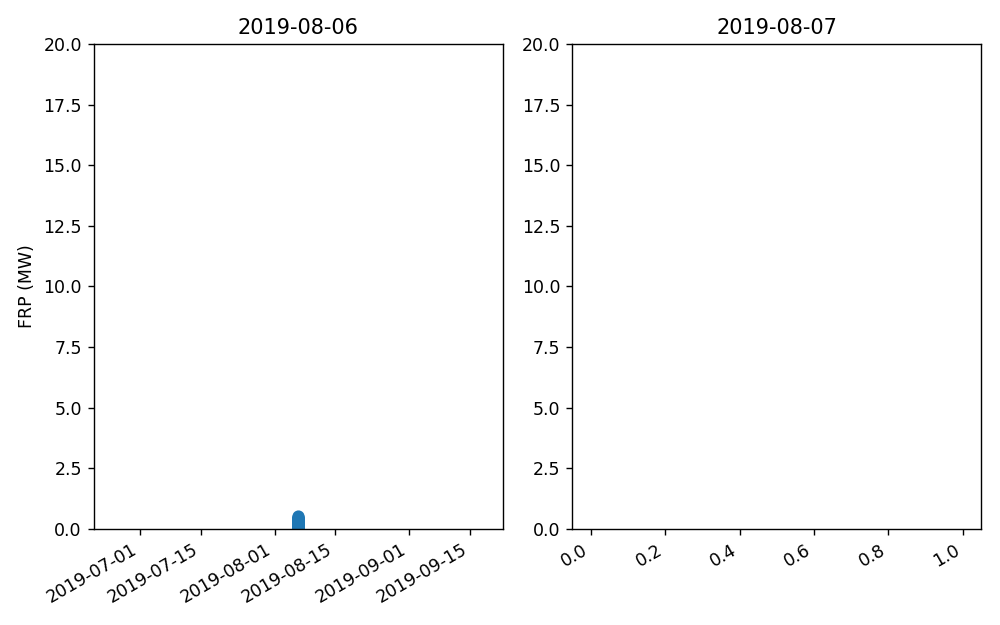

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [9]:
print(fire_detect_data["start_time"])
a = pd.to_datetime('2019-08-06T21').tz_localize('US/Pacific')
fire_detect_data["start_time"] < a

dates = ['2019-08-06','2019-08-07']
num_dates = len(dates)

fig, axs = plt.subplots(1, num_dates, figsize=(8,5))

for i in range(0, num_dates):
    date= dates[i]
    cutoff_max = pd.to_datetime(date+"T21").tz_localize('US/Pacific')
    cutoff_min = pd.to_datetime(date+"T01").tz_localize('US/Pacific')
    fire_on_date = fire_detect_data[(fire_detect_data["start_time"]>cutoff_min) & (fire_detect_data["start_time"]<cutoff_max)]
    axs[i].scatter(fire_on_date["start_time"], fire_on_date["FRP_T5"]/1e6)
    axs[i].set_ylim([0,20])
    axs[i].set_title(date)
axs[0].set_ylabel("FRP (MW)")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("WilliamsFlats_FirePixelFRP_T5.png")
plt.show()


[Timestamp('2019-08-06 11:41:00-0700', tz='US/Pacific')]


<IPython.core.display.Javascript object>


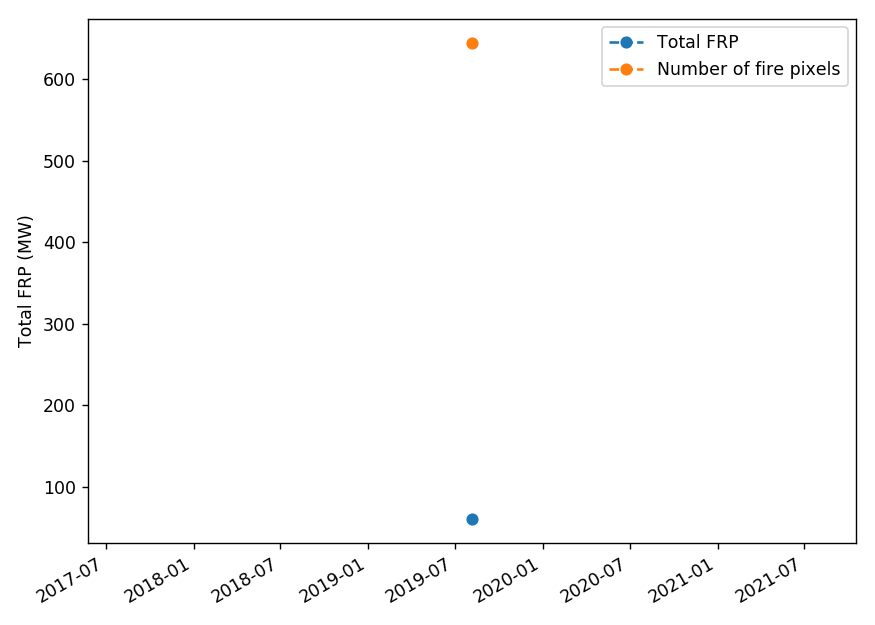

Total FRP [60.738940090639915]
Standard Deviation [0.0840275348917028]
Average FRP [0.0941688993653332]
Number of identified fire pixels [645]
Minimum 0.013512264644491918
Maximum 0.5375124422265497


In [10]:
dates = ['2019-08-06','2019-08-07']
num_dates = len(dates)

unique_starttimes = fire_detect_data["start_time"].unique()
print(unique_starttimes)

fig, axs = plt.subplots(1, 1, figsize=(7,5))
total_FRPs = []
ave_FRPs = []
stdev_FRPs = []
num_fires = []
for i in range(0, len(unique_starttimes)):
    fire_at_time = fire_detect_data[fire_detect_data["start_time"] == unique_starttimes[i]]
    total_FRP = fire_at_time["FRP_T5"].sum()
    ave_FRP = fire_at_time["FRP_T5"].mean()
    stdev_FRP= fire_at_time["FRP_T5"].std()
    
    total_FRPs.append(total_FRP/1e6)
    ave_FRPs.append(ave_FRP/1e6)
    stdev_FRPs.append(stdev_FRP/1e6)
    num_fire = len(fire_at_time)
    num_fires.append(num_fire)

print("Total FRP", total_FRPs)
print("Standard Deviation", stdev_FRPs)
print("Average FRP", ave_FRPs)
print("Number of identified fire pixels", num_fires)
print("Minimum", np.min(fire_at_time["FRP_T5"]/1e6))
print("Maximum", np.max(fire_at_time["FRP_T5"]/1e6))
    
plt.plot(unique_starttimes, total_FRPs, '--o', label="Total FRP")
#plt.plot(unique_starttimes, ave_FRPs, '--o', label="Ave FRP")
plt.plot(unique_starttimes, num_fires, '--o', label="Number of fire pixels")

plt.legend()
axs.set_ylabel("Total FRP (MW)")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("WilliamsFlats_TotalFRP_T5.png")
plt.show()


<IPython.core.display.Javascript object>


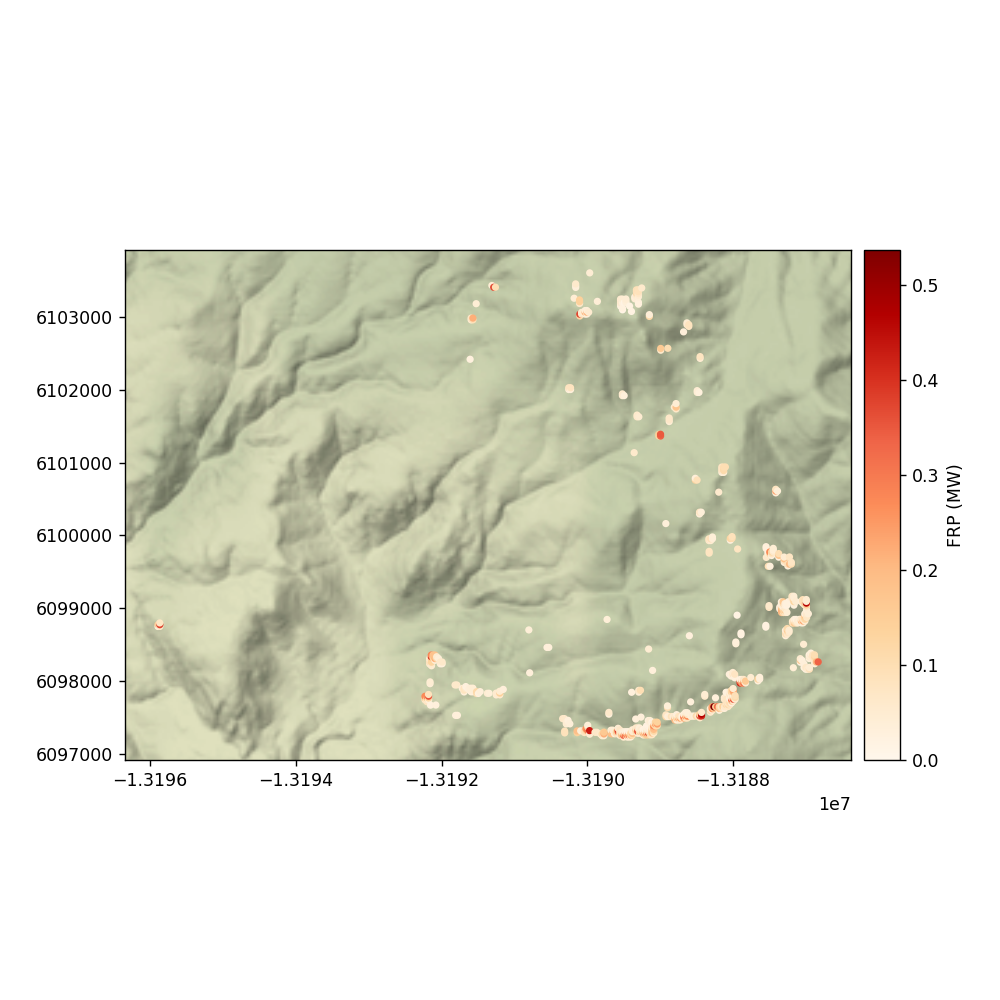

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


In [11]:
df = fire_detect_data.to_crs(epsg=3857)

unique_start_times = df['start_time'].unique()

target_time = unique_start_times[0]
df_time = df[df['start_time']==target_time]




bounds = df.total_bounds
#print(bounds)
unique_start_times = df['start_time'].unique()
target_time = unique_start_times[0]
df_time = df[df['start_time']==target_time]
df_time=df
#print(target_time)
#print(df_time.head())
fig, ax = plt.subplots(figsize=(8,8))

divider = make_axes_locatable(ax)
ax.set_aspect('equal')
cax = divider.append_axes("right", size="5%", pad=0.1)

#df.plot(ax=ax, column='FRP_T5', cmap='OrRd', markersize=5,
#        legend=True, legend_kwds={'label': "FRP, W"}, cax=cax)

points = df_time.geometry
xs = [point.x for point in points]
ys = [point.y for point in points]
zs = df_time["FRP_T5"]/1e6
sc=ax.scatter(xs, ys, c=zs, vmin=0, vmax=zs.max(), s=10, cmap='OrRd')
plt.colorbar(sc,cax, label="FRP (MW)")

ctx.add_basemap(ax, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), zoom=12)
#ctx.add_basemap(ax, url = getattr(ctx.sources, "T_WATERCOLOR"), zoom=12)
#ctx.add_basemap(ax, url = getattr(ctx.sources, "ST_TONER_BACKGROUND"), zoom=12)
#ctx.add_basemap(ax)
plt.savefig("FRP_all_fires_map.png")
plt.show()



In [23]:
FRPs = []
for pix in fire_detect_FRP_T5s:
    new = pix/1e6
    FRPs.append(new)
print(len(FRPs))
print(len(fire_detect_LfMIRs))

645
645


In [24]:
x= pd.Series(FRPs)
y = pd.Series(fire_detect_LfMIRs)

print(x.corr(y))
print(x.corr(y, method='spearman')) 
print(x.corr(y, method='kendall'))

0.9957553615027088
1.0
1.0


In [25]:
import scipy.stats
slope, intercept ,r, p, stderr = scipy.stats.linregress(FRPs,fire_detect_LfMIRs)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

Regression line: y=-2.37+109.84x, r=1.00


<IPython.core.display.Javascript object>


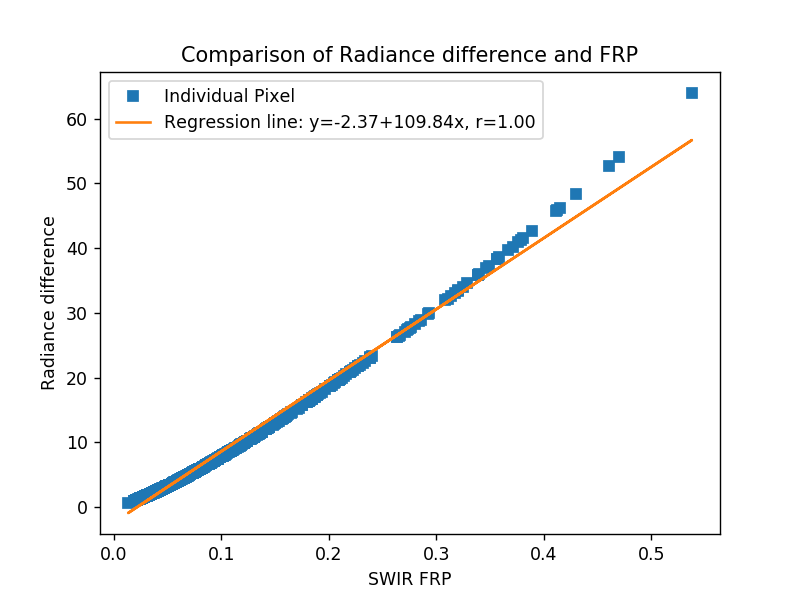

In [26]:
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Individual Pixel')
ax.plot(x, intercept + slope * x, label=line)
ax.set_title("Comparison of Radiance difference and FRP")
ax.set_xlabel('SWIR FRP')
ax.set_ylabel('Radiance difference')
ax.legend(facecolor='white')
plt.show()